# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


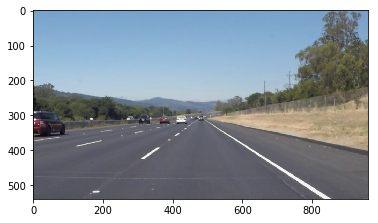

In [57]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions


Below are some helper functions to help get you started. They should look familiar from the lesson!

In [70]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    #cv2.fillPoly(mask, vertices, ignore_mask_color)
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32), ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def slope(line):
    for x1,y1,x2,y2 in line:
        m = (y2-y1)/(x2-x1)
    return m
        

def Outliers(slopes,slope_mean = 0  ):
    _THRESHOLD = 1    
    # Set upper and lower limit to 3 standard deviation    
    if(slope_mean <=  0):
        slope_data_mean = np.mean(slopes)
    else:
        slope_data_mean = slope_mean
    slope_data_std = np.std(slopes)

    anomaly_cut_off = float(slope_data_std * _THRESHOLD ) 
    
    
    lower_limit  = slope_data_mean - anomaly_cut_off 
    upper_limit  = slope_data_mean + anomaly_cut_off
    
    # Generate outliers
    anomalies = []
    for index,outlier in enumerate(slopes):
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies


def clean_lines(lines, slope_avg):    
    sl = [] 
    for line in lines:
        sl.append(slope(line))
    #x=[0.95,0.65,0.63,0.64,0.31]
    outliers=Outliers(sl , slope_avg)
    #print('Outlier elements->' ,outliers )
        
    valid_lines = []
    for line in lines:
        if(slope(line) in outliers ):
            continue
        else:
          valid_lines.append(line)              
   # print ('Cleaned array -> ', left_lines)        
    return valid_lines


def tpolyfit_lines(lines):
    x = []
    y = []
    
    for t  in lines:
        x1, y1, x2, y2 = t[0]
        x += [x1, x2]
        y += [y1, y2]
    
    z = np.polyfit(x, y, 1)
    #print(z)
    f = np.poly1d(z)
    
    return z


def takeSecond(elem):
    return elem[1]

def coordGenerator(lines, z, y):

    coord =[]
    for t in lines:
        x1,y1,x2,y2 = t[0]
        coord.append([x1,y1])
        coord.append([x2,y2])
    coord.sort(key=takeSecond,reverse=False)
    m,c=z
    #y=mx+c   
    x=int((y-c)/m)
    coord_f= list()
    coord_f.append([x,y])
    coord_f.append(coord[0])
    #coord.sort(key=takeSecond,reverse=True)
    return coord_f
     

    

def draw_lines(img, lines , gl_avg, color=[255, 0, 0], thickness=3 ):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

  
    color1 = [0,255,0]
    left_lines = [];
    right_lines = [];
    for line in lines:        
        if(slope(line) < 0 ):
            #print ('Line -> ',line, 'Slope ->', slope(line)  ) 
            left_lines.append(line)            
        else:
            right_lines.append(line) 
    
               
    #for x1,y1,x2,y2 in line:
    #   cv2.line(img, (x1, y1), (x2, y2), color1, thickness)
    valid_right_lines=clean_lines(right_lines,gl_avg[1])  
    z=tpolyfit_lines(valid_right_lines)       
    right_coords=coordGenerator(valid_right_lines,z,540)        
    x1,y1=right_coords[0]
    x2,y2=right_coords[1]
    cv2.line(img, (x1, y1), (x2, y2), color1, thickness)
    ml,c=z
    
    
    
    valid_left_lines=clean_lines(left_lines,gl_avg[0])
    z=tpolyfit_lines(valid_left_lines)
    left_coords=coordGenerator(valid_left_lines,z,540)     
    x1,y1=left_coords[0]
    x2,y2=left_coords[1]
    cv2.line(img, (x1, y1), (x2, y2), color1, thickness)
    mr,c=z
    
    return np.array([ml,mr],dtype=float)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    
    avg_init = False
    global_avg=np.array([0,0], dtype=float )
        
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    avg = draw_lines(line_img, lines, global_avg)
    
    if( avg_init == False):
        global_avg = avg
    else:
        global_avg= (global_avg + avg) / 2 
        
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

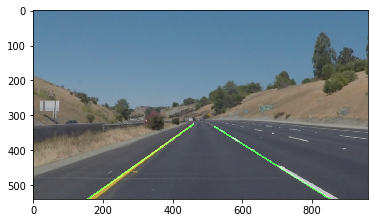

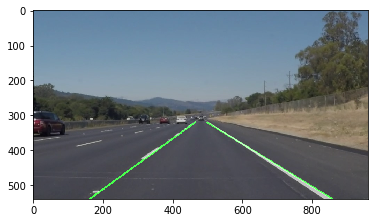

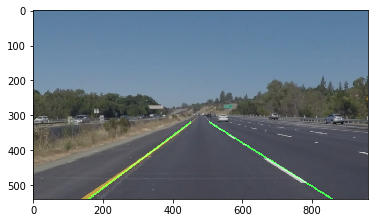

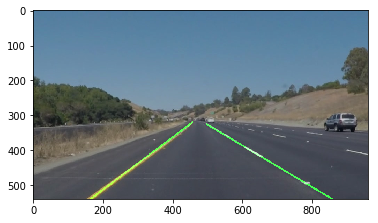

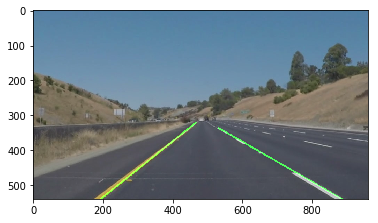

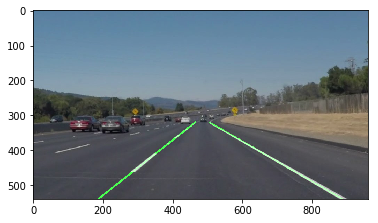

In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
dirs = os.listdir("test_images/") 

fig=plt.figure()
#for img in dirs:
img = 'solidWhiteCurve.jpg'

i=0    
for img in dirs:   
    
    image = mpimg.imread( 'test_images/'+img )

    #convert to grayscale
    img_gray=grayscale(image)
    #plt.imshow(img_gray)
    
    kernel_size=7
    gaussian_blur_img= gaussian_blur(img_gray,kernel_size)

    low_threshold = 50
    high_threshold = 150
    edges=canny(gaussian_blur_img, low_threshold, high_threshold)

    #plt.imshow(edges)

    #vertices_t = np.array([[130,540],[420,320],[550,320],[860,540]],dtype=np.int32)
    #vertices_t = np.array([[50,540],[435,320],[510,320],[900,540]],dtype=np.int32)

    vertices_l = np.array([[50,540],[435,320],[510,320],[900,540]],dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices_t)
    #plt.imshow(masked_edges)


    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 5 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 100   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 200   # maximum gap in pixels between connectable line segments

    t=hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    #plt.imshow(t)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    
    #top=weighted_img(color_edges, image, α=0.8, β=1, γ=0)
    top=weighted_img(t, image, α=0.8, β=1, γ=0)
    plt.figure()

    i = i+1
    plt.imshow(top)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [60]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [61]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [62]:
def process_image( image ):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)    
    
    print (image.shape)
    
    #image1 = mpimg.imread( image )
    #convert to grayscale
    img_gray=grayscale(image)
    #plt.imshow(img_gray)
    
    kernel_size=7
    gaussian_blur_img= gaussian_blur(img_gray,kernel_size)

    low_threshold = 50
    high_threshold = 150
    edges=canny(gaussian_blur_img, low_threshold, high_threshold)

    #vertices = np.array([[130,540],[420,320],[550,320],[860,540]],dtype=np.int32)
    vertices = np.array( [[ 0,540],[435,320],[510,320],[900,540] ], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)
    #plt.imshow(masked_edges)

    # Define the Hough transform parameters
    rho = 5 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 100   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 200   # maximum gap in pixels between connectable line segments

    t=hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a "color" binary image to combine with line image
    #color_edges = np.dstack((edges, edges, edges)) 
    
    #top=weighted_img(color_edges, image, α=0.8, β=1, γ=0)
    result = weighted_img(t, image, α=0.8, β=1, γ=0)
    return result

Let's try the one with the solid white lane on the right first ...

In [63]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

(540, 960, 3)
slopes [0.60655737704918034, 0.64822134387351782, 0.61764705882352944, 0.67105263157894735, 0.6171875, 0.67251461988304095, 0.63461538461538458, 0.67431192660550454, 0.60289855072463772, 0.48958333333333331]
slope_mean  and slope_data_mean, anamoly ->   0.0516715277264 0.623458972649 0.05167152772642365
limits 0.571787444922 0.675130500375
Outlier elements-> [0.48958333333333331]
slopes [-0.7010309278350515, -0.69955156950672648, -0.70329670329670335, -0.77876106194690264, -0.7007299270072993, -0.80519480519480524, -0.77934272300469487]
slope_mean  and slope_data_mean, anamoly ->   0.0436277730945 -0.738272531113 0.043627773094486504
limits -0.781900304208 -0.694644758019
Outlier elements-> [-0.80519480519480524]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  1%|▏         | 3/222 [00:00<00:08, 26.89it/s]

(540, 960, 3)
slopes [0.60655737704918034, 0.64822134387351782, 0.61764705882352944, 0.67105263157894735, 0.6171875, 0.67251461988304095, 0.63461538461538458, 0.67431192660550454, 0.60289855072463772, 0.48958333333333331]
slope_mean  and slope_data_mean, anamoly ->   0.0516715277264 0.623458972649 0.05167152772642365
limits 0.571787444922 0.675130500375
Outlier elements-> [0.48958333333333331]
slopes [-0.7010309278350515, -0.69955156950672648, -0.70329670329670335, -0.77876106194690264, -0.7007299270072993, -0.80519480519480524, -0.77934272300469487]
slope_mean  and slope_data_mean, anamoly ->   0.0436277730945 -0.738272531113 0.043627773094486504
limits -0.781900304208 -0.694644758019
Outlier elements-> [-0.80519480519480524]
(540, 960, 3)
slopes [0.60085836909871249, 0.625, 0.58078602620087338, 0.53600000000000003, 0.625, 0.61702127659574468, 0.5374149659863946, 0.61111111111111116]
slope_mean  and slope_data_mean, anamoly ->   0.0344384648974 0.591648968624 0.03443846489735364
limit


  4%|▍         | 9/222 [00:00<00:07, 26.72it/s]

(540, 960, 3)
slopes [0.64948453608247425, 0.61111111111111116, 0.61363636363636365, 0.64838709677419359, 0.60179640718562877, 0.62751677852348997]
slope_mean  and slope_data_mean, anamoly ->   0.0183148431124 0.625322048886 0.018314843112421594
limits 0.607007205773 0.643636891998
Outlier elements-> [0.64948453608247425, 0.64838709677419359, 0.60179640718562877]
slopes [-0.70454545454545459, -0.70481927710843373, -0.75316455696202533]
slope_mean  and slope_data_mean, anamoly ->   0.0228549974664 -0.720843096205 0.022854997466421216
limits -0.743698093672 -0.697988098739
Outlier elements-> [-0.75316455696202533]
(540, 960, 3)
slopes [0.62721893491124259, 0.60110803324099726, 0.62542955326460481]
slope_mean  and slope_data_mean, anamoly ->   0.0119094612667 0.617918840472 0.01190946126670951
limits 0.606009379206 0.629828301739
Outlier elements-> [0.60110803324099726]
slopes [-0.69756097560975605, -0.7258883248730964]
slope_mean  and slope_data_mean, anamoly ->   0.0141636746317 -0.7117


  5%|▍         | 11/222 [00:00<00:08, 24.25it/s]

slopes [0.60055096418732778, 0.62827225130890052, 0.66666666666666663, 0.56321839080459768, 0.67088607594936711, 0.6428571428571429]
slope_mean  and slope_data_mean, anamoly ->   0.0376429259916 0.628741915296 0.03764292599159961
limits 0.591098989304 0.666384841287
Outlier elements-> [0.66666666666666663, 0.56321839080459768, 0.67088607594936711]
slopes [-0.67532467532467533, -0.77777777777777779, -0.67567567567567566, -0.72727272727272729]
slope_mean  and slope_data_mean, anamoly ->   0.0424508661708 -0.714012714013 0.04245086617078945
limits -0.756463580184 -0.671561847842
Outlier elements-> [-0.77777777777777779]



  7%|▋         | 15/222 [00:00<00:07, 27.02it/s]

(540, 960, 3)
slopes [0.60230547550432278, 0.67078189300411528, 0.67455621301775148, 0.71844660194174759, 0.64130434782608692, 0.69402985074626866, 0.71844660194174759, 0.69718309859154926, 0.62406015037593987, 0.62454873646209386]
slope_mean  and slope_data_mean, anamoly ->   0.0393652696716 0.666566296941 0.03936526967157207
limits 0.62720102727 0.705931566613
Outlier elements-> [0.60230547550432278, 0.71844660194174759, 0.71844660194174759, 0.62406015037593987, 0.62454873646209386]
slopes [-0.67659574468085104, -0.72687224669603523, -0.67808219178082196, -0.69999999999999996]
slope_mean  and slope_data_mean, anamoly ->   0.0204032362095 -0.695387545789 0.020403236209549137
limits -0.715790781999 -0.67498430958
Outlier elements-> [-0.72687224669603523]
(540, 960, 3)
slopes [0.60349854227405253, 0.6517857142857143, 0.64615384615384619, 0.624]
slope_mean  and slope_data_mean, anamoly ->   0.0191474418253 0.631359525678 0.01914744182534665
limits 0.612212083853 0.650506967504
Outlier el

 [0.65909090909090906, 0.6523605150214592, 0.625, 0.66666666666666663, 0.69711538461538458, 0.67027027027027031]
slope_mean  and slope_data_mean, anamoly ->   0.0215765101282 0.661750624277 0.021576510128186326
limits 0.640174114149 0.683327134406
Outlier elements-> [0.625, 0.69711538461538458]
slopes [-0.67901234567901236, -0.70149253731343286, -0.72560975609756095]
slope_mean  and slope_data_mean, anamoly ->   0.0190272258605 -0.70203821303 0.019027225860494486
limits -0.72106543889 -0.68301098717
Outlier elements-> [-0.67901234567901236, -0.72560975609756095]
(540, 960, 3)
slopes [0.6333333333333333, 0.6728395061728395, 0.58139534883720934, 0.59999999999999998, 0.63095238095238093, 0.58181818181818179, 0.72058823529411764, 0.55797101449275366, 0.65000000000000002, 0.66666666666666663, 0.69841269841269837, 0.55555555555555558, 0.5547945205479452]
slope_mean  and slope_data_mean, anamoly ->   0.0539825658876 0.623409803237 0.05398256588762745
limits 0.56942723735 0.677392369125
Outlie

 10%|█         | 23/222 [00:00<00:06, 30.69it/s]

(540, 960, 3)
slopes [0.62464183381088823, 0.65116279069767447, 0.65104166666666663, 0.63636363636363635, 0.63793103448275867, 0.65094339622641506]
slope_mean  and slope_data_mean, anamoly ->   0.00996094564086 0.642014059708 0.009960945640863828
limits 0.632053114067 0.651975005349
Outlier elements-> [0.62464183381088823]
slopes [-0.69915254237288138, -0.70338983050847459, -0.72368421052631582]
slope_mean  and slope_data_mean, anamoly ->   0.0107062765259 -0.708742194469 0.010706276525907707
limits -0.719448470995 -0.698035917943
Outlier elements-> [-0.72368421052631582]
(540, 960, 3)
slopes [0.62464183381088823, 0.67177914110429449, 0.63829787234042556, 0.66972477064220182, 0.6875]
slope_mean  and slope_data_mean, anamoly ->   0.0232283039927 0.65838872358 0.02322830399272545
limits 0.635160419587 0.681617027572
Outlier elements-> [0.62464183381088823, 0.6875]
slopes [-0.7269076305220884, -0.72519083969465647, -0.70034843205574915]
slope_mean  and slope_data_mean, anamoly ->   0.0121


 14%|█▍        | 31/222 [00:01<00:05, 32.51it/s]

(540, 960, 3)
slopes [0.62385321100917435, 0.65151515151515149, 0.64963503649635035]
slope_mean  and slope_data_mean, anamoly ->   0.0126201792138 0.641667799674 0.01262017921378007
limits 0.62904762046 0.654287978887
Outlier elements-> [0.62385321100917435]
slopes [-0.6759581881533101, -0.75272727272727269, -0.75196850393700787, -0.72602739726027399]
slope_mean  and slope_data_mean, anamoly ->   0.0311893273494 -0.726670340519 0.03118932734937401
limits -0.757859667869 -0.69548101317
Outlier elements-> [-0.6759581881533101]
(540, 960, 3)
slopes [0.62643678160919536, 0.65165165165165162, 0.66949152542372881, 0.67384615384615387, 0.6253968253968254]
slope_mean  and slope_data_mean, anamoly ->   0.0205417101848 0.649364587586 0.020541710184798757
limits 0.628822877401 0.66990629777
Outlier elements-> [0.62643678160919536, 0.67384615384615387, 0.6253968253968254]
slopes [-0.67901234567901236, -0.67441860465116277, -0.75636363636363635]
slope_mean  and slope_data_mean, anamoly ->   0.03759

slopes [0.65100671140939592, 0.59999999999999998, 0.60392156862745094, 0.6253968253968254, 0.62385321100917435, 0.67224080267558528]
slope_mean  and slope_data_mean, anamoly ->   0.0253721863173 0.62940318652 0.025372186317277452
limits 0.604031000202 0.654775372837
Outlier elements-> [0.59999999999999998, 0.60392156862745094, 0.67224080267558528]
slopes [-0.70258620689655171, -0.70085470085470081, -0.72566371681415931, -0.75242718446601942]
slope_mean  and slope_data_mean, anamoly ->   0.0209332035319 -0.720382952258 0.020933203531887715
limits -0.74131615579 -0.699449748726
Outlier elements-> [-0.75242718446601942]
(540, 960, 3)
slopes [0.65217391304347827, 0.67441860465116277, 0.60269360269360273, 0.63414634146341464, 0.56034482758620685, 0.6739811912225705, 0.56097560975609762, 0.69444444444444442, 0.5816993464052288, 0.71999999999999997, 0.77586206896551724]
slope_mean  and slope_data_mean, anamoly ->   0.0653497882321 0.648249086385 0.0653497882321067
limits 0.582899298153 0.7135

 16%|█▌        | 35/222 [00:01<00:05, 33.82it/s]


(540, 960, 3)
slopes [0.62109375, 0.67114093959731547, 0.6967741935483871, 0.55921052631578949, 0.67384615384615387, 0.62541806020066892, 0.58048780487804874]
slope_mean  and slope_data_mean, anamoly ->   0.0471935810747 0.632567346912 0.04719358107469836
limits 0.585373765838 0.679760927987
Outlier elements-> [0.6967741935483871, 0.55921052631578949, 0.58048780487804874]
slopes [-0.70334928229665072, -0.7277227722772277, -0.75126903553299496]
slope_mean  and slope_data_mean, anamoly ->   0.0195641289592 -0.727447030036 0.01956412895915863
limits -0.747011158995 -0.707882901076
Outlier elements-> [-0.70334928229665072, -0.75126903553299496]
(540, 960, 3)
slopes [0.625, 0.66883116883116878, 0.6964285714285714, 0.6954022988505747, 0.69767441860465118, 0.6967741935483871, 0.55855855855855852, 0.69633507853403143, 0.63461538461538458]
slope_mean  and slope_data_mean, anamoly ->   0.0457196266692 0.663291074775 0.045719626669223
limits 0.617571448105 0.709010701444
Outlier elements-> [0.558

 18%|█▊        | 39/222 [00:01<00:05, 34.15it/s]

(540, 960, 3)
slopes [0.63265306122448983, 0.64429530201342278, 0.60479041916167664, 0.58201058201058198, 0.6428571428571429, 0.66153846153846152, 0.57999999999999996, 0.58100558659217882, 0.6741573033707865, 0.57948717948717954, 0.58125000000000004, 0.69607843137254899]
slope_mean  and slope_data_mean, anamoly ->   0.0404386285165 0.621676955802 0.0404386285165251
limits 0.581238327286 0.662115584319
Outlier elements-> [0.57999999999999996, 0.58100558659217882, 0.6741573033707865, 0.57948717948717954, 0.69607843137254899]
slopes [-0.7567567567567568, -0.70033670033670037, -0.75257731958762886, -0.75454545454545452, -0.75179856115107913, -0.78148148148148144]
slope_mean  and slope_data_mean, anamoly ->   0.0242647705978 -0.74958271231 0.024264770597800054
limits -0.773847482908 -0.725317941712
Outlier elements-> [-0.70033670033670037, -0.78148148148148144]
(540, 960, 3)
slopes [0.62285714285714289, 0.65384615384615385, 0.66666666666666663, 0.6556291390728477, 0.70053475935828879, 0.697


 21%|██        | 46/222 [00:01<00:07, 22.83it/s]

(540, 960, 3)
slopes [0.62464183381088823, 0.67407407407407405, 0.69626168224299068, 0.6954022988505747, 0.60666666666666669, 0.56338028169014087, 0.58227848101265822, 0.65217391304347827]
slope_mean  and slope_data_mean, anamoly ->   0.0474532612558 0.636859903924 0.047453261255802535
limits 0.589406642668 0.68431316518
Outlier elements-> [0.69626168224299068, 0.6954022988505747, 0.56338028169014087, 0.58227848101265822]
slopes [-0.72727272727272729, -0.75, -0.75233644859813087]
slope_mean  and slope_data_mean, anamoly ->   0.0113047583116 -0.743203058624 0.011304758311579498
limits -0.754507816935 -0.731898300312
Outlier elements-> [-0.72727272727272729]
(540, 960, 3)
slopes [0.6428571428571429, 0.64634146341463417, 0.66666666666666663, 0.65753424657534243, 0.72185430463576161, 0.63414634146341464, 0.6966292134831461, 0.55970149253731338, 0.65671641791044777, 0.62464183381088823, 0.66666666666666663]
slope_mean  and slope_data_mean, anamoly ->   0.0393770269393 0.652159617275 0.03937


 22%|██▏       | 49/222 [00:01<00:08, 19.77it/s]

(540, 960, 3)
slopes [0.62285714285714289, 0.66666666666666663, 0.65957446808510634, 0.67500000000000004, 0.60689655172413792, 0.69613259668508287, 0.72881355932203384]
slope_mean  and slope_data_mean, anamoly ->   0.0384067102032 0.665134426477 0.0384067102031566
limits 0.626727716274 0.70354113668
Outlier elements-> [0.62285714285714289, 0.60689655172413792, 0.72881355932203384]
slopes [-0.75520833333333337, -0.69756097560975605]
slope_mean  and slope_data_mean, anamoly ->   0.0288236788618 -0.726384654472 0.02882367886178866
limits -0.755208333333 -0.69756097561
Outlier elements-> [-0.75520833333333337]
(540, 960, 3)
slopes [0.63235294117647056, 0.6454545454545455, 0.67482517482517479, 0.6428571428571429, 0.67272727272727273, 0.64646464646464652, 0.58441558441558439, 0.69599999999999995]
slope_mean  and slope_data_mean, anamoly ->   0.0315093800012 0.64938716349 0.03150938000123113
limits 0.617877783489 0.680896543491
Outlier elements-> [0.58441558441558439, 0.69599999999999995]
slo


 24%|██▍       | 54/222 [00:02<00:09, 17.01it/s]

(540, 960, 3)
slopes [0.62704918032786883, 0.67148014440433212, 0.60571428571428576, 0.64550264550264547, 0.67052023121387283, 0.64457831325301207]
slope_mean  and slope_data_mean, anamoly ->   0.0231447641589 0.644140800069 0.0231447641588501
limits 0.62099603591 0.667285564228
Outlier elements-> [0.67148014440433212, 0.60571428571428576, 0.67052023121387283]
slopes [-0.69867549668874174, -0.74838709677419357, -0.75471698113207553, -0.65151515151515149, -0.69827586206896552]
slope_mean  and slope_data_mean, anamoly ->   0.0378387672596 -0.710314117636 0.03783876725962495
limits -0.748152884895 -0.672475350376
Outlier elements-> [-0.74838709677419357, -0.75471698113207553, -0.65151515151515149]
(540, 960, 3)
slopes [0.62761506276150625, 0.65765765765765771, 0.60526315789473684, 0.67153284671532842, 0.60434782608695647, 0.5178571428571429, 0.6216216216216216, 0.59999999999999998]
slope_mean  and slope_data_mean, anamoly ->   0.0433932109146 0.613236914449 0.043393210914578484
limits 0.5


 25%|██▌       | 56/222 [00:02<00:10, 15.10it/s]

slopes [0.62737642585551334, 0.65492957746478875, 0.60399999999999998, 0.6428571428571429, 0.60512820512820509, 0.67182662538699689, 0.66666666666666663]
slope_mean  and slope_data_mean, anamoly ->   0.0256878517875 0.638969234766 0.025687851787515634
limits 0.613281382978 0.664657086553
Outlier elements-> [0.60399999999999998, 0.60512820512820509, 0.67182662538699689, 0.66666666666666663]
slopes [-0.67500000000000004, -0.7021276595744681, -0.69791666666666663]
slope_mean  and slope_data_mean, anamoly ->   0.011920178906 -0.69168144208 0.011920178906044108
limits -0.703601620986 -0.679761263174
Outlier elements-> [-0.67500000000000004]
(540, 960, 3)
slopes [0.62721893491124259, 0.67701863354037262, 0.71739130434782605, 0.65277777777777779, 0.6728395061728395]
slope_mean  and slope_data_mean, anamoly ->   0.0297609390905 0.66944923135 0.02976093909048895
limits 0.63968829226 0.699210170441
Outlier elements-> [0.62721893491124259, 0.71739130434782605]
slopes [-0.69868995633187769, -0.673


 27%|██▋       | 60/222 [00:02<00:11, 13.55it/s]

(540, 960, 3)
slopes [0.62758620689655176, 0.6542553191489362, 0.67213114754098358, 0.64130434782608692, 0.66216216216216217, 0.6741573033707865, 0.63218390804597702, 0.53781512605042014, 0.75, 0.64423076923076927, 0.67372881355932202]
slope_mean  and slope_data_mean, anamoly ->   0.047941078686 0.651777736712 0.04794107868602004
limits 0.603836658026 0.699718815398
Outlier elements-> [0.53781512605042014, 0.75]
slopes [-0.69948186528497414, -0.64893617021276595, -0.69886363636363635]
slope_mean  and slope_data_mean, anamoly ->   0.0236830961132 -0.682427223954 0.023683096113234058
limits -0.706110320067 -0.658744127841
Outlier elements-> [-0.64893617021276595]
(540, 960, 3)
slopes [0.67164179104477617, 0.6280193236714976, 0.69696969696969702, 0.72327044025157228, 0.58407079646017701, 0.69999999999999996, 0.64516129032258063, 0.67153284671532842]
slope_mean  and slope_data_mean, anamoly ->   0.0418926045674 0.665083273179 0.04189260456739935
limits 0.623190668612 0.706975877747
Outlier


 28%|██▊       | 62/222 [00:02<00:11, 14.12it/s]

slopes [0.67158671586715868, 0.6484375, 0.63793103448275867, 0.66666666666666663, 0.66176470588235292, 0.625, 0.62857142857142856]
slope_mean  and slope_data_mean, anamoly ->   0.0173207207619 0.648565435924 0.017320720761854543
limits 0.631244715162 0.665886156686
Outlier elements-> [0.67158671586715868, 0.66666666666666663, 0.625, 0.62857142857142856]
slopes [-0.65267175572519087, -0.72540983606557374, -0.67307692307692313]
slope_mean  and slope_data_mean, anamoly ->   0.0306339190516 -0.683719504956 0.030633919051589183
limits -0.714353424007 -0.653085585904
Outlier elements-> [-0.65267175572519087, -0.72540983606557374]
(540, 960, 3)
slopes [0.671875, 0.69658119658119655, 0.60465116279069764, 0.62987012987012991, 0.60526315789473684, 0.67924528301886788, 0.58333333333333337, 0.6484375, 0.77894736842105261, 0.58024691358024694, 0.75206611570247939, 0.69787234042553192]
slope_mean  and slope_data_mean, anamoly ->   0.0614017671944 0.660699125135 0.06140176719437527
limits 0.599297357


 29%|██▉       | 64/222 [00:03<00:13, 11.72it/s]

(540, 960, 3)
slopes [0.67450980392156867, 0.64676616915422891, 0.58620689655172409, 0.68518518518518523, 0.58333333333333337, 0.67492260061919507, 0.62406015037593987]
slope_mean  and slope_data_mean, anamoly ->   0.0393760086108 0.639283448449 0.03937600861079609
limits 0.599907439838 0.67865945706
Outlier elements-> [0.58620689655172409, 0.68518518518518523, 0.58333333333333337]
slopes [-0.69672131147540983, -0.6518518518518519, -0.69999999999999996, -0.69999999999999996, -0.67434210526315785]
slope_mean  and slope_data_mean, anamoly ->   0.0189679222245 -0.684583053718 0.018967922224464837
limits -0.703550975943 -0.665615131494
Outlier elements-> [-0.6518518518518519]
(540, 960, 3)
slopes [0.67492260061919507, 0.64516129032258063, 0.6333333333333333, 0.60526315789473684, 0.6033519553072626, 0.69863013698630139]
slope_mean  and slope_data_mean, anamoly ->   0.0346572152902 0.643443745744 0.03465721529021457
limits 0.608786530454 0.678100961034
Outlier elements-> [0.60526315789473684


 30%|██▉       | 66/222 [00:03<00:13, 11.25it/s]


slopes [0.6728395061728395, 0.64743589743589747, 0.64912280701754388, 0.66000000000000003, 0.69607843137254899, 0.66216216216216217, 0.64985163204747776]
slope_mean  and slope_data_mean, anamoly ->   0.0160652164304 0.662498633744 0.016065216430409618
limits 0.646433417314 0.678563850174
Outlier elements-> [0.69607843137254899]
slopes [-0.69523809523809521, -0.67231638418079098]
slope_mean  and slope_data_mean, anamoly ->   0.0114608555287 -0.683777239709 0.011460855528652114
limits -0.695238095238 -0.672316384181
Outlier elements-> []
(540, 960, 3)
slopes [0.6728395061728395, 0.6262295081967213, 0.62611275964391688, 0.58585858585858586, 0.7192982456140351]
slope_mean  and slope_data_mean, anamoly ->   0.045817754945 0.646067721097 0.04581775494503301
limits 0.600249966152 0.691885476042
Outlier elements-> [0.58585858585858586, 0.7192982456140351]
slopes [-0.67156862745098034, -0.65094339622641506, -0.71999999999999997]
slope_mean  and slope_data_mean, anamoly ->   0.0289440313072 -0.


 31%|███       | 68/222 [00:03<00:15,  9.88it/s]

(540, 960, 3)
slopes [0.6728395061728395, 0.63043478260869568, 0.64688427299703266, 0.62962962962962965, 0.63265306122448983, 0.62426035502958577]
slope_mean  and slope_data_mean, anamoly ->   0.0164558249408 0.639450267944 0.01645582494082628
limits 0.622994443003 0.655906092885
Outlier elements-> [0.6728395061728395]
slopes [-0.67420814479638014, -0.67099567099567103, -0.72173913043478266]
slope_mean  and slope_data_mean, anamoly ->   0.0232006064565 -0.688980982076 0.02320060645645817
limits -0.712181588532 -0.665780375619
Outlier elements-> [-0.72173913043478266]
(540, 960, 3)
slopes [0.6728395061728395, 0.64768683274021355, 0.67384615384615387, 0.63265306122448983, 0.64102564102564108]
slope_mean  and slope_data_mean, anamoly ->   0.0168042798946 0.653610239002 0.016804279894564282
limits 0.636805959107 0.670414518896
Outlier elements-> [0.6728395061728395, 0.67384615384615387, 0.63265306122448983]
slopes [-0.67407407407407405, -0.6738351254480287, -0.72440944881889768]
slope_mean


 32%|███▏      | 70/222 [00:03<00:14, 10.34it/s]

slopes [0.6728395061728395, 0.64743589743589747, 0.62857142857142856]
slope_mean  and slope_data_mean, anamoly ->   0.018137971885 0.649615610727 0.018137971885040557
limits 0.631477638842 0.667753582612
Outlier elements-> [0.6728395061728395, 0.62857142857142856]
slopes [-0.67261904761904767, -0.70129870129870131, -0.62585034013605445]
slope_mean  and slope_data_mean, anamoly ->   0.0310953546673 -0.666589363018 0.031095354667259396
limits -0.697684717685 -0.635494008351
Outlier elements-> [-0.70129870129870131, -0.62585034013605445]
(540, 960, 3)
slopes [0.67492260061919507, 0.64880952380952384, 0.64102564102564108]
slope_mean  and slope_data_mean, anamoly ->   0.0144970705138 0.654919255151 0.014497070513835421
limits 0.640422184638 0.669416325665
Outlier elements-> [0.67492260061919507]
slopes [-0.72189349112426038, -0.671875, -0.6216216216216216, -0.61016949152542377]
slope_mean  and slope_data_mean, anamoly ->   0.0443724805289 -0.656389901068 0.04437248052886319
limits -0.700762


 32%|███▏      | 72/222 [00:03<00:16,  9.29it/s]

(540, 960, 3)
slopes [0.67601246105919, 0.66666666666666663, 0.64985163204747776, 0.69745222929936301, 0.67532467532467533, 0.64766839378238339]
slope_mean  and slope_data_mean, anamoly ->   0.0169591302886 0.66882934303 0.016959130288614885
limits 0.651870212741 0.685788473319
Outlier elements-> [0.64985163204747776, 0.69745222929936301, 0.64766839378238339]
slopes [-0.69801980198019797, -0.62721893491124259, -0.64953271028037385]
slope_mean  and slope_data_mean, anamoly ->   0.029555344338 -0.658257149057 0.02955534433801383
limits -0.687812493395 -0.628701804719
Outlier elements-> [-0.69801980198019797, -0.62721893491124259]
(540, 960, 3)
slopes [0.64880952380952384, 0.67524115755627012, 0.64985163204747776]
slope_mean  and slope_data_mean, anamoly ->   0.0122217713649 0.657967437804 0.012221771364901636
limits 0.64574566644 0.670189209169
Outlier elements-> [0.67524115755627012]
slopes [-0.69784172661870503, -0.69827586206896552, -0.69620253164556967, -0.72395833333333337, -0.69565


 34%|███▍      | 76/222 [00:04<00:13, 10.77it/s]

slopes [0.64880952380952384, 0.67601246105919, 0.64688427299703266, 0.69776119402985071, 0.60504201680672265]
slope_mean  and slope_data_mean, anamoly ->   0.0312089160831 0.65490189374 0.031208916083142146
limits 0.623692977657 0.686110809824
Outlier elements-> [0.69776119402985071, 0.60504201680672265]
slopes [-0.65189873417721522, -0.70033670033670037, -0.72327044025157228]
slope_mean  and slope_data_mean, anamoly ->   0.0297510287779 -0.691835291588 0.029751028777944683
limits -0.721586320366 -0.662084262811
Outlier elements-> [-0.65189873417721522, -0.72327044025157228]
(540, 960, 3)
slopes [0.6517857142857143, 0.70096463022508038, 0.69480519480519476, 0.74747474747474751, 0.6071428571428571, 0.69444444444444442, 0.60526315789473684, 0.69523809523809521]
slope_mean  and slope_data_mean, anamoly ->   0.0462497947491 0.674639855189 0.04624979474905571
limits 0.62839006044 0.720889649938
Outlier elements-> [0.74747474747474751, 0.6071428571428571, 0.60526315789473684]
slopes [-0.6264


 35%|███▌      | 78/222 [00:04<00:12, 11.90it/s]

slopes [0.64968152866242035, 0.69756097560975605, 0.67889908256880738, 0.67441860465116277, 0.62758620689655176]
slope_mean  and slope_data_mean, anamoly ->   0.0243908968939 0.665629279678 0.02439089689385103
limits 0.641238382784 0.690020176572
Outlier elements-> [0.69756097560975605, 0.62758620689655176]
slopes [-0.64848484848484844, -0.70032573289902278, -0.64848484848484844, -0.67375886524822692, -0.67320261437908502]
slope_mean  and slope_data_mean, anamoly ->   0.0193041070988 -0.668851381899 0.019304107098805815
limits -0.688155488998 -0.6495472748
Outlier elements-> [-0.64848484848484844, -0.70032573289902278, -0.64848484848484844]
(540, 960, 3)
slopes [0.65064102564102566, 0.69668246445497628, 0.67816091954022983, 0.65853658536585369, 0.66666666666666663, 0.62773722627737227]
slope_mean  and slope_data_mean, anamoly ->   0.0215789472142 0.663070814658 0.02157894721416914
limits 0.641491867444 0.684649761872
Outlier elements-> [0.69668246445497628, 0.62773722627737227]
slopes 


 37%|███▋      | 82/222 [00:04<00:10, 13.37it/s]

(540, 960, 3)
slopes [0.69874476987447698, 0.65074626865671636, 0.7232142857142857, 0.72432432432432436, 0.72361809045226133]
slope_mean  and slope_data_mean, anamoly ->   0.0283923575641 0.704129547804 0.0283923575640711
limits 0.67573719024 0.732521905368
Outlier elements-> [0.65074626865671636]
slopes [-0.67256637168141598, -0.67420814479638014, -0.67420814479638014, -0.6470588235294118]
slope_mean  and slope_data_mean, anamoly ->   0.0115385146931 -0.667010371201 0.011538514693091376
limits -0.678548885894 -0.655471856508
Outlier elements-> [-0.6470588235294118]
(540, 960, 3)
slopes [0.65074626865671636, 0.69863013698630139, 0.77215189873417722, 0.71641791044776115, 0.7528089887640449, 0.65074626865671636, 0.75454545454545452]
slope_mean  and slope_data_mean, anamoly ->   0.045943004954 0.713720989542 0.045943004953985955
limits 0.667777984588 0.759663994496
Outlier elements-> [0.65074626865671636, 0.77215189873417722, 0.65074626865671636]
slopes [-0.67537313432835822, -0.648550724


 39%|███▊      | 86/222 [00:04<00:09, 14.75it/s]

(540, 960, 3)
slopes [0.70096463022508038, 0.6506550218340611, 0.67182662538699689, 0.65555555555555556]
slope_mean  and slope_data_mean, anamoly ->   0.01965175537 0.66975045825 0.019651755370007986
limits 0.65009870288 0.68940221362
Outlier elements-> [0.70096463022508038]
slopes [-0.64814814814814814, -0.67149758454106279]
slope_mean  and slope_data_mean, anamoly ->   0.0116747181965 -0.659822866345 0.011674718196457323
limits -0.671497584541 -0.648148148148
Outlier elements-> []
(540, 960, 3)
slopes [0.69871794871794868, 0.65248226950354615, 0.67384615384615387, 0.62727272727272732]
slope_mean  and slope_data_mean, anamoly ->   0.0263649678982 0.663079774835 0.026364967898236436
limits 0.636714806937 0.689444742733
Outlier elements-> [0.69871794871794868, 0.62727272727272732]
slopes [-0.67200000000000004, -0.6472868217054264, -0.69633507853403143]
slope_mean  and slope_data_mean, anamoly ->   0.0200240653176 -0.671873966746 0.02002406531762791
limits -0.691898032064 -0.651849901429


 41%|████      | 90/222 [00:05<00:08, 15.45it/s]

(540, 960, 3)
slopes [0.67441860465116277, 0.70096463022508038, 0.69444444444444442, 0.62745098039215685, 0.7007299270072993, 0.69999999999999996, 0.68181818181818177, 0.69411764705882351]
slope_mean  and slope_data_mean, anamoly ->   0.0232621603417 0.68424305195 0.02326216034174098
limits 0.660980891608 0.707505212291
Outlier elements-> [0.62745098039215685]
slopes [-0.69918699186991873, -0.62621359223300976, -0.62592592592592589, -0.69741697416974169]
slope_mean  and slope_data_mean, anamoly ->   0.0361216764307 -0.66218587105 0.03612167643068441
limits -0.69830754748 -0.626064194619
Outlier elements-> [-0.69918699186991873, -0.62592592592592589]
(540, 960, 3)
slopes [0.67307692307692313, 0.70238095238095233, 0.65116279069767447, 0.65315315315315314, 0.7831325301204819, 0.6333333333333333]
slope_mean  and slope_data_mean, anamoly ->   0.0497850644387 0.682706613794 0.049785064438685085
limits 0.632921549355 0.732491678232
Outlier elements-> [0.7831325301204819]
slopes [-0.7012448132


 41%|████▏     | 92/222 [00:05<00:08, 14.89it/s]

(540, 960, 3)
slopes [0.67576791808873715, 0.70155038759689925, 0.63265306122448983, 0.72695035460992907, 0.67464114832535882, 0.72388059701492535]
slope_mean  and slope_data_mean, anamoly ->   0.0325839749682 0.68924057781 0.03258397496818808
limits 0.656656602842 0.721824552778
Outlier elements-> [0.63265306122448983, 0.72695035460992907, 0.72388059701492535]
slopes [-0.64730290456431538, -0.64974619289340096, -0.63829787234042556, -0.61971830985915488]
slope_mean  and slope_data_mean, anamoly ->   0.0117948825589 -0.638766319914 0.011794882558915627
limits -0.650561202473 -0.626971437355
Outlier elements-> [-0.61971830985915488]
(540, 960, 3)
slopes [0.67636363636363639, 0.70192307692307687, 0.77551020408163263, 0.77906976744186052, 0.7142857142857143, 0.75]
slope_mean  and slope_data_mean, anamoly ->   0.03817088443 0.732858733183 0.0381708844299823
limits 0.694687848753 0.771029617613
Outlier elements-> [0.67636363636363639, 0.77551020408163263, 0.77906976744186052]
slopes [-0.698


 44%|████▎     | 97/222 [00:05<00:07, 16.04it/s]

(540, 960, 3)
slopes [0.72330097087378642, 0.67567567567567566, 0.75124378109452739, 0.75, 0.75, 0.71951219512195119, 0.6875]
slope_mean  and slope_data_mean, anamoly ->   0.0286998771014 0.722461803252 0.028699877101351627
limits 0.693761926151 0.751161680354
Outlier elements-> [0.67567567567567566, 0.75124378109452739, 0.6875]
slopes [-0.625, -0.69950738916256161, -0.64953271028037385]
slope_mean  and slope_data_mean, anamoly ->   0.0310029988566 -0.658013366481 0.03100299885656215
limits -0.689016365338 -0.627010367624
Outlier elements-> [-0.625, -0.69950738916256161]
(540, 960, 3)
slopes [0.72314049586776863, 0.67615658362989328, 0.70731707317073167, 0.71698113207547165, 0.62962962962962965, 0.74647887323943662, 0.67567567567567566, 0.65271966527196656, 0.72463768115942029, 0.77868852459016391, 0.7767857142857143]
slope_mean  and slope_data_mean, anamoly ->   0.0457420635838 0.709837368054 0.04574206358379919
limits 0.66409530447 0.755579431638
Outlier elements-> [0.629629629629629


 45%|████▌     | 101/222 [00:05<00:07, 16.16it/s]

(540, 960, 3)
slopes [0.67592592592592593, 0.72535211267605637, 0.69607843137254899, 0.7142857142857143, 0.75257731958762886, 0.75]
slope_mean  and slope_data_mean, anamoly ->   0.0274826501369 0.719036583975 0.02748265013693051
limits 0.691553933838 0.746519234112
Outlier elements-> [0.67592592592592593, 0.75257731958762886, 0.75]
slopes [-0.65198237885462551, -0.64893617021276595, -0.67474048442906576, -0.69999999999999996, -0.70085470085470081, -0.70034843205574915]
slope_mean  and slope_data_mean, anamoly ->   0.0224534605895 -0.679477027734 0.022453460589481493
limits -0.701930488324 -0.657023567145
Outlier elements-> [-0.65198237885462551, -0.64893617021276595]
(540, 960, 3)
slopes [0.72490706319702602, 0.6785714285714286, 0.65296803652968038, 0.77570093457943923, 0.67500000000000004, 0.74285714285714288]
slope_mean  and slope_data_mean, anamoly ->   0.0429479798052 0.708334100956 0.04294797980517474
limits 0.665386121151 0.751282080761
Outlier elements-> [0.65296803652968038, 0.


 47%|████▋     | 105/222 [00:06<00:07, 16.14it/s]

(540, 960, 3)
slopes [0.726457399103139, 0.6506024096385542, 0.6728395061728395, 0.69999999999999996, 0.77611940298507465, 0.65000000000000002]
slope_mean  and slope_data_mean, anamoly ->   0.0448629793953 0.69600311965 0.044862979395345115
limits 0.651140140255 0.740866099045
Outlier elements-> [0.6506024096385542, 0.77611940298507465, 0.65000000000000002]
slopes [-0.65145228215767637, -0.6495726495726496, -0.67701863354037262]
slope_mean  and slope_data_mean, anamoly ->   0.012518667739 -0.65934785509 0.012518667738997265
limits -0.671866522829 -0.646829187351
Outlier elements-> [-0.67701863354037262]
(540, 960, 3)
slopes [0.72685185185185186, 0.66666666666666663, 0.65277777777777779, 0.70096463022508038, 0.67182662538699689, 0.65106382978723409, 0.6097560975609756]
slope_mean  and slope_data_mean, anamoly ->   0.0347960363813 0.668558211322 0.03479603638125824
limits 0.633762174941 0.703354247704
Outlier elements-> [0.72685185185185186, 0.6097560975609756]
slopes [-0.651162790697674


 49%|████▉     | 109/222 [00:06<00:07, 15.95it/s]

(540, 960, 3)
slopes [0.67286245353159846, 0.70138888888888884, 0.69871794871794868, 0.67412140575079871]
slope_mean  and slope_data_mean, anamoly ->   0.0133217129863 0.686772674222 0.013321712986307592
limits 0.673450961236 0.700094387209
Outlier elements-> [0.67286245353159846, 0.70138888888888884]
slopes [-0.69999999999999996, -0.67156862745098034]
slope_mean  and slope_data_mean, anamoly ->   0.0142156862745 -0.685784313725 0.014215686274509809
limits -0.7 -0.671568627451
Outlier elements-> [-0.67156862745098034]
(540, 960, 3)
slopes [0.69871794871794868, 0.67229729729729726, 0.67301587301587307, 0.69999999999999996]
slope_mean  and slope_data_mean, anamoly ->   0.0133613022606 0.686007779758 0.013361302260562374
limits 0.672646477497 0.699369082018
Outlier elements-> [0.67229729729729726, 0.69999999999999996]
slopes [-0.64919354838709675, -0.72398190045248867, -0.67241379310344829, -0.72277227722772275]
slope_mean  and slope_data_mean, anamoly ->   0.032348702171 -0.692090379793 


 51%|█████     | 113/222 [00:06<00:06, 16.43it/s]

(540, 960, 3)
slopes [0.69824561403508767, 0.67088607594936711, 0.64880952380952384]
slope_mean  and slope_data_mean, anamoly ->   0.020220576691 0.672647071265 0.020220576690966448
limits 0.652426494574 0.692867647956
Outlier elements-> [0.69824561403508767, 0.64880952380952384]
slopes [-0.67384615384615387, -0.72784810126582278, -0.70205479452054798, -0.65098039215686276]
slope_mean  and slope_data_mean, anamoly ->   0.0289582832977 -0.688682360447 0.028958283297668436
limits -0.717640643745 -0.65972407715
Outlier elements-> [-0.72784810126582278, -0.65098039215686276]
(540, 960, 3)
slopes [0.70096463022508038, 0.67094017094017089, 0.69930069930069927, 0.6875]
slope_mean  and slope_data_mean, anamoly ->   0.0119982735736 0.689676375116 0.011998273573558059
limits 0.677678101543 0.70167464869
Outlier elements-> [0.67094017094017089]
slopes [-0.6728395061728395, -0.72448979591836737, -0.7258883248730964]
slope_mean  and slope_data_mean, anamoly ->   0.0246844203666 -0.707739208988 0.02


 53%|█████▎    | 117/222 [00:06<00:06, 16.45it/s]

(540, 960, 3)
slopes [0.65020576131687247, 0.69867549668874174, 0.6706586826347305, 0.72727272727272729, 0.67080745341614911, 0.60588235294117643]
slope_mean  and slope_data_mean, anamoly ->   0.0378690182042 0.670583745712 0.03786901820420724
limits 0.632714727508 0.708452763916
Outlier elements-> [0.72727272727272729, 0.60588235294117643]
slopes [-0.65333333333333332, -0.69607843137254899, -0.69953051643192488, -0.64864864864864868, -0.67431192660550454]
slope_mean  and slope_data_mean, anamoly ->   0.0210163729189 -0.674380571278 0.021016372918852826
limits -0.695396944197 -0.65336419836
Outlier elements-> [-0.65333333333333332, -0.69607843137254899, -0.69953051643192488, -0.64864864864864868]
(540, 960, 3)
slopes [0.64953271028037385, 0.69999999999999996, 0.62553191489361704, 0.62564102564102564, 0.58273381294964033, 0.62809917355371903]
slope_mean  and slope_data_mean, anamoly ->   0.0351008448419 0.635256439553 0.03510084484188748
limits 0.600155594711 0.670357284395
Outlier elem


 55%|█████▍    | 121/222 [00:07<00:06, 16.27it/s]

(540, 960, 3)
slopes [0.62691131498470953, 0.64429530201342278, 0.6985815602836879, 0.60317460317460314, 0.72566371681415931, 0.60526315789473684, 0.71844660194174759, 0.75, 0.6988847583643123]
slope_mean  and slope_data_mean, anamoly ->   0.052155557095 0.67458011283 0.05215555709500511
limits 0.622424555735 0.726735669925
Outlier elements-> [0.60317460317460314, 0.60526315789473684, 0.75]
slopes [-0.64942528735632188, -0.67441860465116277, -0.65258215962441313]
slope_mean  and slope_data_mean, anamoly ->   0.0111128658336 -0.658808683877 0.011112865833617733
limits -0.669921549711 -0.647695818044
Outlier elements-> [-0.67441860465116277]
(540, 960, 3)
slopes [0.62536023054755041, 0.67333333333333334, 0.61111111111111116, 0.64658634538152615, 0.66101694915254239, 0.64925373134328357, 0.66216216216216217]
slope_mean  and slope_data_mean, anamoly ->   0.020288449987 0.646974837576 0.020288449987029118
limits 0.626686387589 0.667263287563
Outlier elements-> [0.62536023054755041, 0.673333


 56%|█████▋    | 125/222 [00:07<00:06, 15.29it/s]

(540, 960, 3)
slopes [0.62770562770562766, 0.6588235294117647, 0.60386473429951693, 0.6035242290748899, 0.65486725663716816, 0.6029411764705882, 0.65189873417721522]
slope_mean  and slope_data_mean, anamoly ->   0.0240368414073 0.629089326825 0.02403684140733714
limits 0.605052485418 0.653126168233
Outlier elements-> [0.6588235294117647, 0.60386473429951693, 0.6035242290748899, 0.65486725663716816, 0.6029411764705882]
slopes [-0.64983164983164987, -0.67346938775510201, -0.6271186440677966, -0.69999999999999996, -0.64928909952606639]
slope_mean  and slope_data_mean, anamoly ->   0.0248222067789 -0.659941756236 0.02482220677887476
limits -0.684763963015 -0.635119549457
Outlier elements-> [-0.6271186440677966, -0.69999999999999996]
(540, 960, 3)
slopes [0.67492260061919507, 0.6270627062706271, 0.62735849056603776, 0.71621621621621623, 0.62589928057553956, 0.65196078431372551]
slope_mean  and slope_data_mean, anamoly ->   0.033009476863 0.653903346427 0.03300947686302614
limits 0.620893869


 58%|█████▊    | 129/222 [00:07<00:05, 15.86it/s]

(540, 960, 3)
slopes [0.67326732673267331, 0.62464183381088823, 0.6517857142857143, 0.65134099616858232]
slope_mean  and slope_data_mean, anamoly ->   0.0172418377415 0.650258967749 0.017241837741471262
limits 0.633017130008 0.667500805491
Outlier elements-> [0.67326732673267331, 0.62464183381088823]
slopes [-0.67400881057268724, -0.70142180094786732, -0.65248226950354615, -0.67699115044247793]
slope_mean  and slope_data_mean, anamoly ->   0.0173500324744 -0.676226007867 0.017350032474384224
limits -0.693576040341 -0.658875975392
Outlier elements-> [-0.70142180094786732, -0.65248226950354615]
(540, 960, 3)
slopes [0.6739811912225705, 0.58333333333333337, 0.58115183246073299, 0.60159362549800799, 0.60200668896321075, 0.74285714285714288, 0.65048543689320393, 0.69444444444444442]
slope_mean  and slope_data_mean, anamoly ->   0.055214442649 0.641231711959 0.05521444264899158
limits 0.58601726931 0.696446154608
Outlier elements-> [0.58333333333333337, 0.58115183246073299, 0.742857142857142


 60%|█████▉    | 133/222 [00:07<00:05, 15.92it/s]

(540, 960, 3)
slopes [0.67234042553191486, 0.62571428571428567, 0.64880952380952384, 0.60357142857142854, 0.64970059880239517]
slope_mean  and slope_data_mean, anamoly ->   0.0234466679336 0.640027252486 0.023446667933634337
limits 0.616580584552 0.66347392042
Outlier elements-> [0.67234042553191486, 0.60357142857142854]
slopes [-0.67171717171717171, -0.72432432432432436]
slope_mean  and slope_data_mean, anamoly ->   0.0263035763036 -0.698020748021 0.026303576303576326
limits -0.724324324324 -0.671717171717
Outlier elements-> []
(540, 960, 3)
slopes [0.67063492063492058, 0.64776119402985077, 0.62571428571428567, 0.63291139240506333, 0.62453531598513012]
slope_mean  and slope_data_mean, anamoly ->   0.0172727300651 0.640311421754 0.017272730065052526
limits 0.623038691689 0.657584151819
Outlier elements-> [0.67063492063492058]
slopes [-0.68518518518518523, -0.72477064220183485, -0.67647058823529416]
slope_mean  and slope_data_mean, anamoly ->   0.0210181081197 -0.695475471874 0.02101810


 62%|██████▏   | 137/222 [00:08<00:05, 15.75it/s]

(540, 960, 3)
slopes [0.60207612456747406, 0.6745762711864407, 0.66666666666666663, 0.5803108808290155, 0.71717171717171713, 0.60180995475113119, 0.5572519083969466, 0.66923076923076918, 0.71844660194174759]
slope_mean  and slope_data_mean, anamoly ->   0.0558697596766 0.643060099416 0.05586975967661918
limits 0.587190339739 0.698929859092
Outlier elements-> [0.5803108808290155, 0.71717171717171713, 0.5572519083969466, 0.71844660194174759]
slopes [-0.67426710097719866, -0.72473867595818819, -0.7009803921568627]
slope_mean  and slope_data_mean, anamoly ->   0.0206167026567 -0.699995389697 0.02061670265665274
limits -0.720612092354 -0.679378687041
Outlier elements-> [-0.67426710097719866, -0.72473867595818819]
(540, 960, 3)
slopes [0.60115606936416188, 0.58125000000000004, 0.63793103448275867, 0.55844155844155841, 0.67333333333333334, 0.60392156862745094, 0.57766990291262132, 0.49397590361445781, 0.69444444444444442, 0.80519480519480524]
slope_mean  and slope_data_mean, anamoly ->   0.08


 64%|██████▎   | 141/222 [00:08<00:05, 15.45it/s]

(540, 960, 3)
slopes [0.60287081339712922, 0.67136150234741787, 0.6244343891402715, 0.63414634146341464, 0.64792899408284022, 0.62464183381088823, 0.64970059880239517]
slope_mean  and slope_data_mean, anamoly ->   0.0205037779278 0.636440639006 0.020503777927765865
limits 0.615936861079 0.656944416934
Outlier elements-> [0.60287081339712922, 0.67136150234741787]
slopes [-0.72340425531914898, -0.68000000000000005, -0.67619047619047623]
slope_mean  and slope_data_mean, anamoly ->   0.0214154222494 -0.693198243837 0.021415422249388128
limits -0.714613666086 -0.671782821587
Outlier elements-> [-0.72340425531914898]
(540, 960, 3)
slopes [0.67582417582417587, 0.62393162393162394, 0.64864864864864868, 0.69594594594594594, 0.60289855072463772, 0.7192982456140351]
slope_mean  and slope_data_mean, anamoly ->   0.0402947673569 0.661091198448 0.040294767356949916
limits 0.620796431091 0.701385965805
Outlier elements-> [0.60289855072463772, 0.7192982456140351]
slopes [-0.6875, -0.70053475935828879,


 65%|██████▌   | 145/222 [00:08<00:04, 15.48it/s]

(540, 960, 3)
slopes [0.6717557251908397, 0.62285714285714289, 0.65000000000000002, 0.64919354838709675, 0.64970059880239517]
slope_mean  and slope_data_mean, anamoly ->   0.0155071242177 0.648701403047 0.015507124217679372
limits 0.63319427883 0.664208527265
Outlier elements-> [0.6717557251908397, 0.62285714285714289]
slopes [-0.75138121546961323, -0.70285714285714285, -0.69948186528497414, -0.69680851063829785, -0.7769784172661871]
slope_mean  and slope_data_mean, anamoly ->   0.0326579504061 -0.725501430303 0.0326579504060531
limits -0.758159380709 -0.692843479897
Outlier elements-> [-0.7769784172661871]
(540, 960, 3)
slopes [0.67207792207792205, 0.60082304526748975, 0.60338983050847461, 0.67346938775510201, 0.60256410256410253, 0.60074626865671643, 0.77586206896551724, 0.75]
slope_mean  and slope_data_mean, anamoly ->   0.0664903070717 0.659866578224 0.06649030707165902
limits 0.593376271153 0.726356885296
Outlier elements-> [0.77586206896551724, 0.75]
slopes [-0.69911504424778759,


 67%|██████▋   | 149/222 [00:08<00:04, 15.76it/s]

(540, 960, 3)
slopes [0.64661654135338342, 0.62151394422310757, 0.67213114754098358, 0.53658536585365857, 0.67005076142131981, 0.64583333333333337, 0.61038961038961037, 0.66874999999999996, 0.60135135135135132]
slope_mean  and slope_data_mean, anamoly ->   0.0413789122679 0.630358006163 0.04137891226785096
limits 0.588979093895 0.671736918431
Outlier elements-> [0.67213114754098358, 0.53658536585365857]
slopes [-0.78125, -0.77777777777777779, -0.67487684729064035, -0.69798657718120805, -0.77978339350180503, -0.67672413793103448]
slope_mean  and slope_data_mean, anamoly ->   0.0487812242701 -0.731399788947 0.04878122427011184
limits -0.780181013217 -0.682618564677
Outlier elements-> [-0.78125, -0.67487684729064035, -0.67672413793103448]
(540, 960, 3)
slopes [0.64658634538152615, 0.59999999999999998, 0.61333333333333329, 0.69655172413793098, 0.58163265306122447, 0.69503546099290781, 0.58235294117647063, 0.69599999999999995, 0.63043478260869568]
slope_mean  and slope_data_mean, anamoly ->


 69%|██████▉   | 153/222 [00:09<00:04, 14.54it/s]

(540, 960, 3)
slopes [0.64077669902912626, 0.60055096418732778, 0.69135802469135799, 0.71875, 0.58045977011494254, 0.64678899082568808, 0.59999999999999998, 0.69655172413793098, 0.67142857142857137]
slope_mean  and slope_data_mean, anamoly ->   0.045872395456 0.649629416046 0.04587239545599273
limits 0.60375702059 0.695501811502
Outlier elements-> [0.60055096418732778, 0.71875, 0.58045977011494254, 0.59999999999999998, 0.69655172413793098]
slopes [-0.69999999999999996, -0.75247524752475248]
slope_mean  and slope_data_mean, anamoly ->   0.0262376237624 -0.726237623762 0.02623762376237626
limits -0.752475247525 -0.7
Outlier elements-> []
(540, 960, 3)
slopes [0.61904761904761907, 0.62096774193548387, 0.64880952380952384, 0.62135922330097082, 0.55681818181818177, 0.61904761904761907, 0.64864864864864868, 0.5374149659863946]
slope_mean  and slope_data_mean, anamoly ->   0.0379177690912 0.609014190449 0.03791776909120801
limits 0.571096421358 0.646931959541
Outlier elements-> [0.64880952380


 71%|███████   | 157/222 [00:09<00:04, 15.38it/s]

slopes [0.64846416382252559, 0.59999999999999998, 0.63636363636363635, 0.62195121951219512, 0.60655737704918034]
slope_mean  and slope_data_mean, anamoly ->   0.0180383851323 0.62266727935 0.018038385132256307
limits 0.604628894217 0.640705664482
Outlier elements-> [0.64846416382252559, 0.59999999999999998]
slopes [-0.72839506172839508, -0.7814569536423841, -0.72955974842767291]
slope_mean  and slope_data_mean, anamoly ->   0.024743665357 -0.746470587933 0.024743665357009784
limits -0.77121425329 -0.721726922576
Outlier elements-> [-0.7814569536423841]
(540, 960, 3)
slopes [0.64745762711864407, 0.62109375, 0.64984227129337535, 0.56198347107438018, 0.60465116279069764]
slope_mean  and slope_data_mean, anamoly ->   0.0322563255748 0.617005656455 0.03225632557479696
limits 0.584749330881 0.64926198203
Outlier elements-> [0.64984227129337535, 0.56198347107438018]
slopes [-0.7816091954022989, -0.70056497175141241, -0.72486772486772488, -0.69680851063829785]
slope_mean  and slope_data_mean, 


 72%|███████▏  | 159/222 [00:09<00:04, 15.00it/s]

0.024372875008796317
limits 0.614807334685 0.663553084702
Outlier elements-> [0.60059171597633132, 0.67281105990783407]
slopes [-0.70329670329670335, -0.78037383177570097, -0.67724867724867721, -0.7558139534883721, -0.7021276595744681]
slope_mean  and slope_data_mean, anamoly ->   0.0381643523486 -0.723772165077 0.038164352348618716
limits -0.761936517425 -0.685607812728
Outlier elements-> [-0.78037383177570097, -0.67724867724867721]
(540, 960, 3)
slopes [0.57894736842105265, 0.6476510067114094, 0.59999999999999998, 0.57731958762886593, 0.67105263157894735, 0.58064516129032262, 0.6467065868263473, 0.58041958041958042]
slope_mean  and slope_data_mean, anamoly ->   0.0359868707601 0.61034274036 0.035986870760137825
limits 0.574355869599 0.64632961112
Outlier elements-> [0.6476510067114094, 0.67105263157894735, 0.6467065868263473]
slopes [-0.7021276595744681, -0.7007575757575758, -0.75308641975308643, -0.75272727272727269, -0.70279720279720281]
slope_mean  and slope_data_mean, anamoly -> 


 73%|███████▎  | 163/222 [00:09<00:03, 14.81it/s]

slopes [0.57671957671957674, 0.64417177914110424, 0.66871165644171782, 0.67222222222222228, 0.61333333333333329, 0.66887417218543044, 0.59999999999999998, 0.62323943661971826]
slope_mean  and slope_data_mean, anamoly ->   0.0334713758838 0.633409022083 0.03347137588376029
limits 0.599937646199 0.666880397967
Outlier elements-> [0.57671957671957674, 0.66871165644171782, 0.67222222222222228, 0.66887417218543044]
slopes [-0.69784172661870503, -0.75524475524475521, -0.77857142857142858]
slope_mean  and slope_data_mean, anamoly ->   0.0339223396751 -0.743885970145 0.0339223396751201
limits -0.77780830982 -0.70996363047
Outlier elements-> [-0.69784172661870503, -0.77857142857142858]
(540, 960, 3)
slopes [0.57894736842105265, 0.64480874316939896, 0.59919028340080971, 0.62285714285714289, 0.59701492537313428]
slope_mean  and slope_data_mean, anamoly ->   0.0228751738502 0.608563692644 0.0228751738501809
limits 0.585688518794 0.631438866494
Outlier elements-> [0.57894736842105265, 0.64480874316


 74%|███████▍  | 165/222 [00:10<00:03, 15.43it/s]

 -0.756661202199
Outlier elements-> [-0.75124378109452739]
(540, 960, 3)
slopes [0.6224188790560472, 0.55709342560553632, 0.55364806866952787, 0.51515151515151514, 0.62264150943396224, 0.55555555555555558, 0.57617728531855961]
slope_mean  and slope_data_mean, anamoly ->   0.036223509168 0.571812319827 0.03622350916800384
limits 0.535588810659 0.608035828995
Outlier elements-> [0.6224188790560472, 0.51515151515151514, 0.62264150943396224]
slopes [-0.72765957446808516, -0.80909090909090908, -0.75, -0.72457627118644063, -0.77981651376146788]
slope_mean  and slope_data_mean, anamoly ->   0.0322107650363 -0.758228653701 0.03221076503631699
limits -0.790439418738 -0.726017888665
Outlier elements-> [-0.80909090909090908, -0.72457627118644063]
(540, 960, 3)
slopes [0.62285714285714289, 0.55471698113207546, 0.64227642276422769, 0.62406015037593987, 0.62114537444933926, 0.59999999999999998, 0.64444444444444449, 0.6690647482014388, 0.57771260997067453, 0.60110803324099726]
slope_mean  and slope_d


 76%|███████▌  | 169/222 [00:10<00:03, 15.62it/s]

(540, 960, 3)
slopes [0.57671957671957674, 0.6005586592178771, 0.59459459459459463, 0.60055096418732778, 0.58823529411764708]
slope_mean  and slope_data_mean, anamoly ->   0.00895186040599 0.592131817767 0.008951860405988473
limits 0.583179957361 0.601083678173
Outlier elements-> [0.57671957671957674]
slopes [-0.80864197530864201, -0.72571428571428576, -0.72625698324022347, -0.81203007518796988, -0.80981595092024539]
slope_mean  and slope_data_mean, anamoly ->   0.0412528655542 -0.776491854074 0.04125286555423077
limits -0.817744719629 -0.73523898852
Outlier elements-> [-0.72571428571428576, -0.72625698324022347]
(540, 960, 3)
slopes [0.57671957671957674, 0.59890109890109888, 0.6005586592178771]
slope_mean  and slope_data_mean, anamoly ->   0.0108682477728 0.59205977828 0.010868247772775145
limits 0.581191530507 0.602928026052
Outlier elements-> [0.57671957671957674]
slopes [-0.80327868852459017, -0.75598086124401909, -0.80927835051546393, -0.77956989247311825]
slope_mean  and slope_da


 78%|███████▊  | 173/222 [00:10<00:03, 16.26it/s]

(540, 960, 3)
slopes [0.57824933687002655, 0.60055096418732778, 0.59999999999999998, 0.60055096418732778]
slope_mean  and slope_data_mean, anamoly ->   0.00958000401769 0.594837816311 0.009580004017694271
limits 0.585257812293 0.604417820329
Outlier elements-> [0.57824933687002655]
slopes [-0.81176470588235294, -0.75510204081632648, -0.75384615384615383]
slope_mean  and slope_data_mean, anamoly ->   0.0270119182223 -0.773570966848 0.02701191822230503
limits -0.800582885071 -0.746559048626
Outlier elements-> [-0.81176470588235294]
(540, 960, 3)
slopes [0.60055096418732778, 0.57993730407523514, 0.52941176470588236]
slope_mean  and slope_data_mean, anamoly ->   0.0298859662619 0.569966677656 0.02988596626185345
limits 0.540080711394 0.599852643918
Outlier elements-> [0.60055096418732778, 0.52941176470588236]
slopes [-0.75182481751824815, -0.8127490039840638, -0.8091286307053942]
slope_mean  and slope_data_mean, anamoly ->   0.0279057751987 -0.791234150736 0.027905775198744386
limits -0.81


 80%|███████▉  | 177/222 [00:10<00:02, 15.83it/s]

(540, 960, 3)
slopes [0.57755775577557755, 0.60465116279069764, 0.60110803324099726, 0.62209302325581395, 0.53535353535353536, 0.53398058252427183, 0.60055096418732778]
slope_mean  and slope_data_mean, anamoly ->   0.0323618645775 0.582185008161 0.03236186457747131
limits 0.549823143584 0.614546872739
Outlier elements-> [0.62209302325581395, 0.53535353535353536, 0.53398058252427183]
slopes [-0.78421052631578947, -0.77717391304347827, -0.78010471204188481, -0.75520833333333337]
slope_mean  and slope_data_mean, anamoly ->   0.0112316650106 -0.774174371184 0.011231665010581954
limits -0.785406036194 -0.762942706173
Outlier elements-> [-0.75520833333333337]
(540, 960, 3)
slopes [0.57954545454545459, 0.60220994475138123, 0.55828220858895705, 0.55629139072847678, 0.55555555555555558, 0.48679245283018868, 0.55555555555555558, 0.51538461538461533]
slope_mean  and slope_data_mean, anamoly ->   0.0334487944365 0.551202147243 0.03344879443654168
limits 0.517753352806 0.584650941679
Outlier elemen


 82%|████████▏ | 181/222 [00:11<00:02, 15.75it/s]

(540, 960, 3)
slopes [0.6005586592178771, 0.5547945205479452, 0.59223300970873782, 0.6460674157303371, 0.5968992248062015, 0.58904109589041098, 0.66891891891891897, 0.55555555555555558, 0.58666666666666667]
slope_mean  and slope_data_mean, anamoly ->   0.0353544888379 0.598970563005 0.03535448883791842
limits 0.563616074167 0.634325051843
Outlier elements-> [0.5547945205479452, 0.6460674157303371, 0.66891891891891897, 0.55555555555555558]
slopes [-0.75, -0.72727272727272729, -0.89320388349514568, -0.75438596491228072]
slope_mean  and slope_data_mean, anamoly ->   0.0654703218271 -0.78121564392 0.06547032182705444
limits -0.846685965747 -0.715745322093
Outlier elements-> [-0.89320388349514568]
(540, 960, 3)
slopes [0.59944751381215466, 0.57894736842105265, 0.57913669064748197, 0.63636363636363635, 0.61904761904761907]
slope_mean  and slope_data_mean, anamoly ->   0.0224963050062 0.602588565658 0.022496305006185175
limits 0.580092260652 0.625084870665
Outlier elements-> [0.57894736842105


 83%|████████▎ | 185/222 [00:11<00:02, 15.85it/s]

(540, 960, 3)
slopes [0.59888579387186625, 0.57728706624605675, 0.59999999999999998, 0.61904761904761907, 0.55633802816901412, 0.53846153846153844, 0.58823529411764708, 0.58163265306122447, 0.62121212121212122]
slope_mean  and slope_data_mean, anamoly ->   0.0256649444648 0.586788901576 0.025664944464797158
limits 0.561123957112 0.612453846041
Outlier elements-> [0.61904761904761907, 0.55633802816901412, 0.53846153846153844, 0.62121212121212122]
slopes [-0.83846153846153848, -0.78358208955223885]
slope_mean  and slope_data_mean, anamoly ->   0.0274397244546 -0.811021814007 0.027439724454649816
limits -0.838461538462 -0.783582089552
Outlier elements-> []
(540, 960, 3)
slopes [0.59999999999999998, 0.57928802588996764, 0.58461538461538465, 0.5901639344262295, 0.61016949152542377, 0.58333333333333337, 0.4731182795698925, 0.57499999999999996, 0.53205128205128205]
slope_mean  and slope_data_mean, anamoly ->   0.0397889323983 0.569748859046 0.03978893239828984
limits 0.529959926647 0.60953779


 85%|████████▌ | 189/222 [00:11<00:02, 15.75it/s]

(540, 960, 3)
slopes [0.55421686746987953, 0.60117302052785926, 0.57627118644067798]
slope_mean  and slope_data_mean, anamoly ->   0.0191815149331 0.577220358146 0.01918151493314923
limits 0.558038843213 0.596401873079
Outlier elements-> [0.55421686746987953, 0.60117302052785926]
slopes [-0.78285714285714281, -0.83647798742138368]
slope_mean  and slope_data_mean, anamoly ->   0.0268104222821 -0.809667565139 0.02681042228212044
limits -0.836477987421 -0.782857142857
Outlier elements-> [-0.78285714285714281]
(540, 960, 3)
slopes [0.59800664451827246, 0.55470737913486001, 0.59883720930232553]
slope_mean  and slope_data_mean, anamoly ->   0.0206100248833 0.583850410985 0.020610024883302245
limits 0.563240386102 0.604460435868
Outlier elements-> [0.55470737913486001]
slopes [-0.77777777777777779, -0.84020618556701032, -0.83854166666666663]
slope_mean  and slope_data_mean, anamoly ->   0.0290446531992 -0.81884187667 0.029044653199225536
limits -0.84788652987 -0.789797223471
Outlier elements-


 87%|████████▋ | 193/222 [00:11<00:01, 15.44it/s]

(540, 960, 3)
slopes [0.57824933687002655, 0.55555555555555558, 0.55000000000000004]
slope_mean  and slope_data_mean, anamoly ->   0.0122197333189 0.561268297475 0.012219733318949199
limits 0.549048564156 0.573488030794
Outlier elements-> [0.57824933687002655]
slopes [-0.83333333333333337, -0.78106508875739644, -0.83050847457627119]
slope_mean  and slope_data_mean, anamoly ->   0.0240013833381 -0.814968965556 0.024001383338099067
limits -0.838970348894 -0.790967582218
Outlier elements-> [-0.78106508875739644]
(540, 960, 3)
slopes [0.55319148936170215, 0.59813084112149528, 0.56140350877192979, 0.57222222222222219, 0.599290780141844, 0.64429530201342278]
slope_mean  and slope_data_mean, anamoly ->   0.0304608304914 0.588089023939 0.03046083049141177
limits 0.557628193447 0.61854985443
Outlier elements-> [0.55319148936170215, 0.64429530201342278]
slopes [-0.75376884422110557, -0.83448275862068966, -0.75376884422110557, -0.83870967741935487]
slope_mean  and slope_data_mean, anamoly ->   0.


 89%|████████▊ | 197/222 [00:12<00:01, 15.80it/s]

(540, 960, 3)
slopes [0.59890109890109888, 0.57611940298507458, 0.62361623616236161, 0.48936170212765956, 0.58011049723756902]
slope_mean  and slope_data_mean, anamoly ->   0.0453576716909 0.573621787483 0.04535767169088609
limits 0.528264115792 0.618979459174
Outlier elements-> [0.62361623616236161, 0.48936170212765956]
slopes [-0.83739837398373984, -0.72769953051643188, -0.83805668016194335, -0.77631578947368418]
slope_mean  and slope_data_mean, anamoly ->   0.0461786818046 -0.794867593534 0.04617868180460633
limits -0.841046275339 -0.748688911729
Outlier elements-> [-0.72769953051643188]
(540, 960, 3)
slopes [0.59944751381215466, 0.57551020408163267, 0.51639344262295084, 0.57534246575342463, 0.55692307692307697]
slope_mean  and slope_data_mean, anamoly ->   0.027682173325 0.564723340639 0.02768217332495663
limits 0.537041167314 0.592405513964
Outlier elements-> [0.59944751381215466, 0.51639344262295084]
slopes [-0.75092936802973975, -0.83805668016194335, -0.81327800829875518]
slope_


 91%|█████████ | 201/222 [00:12<00:01, 15.12it/s]

(540, 960, 3)
slopes [0.60220994475138123, 0.55905511811023623, 0.574585635359116, 0.53551912568306015, 0.58695652173913049, 0.532258064516129, 0.58076923076923082]
slope_mean  and slope_data_mean, anamoly ->   0.0243354939225 0.567336234418 0.024335493922533792
limits 0.543000740496 0.591671728341
Outlier elements-> [0.60220994475138123, 0.53551912568306015, 0.532258064516129]
slopes [-0.78212290502793291, -0.75824175824175821, -0.78010471204188481]
slope_mean  and slope_data_mean, anamoly ->   0.0108134228501 -0.773489791771 0.010813422850113576
limits -0.784303214621 -0.76267636892
Outlier elements-> [-0.75824175824175821]
(540, 960, 3)
slopes [0.55913978494623651, 0.59999999999999998, 0.59036144578313254, 0.5983379501385041, 0.55428571428571427, 0.49382716049382713, 0.47222222222222221, 0.49206349206349204]
slope_mean  and slope_data_mean, anamoly ->   0.048645769271 0.545029721242 0.048645769270983144
limits 0.496383951971 0.593675490513
Outlier elements-> [0.59999999999999998, 0.


 92%|█████████▏| 205/222 [00:12<00:01, 15.61it/s]

(540, 960, 3)
slopes [0.579088471849866, 0.55737704918032782, 0.53521126760563376, 0.53475935828877008, 0.51200000000000001, 0.57837837837837835]
slope_mean  and slope_data_mean, anamoly ->   0.0244921244688 0.54946908755 0.024492124468843253
limits 0.524976963082 0.573961212019
Outlier elements-> [0.579088471849866, 0.51200000000000001, 0.57837837837837835]
slopes [-0.77844311377245512, -0.80924855491329484, -0.75757575757575757, -0.75144508670520227]
slope_mean  and slope_data_mean, anamoly ->   0.0225862503403 -0.774178128242 0.02258625034027748
limits -0.796764378582 -0.751591877901
Outlier elements-> [-0.80924855491329484, -0.75144508670520227]
(540, 960, 3)
slopes [0.5781990521327014, 0.59940652818991103, 0.59836065573770492]
slope_mean  and slope_data_mean, anamoly ->   0.00976012949498 0.591988745353 0.00976012949497822
limits 0.582228615858 0.601748874848
Outlier elements-> [0.5781990521327014]
slopes [-0.78306878306878303, -0.83957219251336901]
slope_mean  and slope_data_mean


 94%|█████████▍| 209/222 [00:12<00:00, 16.04it/s]

(540, 960, 3)
slopes [0.57798165137614677, 0.58823529411764708]
slope_mean  and slope_data_mean, anamoly ->   0.00512682137075 0.583108472747 0.005126821370750156
limits 0.577981651376 0.588235294118
Outlier elements-> []
slopes [-0.83999999999999997, -0.7531914893617021, -0.75272727272727269, -0.90082644628099173, -0.89922480620155043, -0.8951048951048951]
slope_mean  and slope_data_mean, anamoly ->   0.0650589957582 -0.840179151613 0.06505899575816337
limits -0.905238147371 -0.775120155855
Outlier elements-> [-0.7531914893617021, -0.75272727272727269]
(540, 960, 3)
slopes [0.57671957671957674]
slope_mean  and slope_data_mean, anamoly ->   0.0 0.57671957672 0.0
limits 0.57671957672 0.57671957672
Outlier elements-> []
slopes [-0.8393574297188755, -0.77952755905511806, -0.75576036866359442]
slope_mean  and slope_data_mean, anamoly ->   0.0351709497863 -0.791548452479 0.03517094978629265
limits -0.826719402265 -0.756377502693
Outlier elements-> [-0.8393574297188755, -0.75576036866359442]


 96%|█████████▌| 213/222 [00:13<00:00, 14.64it/s]

(540, 960, 3)
slopes [0.57824933687002655, 0.55921052631578949, 0.56578947368421051, 0.5977011494252874]
slope_mean  and slope_data_mean, anamoly ->   0.0146613078672 0.575237621574 0.014661307867248514
limits 0.560576313707 0.589898929441
Outlier elements-> [0.55921052631578949, 0.5977011494252874]
slopes [-0.7528089887640449, -0.7584269662921348]
slope_mean  and slope_data_mean, anamoly ->   0.00280898876404 -0.755617977528 0.0028089887640449507
limits -0.758426966292 -0.752808988764
Outlier elements-> []
(540, 960, 3)
slopes [0.57754010695187163, 0.55518394648829428, 0.63888888888888884, 0.5977011494252874]
slope_mean  and slope_data_mean, anamoly ->   0.0308023927636 0.592328522939 0.030802392763628773
limits 0.561526130175 0.623130915702
Outlier elements-> [0.55518394648829428, 0.63888888888888884]
slopes [-0.75409836065573765, -0.77981651376146788, -0.77934272300469487]
slope_mean  and slope_data_mean, anamoly ->   0.0120135373052 -0.771085865807 0.012013537305225641
limits -0.78


 97%|█████████▋| 215/222 [00:13<00:00, 12.12it/s]

(540, 960, 3)
slopes [0.57837837837837835, 0.55470737913486001, 0.56666666666666665, 0.61788617886178865, 0.55801104972375692]
slope_mean  and slope_data_mean, anamoly ->   0.0228928491263 0.575129930553 0.02289284912630627
limits 0.552237081427 0.598022779679
Outlier elements-> [0.61788617886178865]
slopes [-0.72972972972972971, -0.75694444444444442, -0.74829931972789121, -0.80794701986754969, -0.75555555555555554]
slope_mean  and slope_data_mean, anamoly ->   0.0260028341858 -0.759695213865 0.026002834185823023
limits -0.785698048051 -0.733692379679
Outlier elements-> [-0.72972972972972971, -0.80794701986754969]
(540, 960, 3)
slopes [0.53389830508474578, 0.5768194070080862, 0.55497382198952883, 0.57723577235772361]
slope_mean  and slope_data_mean, anamoly ->   0.0179191445315 0.56073182661 0.017919144531508335
limits 0.542812682079 0.578650971142
Outlier elements-> [0.53389830508474578]
slopes [-0.7567567567567568, -0.86250000000000004, -0.86885245901639341, -0.73142857142857143]
slo


 98%|█████████▊| 217/222 [00:13<00:00, 12.28it/s]

(540, 960, 3)
slopes [0.5535714285714286, 0.57723577235772361, 0.57994579945799463, 0.55498721227621484]
slope_mean  and slope_data_mean, anamoly ->   0.0122037053715 0.566435053166 0.012203705371453915
limits 0.554231347794 0.578638758537
Outlier elements-> [0.5535714285714286, 0.57994579945799463]
slopes [-0.75598086124401909, -0.83870967741935487, -0.72432432432432436, -0.75147928994082835]
slope_mean  and slope_data_mean, anamoly ->   0.0427909154784 -0.767623538232 0.042790915478405286
limits -0.810414453711 -0.724832622754
Outlier elements-> [-0.83870967741935487, -0.72432432432432436]
(540, 960, 3)
slopes [0.55498721227621484, 0.57923497267759561, 0.5736434108527132]
slope_mean  and slope_data_mean, anamoly ->   0.0103670053184 0.569288531936 0.010367005318423505
limits 0.558921526617 0.579655537254
Outlier elements-> [0.55498721227621484]
slopes [-0.83796296296296291, -0.75576036866359442, -0.75403225806451613]
slope_mean  and slope_data_mean, anamoly ->   0.0391643490102 -0.78


100%|█████████▉| 221/222 [00:13<00:00, 11.60it/s]


(540, 960, 3)
slopes [0.55555555555555558, 0.59322033898305082, 0.61963190184049077, 0.5641025641025641, 0.6166666666666667, 0.59936908517350163, 0.57821229050279332, 0.5535714285714286, 0.53548387096774197]
slope_mean  and slope_data_mean, anamoly ->   0.0278821608611 0.579534855818 0.02788216086111108
limits 0.551652694957 0.607417016679
Outlier elements-> [0.61963190184049077, 0.6166666666666667, 0.53548387096774197]
slopes [-0.80933852140077822, -0.75357142857142856, -0.75494071146245056]
slope_mean  and slope_data_mean, anamoly ->   0.0259721331524 -0.772616887145 0.025972133152368793
limits -0.798589020297 -0.746644753993
Outlier elements-> [-0.80933852140077822]
(540, 960, 3)
slopes [0.55670103092783507, 0.59677419354838712, 0.59890109890109888, 0.64347826086956517, 0.55641025641025643, 0.5982142857142857]
slope_mean  and slope_data_mean, anamoly ->   0.0296403675643 0.591746521062 0.029640367564306033
limits 0.562106153498 0.621386888626
Outlier elements-> [0.55670103092783507,

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [53]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

(540, 960, 3)
slopes [0.65126050420168069, 0.70124481327800825, 0.69960474308300391, 0.67647058823529416, 0.64822134387351782]
slope_mean  and slope_data_mean, anamoly ->   0.0226995897986 0.675360398534 0.0226995897985717
limits 0.652660808736 0.698059988333
Outlier elements-> [0.65126050420168069, 0.70124481327800825, 0.69960474308300391, 0.64822134387351782]
slopes [-0.60322580645161294, -0.62758620689655176, -0.61194029850746268, -0.57936507936507942, -0.60185185185185186, -0.72519083969465647, -0.5791505791505791, -0.72799999999999998, -0.57959183673469383]
slope_mean  and slope_data_mean, anamoly ->   0.0558448350301 -0.626211388739 0.05584483503014069
limits -0.682056223769 -0.570366553709
Outlier elements-> [-0.72519083969465647, -0.72799999999999998]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  3%|▎         | 4/126 [00:00<00:03, 36.08it/s]

(540, 960, 3)
slopes [0.65126050420168069, 0.70124481327800825, 0.69960474308300391, 0.67647058823529416, 0.64822134387351782]
slope_mean  and slope_data_mean, anamoly ->   0.0226995897986 0.675360398534 0.0226995897985717
limits 0.652660808736 0.698059988333
Outlier elements-> [0.65126050420168069, 0.70124481327800825, 0.69960474308300391, 0.64822134387351782]
slopes [-0.60322580645161294, -0.62758620689655176, -0.61194029850746268, -0.57936507936507942, -0.60185185185185186, -0.72519083969465647, -0.5791505791505791, -0.72799999999999998, -0.57959183673469383]
slope_mean  and slope_data_mean, anamoly ->   0.0558448350301 -0.626211388739 0.05584483503014069
limits -0.682056223769 -0.570366553709
Outlier elements-> [-0.72519083969465647, -0.72799999999999998]
(540, 960, 3)
slopes [0.65048543689320393, 0.70032573289902278, 0.72388059701492535, 0.69927536231884058, 0.67295597484276726]
slope_mean  and slope_data_mean, anamoly ->   0.0252608550662 0.689384620794 0.02526085506620644
limits

  9%|▊         | 11/126 [00:00<00:03, 33.81it/s]

0.03482398374087167
limits -0.701144271138 -0.631496303656
Outlier elements-> [-0.62574850299401197, -0.72881355932203384]
(540, 960, 3)
slopes [0.67326732673267331, 0.64840182648401823, 0.65217391304347827]
slope_mean  and slope_data_mean, anamoly ->   0.0109415306703 0.657947688753 0.010941530670347758
limits 0.647006158083 0.668889219424
Outlier elements-> [0.67326732673267331]
slopes [-0.62650602409638556, -0.65134099616858232, -0.62424242424242427, -0.77272727272727271, -0.83333333333333337, -0.67405063291139244]
slope_mean  and slope_data_mean, anamoly ->   0.0787357124072 -0.697033447247 0.07873571240722825
limits -0.775769159654 -0.618297734839
Outlier elements-> [-0.83333333333333337]
(540, 960, 3)
slopes [0.67364016736401677, 0.64940239043824699]
slope_mean  and slope_data_mean, anamoly ->   0.0121188884629 0.661521278901 0.012118888462884891
limits 0.649402390438 0.673640167364
Outlier elements-> []
slopes [-0.62613981762917936, -0.65217391304347827, -0.66666666666666663, -0

 14%|█▍        | 18/126 [00:00<00:03, 31.58it/s]

(540, 960, 3)
slopes [0.67259786476868333, 0.62396694214876036, 0.67719298245614035, 0.62244897959183676]
slope_mean  and slope_data_mean, anamoly ->   0.0259003062876 0.649051692241 0.025900306287572398
limits 0.623151385954 0.674951998529
Outlier elements-> [0.67719298245614035, 0.62244897959183676]
slopes [-0.65000000000000002, -0.67537313432835822, -0.64935064935064934, -0.80769230769230771, -0.78048780487804881]
slope_mean  and slope_data_mean, anamoly ->   0.0677589537575 -0.71258077925 0.06775895375745017
limits -0.780339733007 -0.644821825492
Outlier elements-> [-0.80769230769230771, -0.78048780487804881]
(540, 960, 3)
slopes [0.62388059701492538, 0.64953271028037385, 0.66666666666666663]
slope_mean  and slope_data_mean, anamoly ->   0.0175823495228 0.646693324654 0.017582349522791425
limits 0.629110975131 0.664275674177
Outlier elements-> [0.62388059701492538, 0.66666666666666663]
slopes [-0.70059880239520955, -0.72563176895306858, -0.64984227129337535, -0.69999999999999996, -

 21%|██        | 26/126 [00:00<00:02, 33.73it/s]

(540, 960, 3)
slopes [0.64804469273743015, 0.67179487179487174, 0.67487684729064035]
slope_mean  and slope_data_mean, anamoly ->   0.011988578343 0.664905470608 0.01198857834303789
limits 0.652916892265 0.676894048951
Outlier elements-> [0.64804469273743015]
slopes [-0.72641509433962259, -0.67515923566878977, -0.70038910505836571, -0.67412140575079871, -0.70676691729323304, -0.70036101083032487]
slope_mean  and slope_data_mean, anamoly ->   0.0181825319192 -0.697202128157 0.01818253191921778
limits -0.715384660076 -0.679019596238
Outlier elements-> [-0.72641509433962259, -0.67515923566878977, -0.67412140575079871]
(540, 960, 3)
slopes [0.65086206896551724, 0.62403100775193798, 0.64953271028037385]
slope_mean  and slope_data_mean, anamoly ->   0.0123468838723 0.641475262333 0.012346883872321952
limits 0.62912837846 0.653822146205
Outlier elements-> [0.62403100775193798]
slopes [-0.67619047619047623, -0.70260223048327142, -0.69930069930069927]
slope_mean  and slope_data_mean, anamoly -> 

 24%|██▍       | 30/126 [00:00<00:02, 33.40it/s]


slopes [0.65016501650165015, 0.57446808510638303, 0.64921465968586389, 0.60233918128654973, 0.64918032786885249]
slope_mean  and slope_data_mean, anamoly ->   0.0312130620258 0.62507345409 0.031213062025821022
limits 0.593860392064 0.656286516116
Outlier elements-> [0.57446808510638303]
slopes [-0.72619047619047616, -0.72649572649572647, -0.69444444444444442, -0.65079365079365081, -0.8035714285714286, -0.63043478260869568, -0.69902912621359226, -0.75609756097560976, -0.62962962962962965]
slope_mean  and slope_data_mean, anamoly ->   0.0552523331988 -0.701854091769 0.05525233319877845
limits -0.757106424968 -0.64660175857
Outlier elements-> [-0.8035714285714286, -0.63043478260869568, -0.62962962962962965]
(540, 960, 3)
slopes [0.59999999999999998, 0.62637362637362637]
slope_mean  and slope_data_mean, anamoly ->   0.0131868131868 0.613186813187 0.013186813186813195
limits 0.6 0.626373626374
Outlier elements-> [0.59999999999999998]
slopes [-0.67567567567567566, -0.72619047619047616, -0.7

 27%|██▋       | 34/126 [00:01<00:02, 31.60it/s]

(540, 960, 3)
slopes [0.62418300653594772, 0.6228070175438597, 0.599290780141844, 0.60073260073260071]
slope_mean  and slope_data_mean, anamoly ->   0.011762785487 0.611753351239 0.011762785487036005
limits 0.599990565752 0.623516136726
Outlier elements-> [0.62418300653594772, 0.599290780141844]
slopes [-0.70033670033670037, -0.75655430711610483, -0.72483221476510062, -0.72580645161290325, -0.80851063829787229, -0.62857142857142856, -0.72916666666666663, -0.60550458715596334, -0.75316455696202533, -0.72368421052631582]
slope_mean  and slope_data_mean, anamoly ->   0.0566458215785 -0.715613176201 0.05664582157846332
limits -0.77225899778 -0.658967354623
Outlier elements-> [-0.80851063829787229, -0.62857142857142856, -0.60550458715596334]
(540, 960, 3)
slopes [0.625, 0.60144927536231885]
slope_mean  and slope_data_mean, anamoly ->   0.0117753623188 0.613224637681 0.011775362318840576
limits 0.601449275362 0.625
Outlier elements-> []
slopes [-0.71052631578947367, -0.7528089887640449, -0.6

 30%|███       | 38/126 [00:01<00:03, 27.92it/s]

 0.586973193123 0.626542582116
Outlier elements-> [0.57870370370370372]
slopes [-0.78155339805825241, -0.70422535211267601, -0.67875647668393779, -0.75390625, -0.72887323943661975, -0.7816091954022989, -0.83653846153846156, -0.74489795918367352, -0.90140845070422537, -0.75438596491228072, -0.78102189781021902]
slope_mean  and slope_data_mean, anamoly ->   0.0583982752014 -0.767925149622 0.05839827520141824
limits -0.826323424823 -0.709526874421
Outlier elements-> [-0.70422535211267601, -0.67875647668393779, -0.83653846153846156, -0.90140845070422537]
(540, 960, 3)
slopes [0.62598425196850394, 0.57727272727272727, 0.57777777777777772]
slope_mean  and slope_data_mean, anamoly ->   0.0228447218998 0.59367825234 

 33%|███▎      | 41/126 [00:01<00:03, 26.39it/s]

0.022844721899771422
limits 0.57083353044 0.616522974239
Outlier elements-> [0.62598425196850394]
slopes [-0.7021276595744681, -0.75536480686695284, -0.75362318840579712, -0.72489082969432317]
slope_mean  and slope_data_mean, anamoly ->   0.0220246881534 -0.734001621135 0.022024688153400182
limits -0.756026309289 -0.711976932982
Outlier elements-> [-0.7021276595744681]
(540, 960, 3)
slopes [0.62544169611307421, 0.57931034482758625, 0.57792207792207795]
slope_mean  and slope_data_mean, anamoly ->   0.0220810199277 0.594224706288 0.022081019927742074
limits 0.57214368636 0.616305726215
Outlier elements-> [0.62544169611307421]
slopes [-0.70289855072463769, -0.75423728813559321, -0.75294117647058822, -0.70289855072463769]
slope_mean  and slope_data_mean, anamoly ->   0.0253494829908 -0.728243891514 0.025349482990843213
limits -0.753593374505 -0.702894408523
Outlier elements-> [-0.75423728813559321]
(540, 960, 3)
slopes [0.57912457912457915, 0.62456140350877198]
slope_mean  and slope_data_m

 37%|███▋      | 47/126 [00:01<00:04, 17.34it/s]

(540, 960, 3)
slopes [0.62420382165605093, 0.59668508287292821]
slope_mean  and slope_data_mean, anamoly ->   0.0137593693916 0.610444452264 0.01375936939156136
limits 0.596685082873 0.624203821656
Outlier elements-> []
slopes [-0.75294117647058822, -0.70138888888888884, -0.78214285714285714, -0.7531380753138075, -0.68131868131868134]
slope_mean  and slope_data_mean, anamoly ->   0.0370982528751 -0.734185935827 0.03709825287511429
limits -0.771284188702 -0.697087682952
Outlier elements-> [-0.78214285714285714, -0.68131868131868134]
(540, 960, 3)
slopes [0.62195121951219512, 0.59701492537313428]
slope_mean  and slope_data_mean, anamoly ->   0.0124681470695 0.609483072443 0.012468147069530422
limits 0.597014925373 0.621951219512
Outlier elements-> []
slopes [-0.7531914893617021, -0.70068027210884354, -0.78109452736318408, -0.78136200716845883]
slope_mean  and slope_data_mean, anamoly ->   0.0328877369873 -0.754082074001 0.032887736987341
limits -0.786969810988 -0.721194337013
Outlier ele

 40%|███▉      | 50/126 [00:02<00:04, 16.40it/s]

(540, 960, 3)
slopes [0.64814814814814814, 0.57988165680473369, 0.64912280701754388]
slope_mean  and slope_data_mean, anamoly ->   0.0324133043381 0.625717537323 0.03241330433812826
limits 0.593304232985 0.658130841662
Outlier elements-> [0.57988165680473369]
slopes [-0.75390625, -0.72361809045226133, -0.70169491525423733, -0.7068965517241379]
slope_mean  and slope_data_mean, anamoly ->   0.0203724696387 -0.721528951858 0.0203724696386989
limits -0.741901421496 -0.701156482219
Outlier elements-> [-0.75390625]
(540, 960, 3)
slopes [0.64556962025316456, 0.5803108808290155, 0.64864864864864868, 0.57647058823529407]
slope_mean  and slope_data_mean, anamoly ->   0.0344032433752 0.612749934492 0.034403243375175786
limits 0.578346691116 0.647153177867
Outlier elements-> [0.64864864864864868, 0.57647058823529407]
slopes [-0.75547445255474455, -0.75, -0.75373134328358204, -0.74193548387096775, -0.62992125984251968, -0.7021276595744681, -0.80392156862745101]
slope_mean  and slope_data_mean, anam

 43%|████▎     | 54/126 [00:02<00:04, 17.34it/s]

(540, 960, 3)
slopes [0.57704918032786889, 0.59756097560975607, 0.57863501483679525, 0.64680851063829792]
slope_mean  and slope_data_mean, anamoly ->   0.0281965756005 0.600013420353 0.028196575600482835
limits 0.571816844753 0.628209995954
Outlier elements-> [0.64680851063829792]
slopes [-0.70169491525423733, -0.73626373626373631, -0.78214285714285714, -0.83673469387755106, -0.72499999999999998, -0.83653846153846156, -0.70198675496688745, -0.72727272727272729, -0.80392156862745101]
slope_mean  and slope_data_mean, anamoly ->   0.0513976075785 -0.761283968327 0.05139760757847824
limits -0.812681575906 -0.709886360749
Outlier elements-> [-0.70169491525423733, -0.83673469387755106, -0.83653846153846156, -0.70198675496688745]
(540, 960, 3)
slopes [0.60059171597633132, 0.62616822429906538, 0.62439024390243902]
slope_mean  and slope_data_mean, anamoly ->   0.0116604217749 0.617050061393 0.011660421774930216
limits 0.605389639618 0.628710483168
Outlier elements-> [0.60059171597633132]
slopes

 44%|████▍     | 56/126 [00:02<00:04, 16.39it/s]

(540, 960, 3)
slopes [0.64912280701754388, 0.59595959595959591, 0.57894736842105265]
slope_mean  and slope_data_mean, anamoly ->   0.0298893051814 0.608009923799 0.029889305181368807
limits 0.578120618618 0.637899228981
Outlier elements-> [0.64912280701754388]
slopes [-0.75348837209302322, -0.77720207253886009, -0.71739130434782605, -0.72332015810276684, -0.72549019607843135, -0.78125, -0.67741935483870963, -0.77990430622009566]
slope_mean  and slope_data_mean, anamoly ->   0.0349037777476 -0.741933220527 0.03490377774755581
limits -0.776836998275 -0.70702944278
Outlier elements-> [-0.77720207253886009, -0.78125, -0.67741935483870963, -0.77990430622009566]
(540, 960, 3)
slopes [0.64925373134328357, 0.67272727272727273]
slope_mean  and slope_data_mean, anamoly ->   0.011736770692 0.660990502035 0.01173677069199458
limits 0.649253731343 0.672727272727
Outlier elements-> []
slopes [-0.7531380753138075, -0.70096463022508038, -0.72489082969432317, -0.77777777777777779, -0.67741935483870963,

 48%|████▊     | 61/126 [00:02<00:03, 16.44it/s]

(540, 960, 3)
slopes [0.67132867132867136, 0.60204081632653061, 0.60179640718562877, 0.62621359223300976]
slope_mean  and slope_data_mean, anamoly ->   0.0283411083123 0.625344871768 0.028341108312346385
limits 0.597003763456 0.653685980081
Outlier elements-> [0.67132867132867136]
slopes [-0.70270270270270274, -0.72857142857142854, -0.6741071428571429, -0.65656565656565657, -0.67669172932330823, -0.77108433734939763, -0.70106761565836295, -0.73142857142857143]
slope_mean  and slope_data_mean, anamoly ->   0.0348979930201 -0.705277398057 0.03489799302011827
limits -0.740175391077 -0.670379405037
Outlier elements-> [-0.65656565656565657, -0.77108433734939763]
(540, 960, 3)
slopes [0.67213114754098358, 0.67375886524822692, 0.60115606936416188, 0.69230769230769229, 0.6203208556149733]
slope_mean  and slope_data_mean, anamoly ->   0.0349057980162 0.651934926015 0.03490579801617704
limits 0.617029127999 0.686840724031
Outlier elements-> [0.60115606936416188, 0.69230769230769229]
slopes [-0.7

 50%|█████     | 63/126 [00:02<00:04, 14.71it/s]

(540, 960, 3)
slopes [0.625, 0.64777327935222673, 0.59842519685039375, 0.57547169811320753]
slope_mean  and slope_data_mean, anamoly ->   0.0272345255412 0.611667543579 0.027234525541158624
limits 0.584433018038 0.63890206912
Outlier elements-> [0.64777327935222673, 0.57547169811320753]
slopes [-0.67576791808873715, -0.75298804780876494, -0.63157894736842102, -0.65625, -0.63025210084033612, -0.7551724137931034, -0.70769230769230773, -0.65765765765765771]
slope_mean  and slope_data_mean, anamoly ->   0.0468402189113 -0.683419924156 0.04684021891129784
limits -0.730260143067 -0.636579705245
Outlier elements-> [-0.75298804780876494, -0.63157894736842102, -0.63025210084033612, -0.7551724137931034]
(540, 960, 3)
slopes [0.64814814814814814, 0.60197368421052633, 0.62770562770562766]
slope_mean  and slope_data_mean, anamoly ->   0.0188918285628 0.625942486688 0.01889182856276665
limits 0.607050658125 0.644834315251
Outlier elements-> [0.64814814814814814, 0.60197368421052633]
slopes [-0.72758

 52%|█████▏    | 65/126 [00:03<00:05, 11.15it/s]

(540, 960, 3)
slopes [0.64743589743589747, 0.60171919770773641, 0.6271929824561403, 0.5770925110132159, 0.57792207792207795]
slope_mean  and slope_data_mean, anamoly ->   0.0275972557537 0.606272533307 0.027597255753743638
limits 0.578675277553 0.633869789061
Outlier elements-> [0.64743589743589747, 0.5770925110132159, 0.57792207792207795]
slopes [-0.67836257309941517, -0.69999999999999996, -0.65384615384615385, -0.77564102564102566, -0.60233918128654973, -0.65555555555555556, -0.72791519434628971, -0.70050761421319796]
slope_mean  and slope_data_mean, anamoly ->   0.0490054975451 -0.686770912249 0.04900549754510264
limits -0.735776409794 -0.637765414703
Outlier elements-> [-0.77564102564102566, -0.60233918128654973]
(540, 960, 3)
slopes [0.60113960113960119, 0.62546816479400746, 0.57966101694915251, 0.5787234042553191, 0.57666666666666666, 0.65079365079365081]
slope_mean  and slope_data_mean, anamoly ->   0.027733521014 0.602075417433 0.027733521014049266
limits 0.574341896419 0.62980

 55%|█████▍    | 69/126 [00:03<00:04, 12.24it/s]

slopes [0.64759036144578308, 0.57823129251700678, 0.59999999999999998]
slope_mean  and slope_data_mean, anamoly ->   0.0289624269446 0.608607217988 0.0289624269445914
limits 0.579644791043 0.637569644932
Outlier elements-> [0.64759036144578308, 0.57823129251700678]
slopes [-0.72758620689655173, -0.69957081545064381, -0.65445026178010468, -0.72727272727272729, -0.60683760683760679]
slope_mean  and slope_data_mean, anamoly ->   0.0465581160266 -0.683143523648 0.046558116026633255
limits -0.729701639674 -0.636585407621
Outlier elements-> [-0.60683760683760679]
(540, 960, 3)
slopes [0.60230547550432278, 0.62413793103448278, 0.62542955326460481, 0.64923076923076928]
slope_mean  and slope_data_mean, anamoly ->   0.0166041767642 0.625275932259 0.0166041767641677
limits 0.608671755494 0.641880109023
Outlier elements-> [0.60230547550432278, 0.64923076923076928]
slopes [-0.7289377289377289, -0.70046082949308752, -0.69999999999999996, -0.70129870129870131, -0.75121951219512195]
slope_mean  and sl

 58%|█████▊    | 73/126 [00:03<00:03, 13.85it/s]

(540, 960, 3)
slopes [0.67248908296943233, 0.64806866952789699, 0.59999999999999998]
slope_mean  and slope_data_mean, anamoly ->   0.0301138962618 0.640185917499 0.03011389626177947
limits 0.610072021237 0.670299813761
Outlier elements-> [0.67248908296943233, 0.59999999999999998]
slopes [-0.72727272727272729, -0.70096463022508038, -0.75390625, -0.78102189781021902, -0.67741935483870963, -0.67647058823529416]
slope_mean  and slope_data_mean, anamoly ->   0.0387191159351 -0.719509241397 0.03871911593508918
limits -0.758228357332 -0.680790125462
Outlier elements-> [-0.78102189781021902, -0.67741935483870963, -0.67647058823529416]
(540, 960, 3)
slopes [0.62331838565022424, 0.602112676056338, 0.602112676056338, 0.6741573033707865]
slope_mean  and slope_data_mean, anamoly ->   0.0294372387924 0.625425260283 0.029437238792380534
limits 0.595988021491 0.654862499076
Outlier elements-> [0.6741573033707865]
slopes [-0.72945205479452058, -0.69968051118210861, -0.72368421052631582, -0.677419354838

 61%|██████    | 77/126 [00:03<00:03, 15.34it/s]

slopes [0.60109289617486339, 0.67039106145251393, 0.62371134020618557, 0.67204301075268813]
slope_mean  and slope_data_mean, anamoly ->   0.030480961445 0.641809577147 0.03048096144500901
limits 0.611328615702 0.672290538592
Outlier elements-> [0.60109289617486339]
slopes [-0.67434210526315785, -0.7039106145251397, -0.75185185185185188, -0.74242424242424243, -0.82894736842105265, -0.65384615384615385, -0.72727272727272729, -0.72398190045248867, -0.68478260869565222]
slope_mean  and slope_data_mean, anamoly ->   0.0487640967833 -0.72126217475 0.04876409678333542
limits -0.770026271534 -0.672498077967
Outlier elements-> [-0.82894736842105265, -0.65384615384615385]
(540, 960, 3)
slopes [0.64888888888888885, 0.67441860465116277, 0.57777777777777772, 0.6512820512820513]
slope_mean  and slope_data_mean, anamoly ->   0.0362214641827 0.63809183065 0.03622146418265325
limits 0.601870366467 0.674313294833
Outlier elements-> [0.67441860465116277, 0.57777777777777772]
slopes [-0.72573839662447259,

 63%|██████▎   | 80/126 [00:04<00:02, 15.99it/s]

(540, 960, 3)
slopes [0.64954682779456197, 0.67259786476868333, 0.5757575757575758, 0.65037593984962405, 0.62457337883959041]
slope_mean  and slope_data_mean, anamoly ->   0.0331031275972 0.634570317402 0.03310312759717752
limits 0.601467189805 0.667673444999
Outlier elements-> [0.67259786476868333, 0.5757575757575758]
slopes [-0.72791519434628971, -0.75285171102661597, -0.6763754045307443, -0.67777777777777781]
slope_mean  and slope_data_mean, anamoly ->   0.0328620486827 -0.70873002192 0.032862048682683324
limits -0.741592070603 -0.675867973238
Outlier elements-> [-0.75285171102661597]
(540, 960, 3)
slopes [0.65094339622641506, 0.59890109890109888, 0.5803571428571429, 0.57826086956521738, 0.62222222222222223, 0.62328767123287676]
slope_mean  and slope_data_mean, anamoly ->   0.0258376607507 0.608995400167 0.025837660750688395
limits 0.583157739417 0.634833060918
Outlier elements-> [0.65094339622641506, 0.5803571428571429, 0.57826086956521738]
slopes [-0.72881355932203384, -0.69961977

 67%|██████▋   | 84/126 [00:04<00:02, 16.21it/s]

(540, 960, 3)
slopes [0.62303664921465973, 0.6987951807228916]
slope_mean  and slope_data_mean, anamoly ->   0.0378792657541 0.660915914969 0.03787926575411593
limits 0.623036649215 0.698795180723
Outlier elements-> []
slopes [-0.67669172932330823, -0.7265625, -0.70038910505836571, -0.69411764705882351, -0.75, -0.70050761421319796]
slope_mean  and slope_data_mean, anamoly ->   0.0237891553894 -0.708044765942 0.02378915538941966
limits -0.731833921332 -0.684255610553
Outlier elements-> [-0.67669172932330823, -0.75]
(540, 960, 3)
slopes [0.69767441860465118, 0.66891891891891897, 0.69747899159663862]
slope_mean  and slope_data_mean, anamoly ->   0.013509645547 0.688024109707 0.013509645546991949
limits 0.67451446416 0.701533755254
Outlier elements-> [0.66891891891891897]
slopes [-0.6739811912225705, -0.72602739726027399, -0.72727272727272729, -0.75233644859813087, -0.75, -0.72727272727272729]
slope_mean  and slope_data_mean, anamoly ->   0.0257509651886 -0.726148415271 0.02575096518857756

 68%|██████▊   | 86/126 [00:04<00:02, 14.15it/s]


Outlier elements-> [-0.67391304347826086]
(540, 960, 3)
slopes [0.70078740157480313, 0.62068965517241381, 0.69811320754716977]
slope_mean  and slope_data_mean, anamoly ->   0.0371441736941 0.673196754765 0.03714417369411233
limits 0.636052581071 0.710340928459
Outlier elements-> [0.62068965517241381]
slopes [-0.67492260061919507, -0.72682926829268291, -0.78217821782178221, -0.75, -0.77477477477477474, -0.68627450980392157]
slope_mean  and slope_data_mean, anamoly ->   0.0409174817951 -0.732496561885 0.04091748179507835
limits -0.77341404368 -0.69157908009
Outlier elements-> [-0.67492260061919507, -0.78217821782178221, -0.77477477477477474, -0.68627450980392157]
(540, 960, 3)
slopes [0.62121212121212122, 0.64000000000000001, 0.64948453608247425]
slope_mean  and slope_data_mean, anamoly ->   0.0117486181535 0.636898885765 0.011748618153492403
limits 0.625150267611 0.648647503918
Outlier elements-> [0.62121212121212122, 0.64948453608247425]
slopes [-0.72192513368983957, -0.67457627118644

 70%|██████▉   | 88/126 [00:04<00:03, 11.47it/s]

 -0.760194255349 -0.692388013626
Outlier elements-> [-0.6745762711864407, -0.68518518518518523, -0.77600000000000002]
(540, 960, 3)
slopes [0.65217391304347827, 0.62295081967213117]
slope_mean  and slope_data_mean, anamoly ->   0.0146115466857 0.637562366358 0.014611546685673549
limits 0.622950819672 0.652173913043
Outlier elements-> []
slopes [-0.67426710097719866, -0.70329670329670335, -0.72727272727272729, -0.72380952380952379]
slope_mean  and slope_data_mean, anamoly ->   0.0210867037479 -0.707161513839 0.021086703747895744
limits -0.728248217587 -0.686074810091
Outlier elements-> [-0.67426710097719866]


 71%|███████▏  | 90/126 [00:04<00:03, 11.86it/s]

(540, 960, 3)
slopes [0.65238095238095239, 0.62337662337662336, 0.60287081339712922, 0.5535714285714286, 0.67213114754098358, 0.62413793103448278]
slope_mean  and slope_data_mean, anamoly ->   0.0376140867111 0.621411482717 0.03761408671111256
limits 0.583797396006 0.659025569428
Outlier elements-> [0.5535714285714286, 0.67213114754098358]
slopes [-0.72251308900523559, -0.67567567567567566, -0.70034843205574915, -0.67412140575079871]
slope_mean  and slope_data_mean, anamoly ->   0.019883705459 -0.693164650622 0.01988370545899424
limits -0.713048356081 -0.673280945163
Outlier elements-> [-0.72251308900523559]
(540, 960, 3)
slopes [0.64963503649635035, 0.60278745644599308, 0.53731343283582089, 0.62352941176470589, 0.62393162393162394, 0.671875]
slope_mean  and slope_data_mean, anamoly ->   0.0422504473374 0.618178660246 0.04225044733742863
limits 0.575928212908 0.660429107583
Outlier elements-> [0.53731343283582089, 0.671875]
slopes [-0.72131147540983609, -0.6767676767676768, -0.70307167

 75%|███████▍  | 94/126 [00:05<00:02, 13.76it/s]

(540, 960, 3)
slopes [0.62418300653594772, 0.62285714285714289, 0.65048543689320393, 0.64784053156146182]
slope_mean  and slope_data_mean, anamoly ->   0.0128640538766 0.636341529462 0.012864053876582626
limits 0.623477475585 0.649205583339
Outlier elements-> [0.62285714285714289, 0.65048543689320393]
slopes [-0.7010309278350515, -0.67532467532467533, -0.69897959183673475, -0.65317919075144504, -0.70063694267515919, -0.67235494880546076]
slope_mean  and slope_data_mean, anamoly ->   0.0180322990407 -0.683584379538 0.01803229904072977
limits -0.701616678579 -0.665552080497
Outlier elements-> [-0.65317919075144504]
(540, 960, 3)
slopes [0.67484662576687116, 0.67375886524822692, 0.65088757396449703, 0.65088757396449703]
slope_mean  and slope_data_mean, anamoly ->   0.0117139006085 0.662595159736 0.01171390060850263
limits 0.650881259128 0.674309060345
Outlier elements-> [0.67484662576687116]
slopes [-0.68000000000000005, -0.69849246231155782, -0.72758620689655173, -0.75159235668789814, -0

 79%|███████▊  | 99/126 [00:05<00:01, 15.96it/s]

(540, 960, 3)
slopes [0.64864864864864868, 0.67521367521367526, 0.64876033057851235, 0.62452107279693492]
slope_mean  and slope_data_mean, anamoly ->   0.0179320140142 0.649285931809 0.01793201401422955
limits 0.631353917795 0.667217945824
Outlier elements-> [0.67521367521367526, 0.62452107279693492]
slopes [-0.72432432432432436, -0.67592592592592593, -0.70967741935483875, -0.69999999999999996, -0.6728395061728395]
slope_mean  and slope_data_mean, anamoly ->   0.0197138764353 -0.696553435156 0.019713876435291926
limits -0.716267311591 -0.67683955872
Outlier elements-> [-0.72432432432432436, -0.67592592592592593, -0.6728395061728395]
(540, 960, 3)
slopes [0.6253968253968254, 0.67346938775510201, 0.64784053156146182]
slope_mean  and slope_data_mean, anamoly ->   0.0196398955301 0.648902248238 0.01963989553007184
limits 0.629262352708 0.668542143768
Outlier elements-> [0.6253968253968254, 0.67346938775510201]
slopes [-0.67492260061919507, -0.70129870129870131, -0.7441860465116279, -0.6750

 80%|████████  | 101/126 [00:05<00:01, 15.48it/s]

(540, 960, 3)
slopes [0.67431192660550454, 0.6271186440677966, 0.69841269841269837]
slope_mean  and slope_data_mean, anamoly ->   0.0296102371624 0.666614423029 0.029610237162396243
limits 0.637004185866 0.696224660191
Outlier elements-> [0.6271186440677966, 0.69841269841269837]
slopes [-0.72666666666666668, -0.65107913669064743, -0.7009345794392523, -0.60769230769230764, -0.6506024096385542, -0.62962962962962965, -0.75135135135135134, -0.65365853658536588, -0.62676056338028174, -0.72563176895306858]
slope_mean  and slope_data_mean, anamoly ->   0.0471235983826 -0.672400695003 0.047123598382602015
limits -0.719524293385 -0.62527709662
Outlier elements-> [-0.72666666666666668, -0.60769230769230764, -0.75135135135135134, -0.72563176895306858]
(540, 960, 3)
slopes [0.62230215827338131, 0.67330677290836649, 0.62637362637362637]
slope_mean  and slope_data_mean, anamoly ->   0.0231439164318 0.640660852518 0.023143916431768236
limits 0.617516936087 0.66380476895
Outlier elements-> [0.67330677

 86%|████████▌ | 108/126 [00:05<00:01, 17.41it/s]

(540, 960, 3)
slopes [0.625, 0.67711598746081503, 0.62285714285714289, 0.65000000000000002]
slope_mean  and slope_data_mean, anamoly ->   0.0220251300696 0.643743282579 0.022025130069605423
limits 0.62171815251 0.665768412649
Outlier elements-> [0.67711598746081503]
slopes [-0.67153284671532842, -0.70181818181818179, -0.67195767195767198]
slope_mean  and slope_data_mean, anamoly ->   0.0141775724607 -0.68176956683 0.014177572460710448
limits -0.695947139291 -0.66759199437
Outlier elements-> [-0.70181818181818179]
(540, 960, 3)
slopes [0.62464183381088823, 0.64743589743589747, 0.6518518518518519, 0.67169811320754713]
slope_mean  and slope_data_mean, anamoly ->   0.0167262475363 0.648906924077 0.01672624753631885
limits 0.63218067654 0.665633171613
Outlier elements-> [0.62464183381088823, 0.67169811320754713]
slopes [-0.67507886435331232, -0.70188679245283014, -0.65686274509803921, -0.68852459016393441, -0.63013698630136983, -0.65306122448979587, -0.72425249169435213]
slope_mean  and slo

 89%|████████▉ | 112/126 [00:06<00:00, 17.83it/s]

(540, 960, 3)
slopes [0.65024630541871919, 0.62605042016806722]
slope_mean  and slope_data_mean, anamoly ->   0.0120979426253 0.638148362793 0.012097942625325986
limits 0.626050420168 0.650246305419
Outlier elements-> []
slopes [-0.70220588235294112, -0.69897959183673475, -0.67586206896551726, -0.69999999999999996, -0.7231638418079096]
slope_mean  and slope_data_mean, anamoly ->   0.0150006766179 -0.700042276993 0.015000676617949312
limits -0.715042953611 -0.685041600375
Outlier elements-> [-0.67586206896551726, -0.7231638418079096]
(540, 960, 3)
slopes [0.64944649446494462, 0.67578125, 0.59915611814345993, 0.67567567567567566, 0.6741573033707865]
slope_mean  and slope_data_mean, anamoly ->   0.0295824410277 0.654843368331 0.02958244102769398
limits 0.625260927303 0.684425809359
Outlier elements-> [0.59915611814345993]
slopes [-0.72641509433962259, -0.74860335195530725, -0.75, -0.62841530054644812, -0.67200000000000004, -0.70119521912350602, -0.69387755102040816]
slope_mean  and slope_

 92%|█████████▏| 116/126 [00:06<00:00, 17.17it/s]

slopes [0.62385321100917435, 0.67549668874172186, 0.69696969696969702]
slope_mean  and slope_data_mean, anamoly ->   0.0306850658462 0.665439865574 0.030685065846227995
limits 0.634754799727 0.69612493142
Outlier elements-> [0.62385321100917435, 0.69696969696969702]
slopes [-0.67177914110429449, -0.7038461538461539, -0.72340425531914898]
slope_mean  and slope_data_mean, anamoly ->   0.0212810950457 -0.699676516757 0.021281095045737237
limits -0.720957611802 -0.678395421711
Outlier elements-> [-0.67177914110429449, -0.72340425531914898]
(540, 960, 3)
slopes [0.64835164835164838, 0.62450592885375489, 0.62301587301587302]
slope_mean  and slope_data_mean, anamoly ->   0.0116081394654 0.63195781674 0.011608139465416816
limits 0.620349677275 0.643565956206
Outlier elements-> [0.64835164835164838]
slopes [-0.6728395061728395, -0.70149253731343286, -0.72151898734177211, -0.74857142857142855]
slope_mean  and slope_data_mean, anamoly ->   0.0276985191729 -0.71110561485 0.027698519172861435
limit

 94%|█████████▎| 118/126 [00:06<00:00, 17.26it/s]

(540, 960, 3)
slopes [0.67479674796747968, 0.60124610591900307, 0.6488294314381271, 0.62264150943396224]
slope_mean  and slope_data_mean, anamoly ->   0.0276268786668 0.63687844869 0.02762687866676434
limits 0.609251570023 0.664505327356
Outlier elements-> [0.67479674796747968, 0.60124610591900307]
slopes [-0.65201465201465203, -0.7247191011235955, -0.69613259668508287, -0.65000000000000002, -0.72909698996655514, -0.67578125, -0.68253968253968256]
slope_mean  and slope_data_mean, anamoly ->   0.0293179253088 -0.687183467476 0.02931792530881187
limits -0.716501392784 -0.657865542167
Outlier elements-> [-0.65201465201465203, -0.7247191011235955, -0.65000000000000002, -0.72909698996655514]
(540, 960, 3)
slopes [0.64948453608247425, 0.62551440329218111, 0.62195121951219512, 0.67741935483870963, 0.62576687116564422, 0.65175718849840258]
slope_mean  and slope_data_mean, anamoly ->   0.0197610424269 0.641982262232 0.019761042426944077
limits 0.622221219805 0.661743304659
Outlier elements-> [0

 97%|█████████▋| 122/126 [00:06<00:00, 16.37it/s]

(540, 960, 3)
slopes [0.625, 0.69999999999999996, 0.65088757396449703, 0.62331838565022424]
slope_mean  and slope_data_mean, anamoly ->   0.030973935441 0.649801489904 0.03097393544102543
limits 0.618827554463 0.680775425345
Outlier elements-> [0.69999999999999996]
slopes [-0.67704280155642027, -0.72473867595818819, -0.72294372294372289, -0.69999999999999996]
slope_mean  and slope_data_mean, anamoly ->   0.0194461794875 -0.706181300115 0.01944617948746159
limits -0.725627479602 -0.686735120627
Outlier elements-> [-0.67704280155642027]
(540, 960, 3)
slopes [0.6216216216216216, 0.64777327935222673, 0.64824120603015079]
slope_mean  and slope_data_mean, anamoly ->   0.0124397679128 0.639212035668 0.012439767912793238
limits 0.626772267755 0.651651803581
Outlier elements-> [0.6216216216216216]
slopes [-0.72425249169435213, -0.69613259668508287, -0.65258215962441313, -0.6064516129032258, -0.68000000000000005, -0.70634920634920639]
slope_mean  and slope_data_mean, anamoly ->   0.0388161684582

 99%|█████████▉| 125/126 [00:06<00:00, 17.89it/s]


(540, 960, 3)
slopes [0.62244897959183676, 0.65068493150684936, 0.62176165803108807, 0.64878048780487807]
slope_mean  and slope_data_mean, anamoly ->   0.0138322303267 0.635919014234 0.013832230326670324
limits 0.622086783907 0.64975124456
Outlier elements-> [0.65068493150684936, 0.62176165803108807]
slopes [-0.68235294117647061, -0.67832167832167833, -0.71052631578947367, -0.65306122448979587, -0.70270270270270274, -0.65106382978723409, -0.65000000000000002, -0.65476190476190477]
slope_mean  and slope_data_mean, anamoly ->   0.0227663905566 -0.672848824629 0.0227663905566044
limits -0.695615215185 -0.650082434072
Outlier elements-> [-0.71052631578947367, -0.70270270270270274, -0.65000000000000002]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1.57 s, sys: 47.7 ms, total: 1.62 s
Wall time: 8.26 s


In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [55]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(720, 1280, 3)
slopes [0.0, 0.034883720930232558, 0.0, 0.303951367781155, 0.19452887537993921, 0.42435424354243545, 0.32266009852216748, 0.36363636363636365, 0.0, 0.72857142857142854, 0.08666666666666667]
slope_mean  and slope_data_mean, anamoly ->   0.22082045558 0.223568433185 0.22082045557977922
limits 0.0027479776048 0.444388888764
Outlier elements-> [0.0, 0.0, 0.0, 0.72857142857142854]
slopes [-0.052104208416833664, -0.26781326781326781, -0.081761006289308172, -0.57843137254901966, -0.052873563218390804, -0.70114942528735635, -0.085164835164835168, -0.28846153846153844, -0.75206611570247939, -0.64814814814814814, -0.55737704918032782, -0.10526315789473684, -0.08673469387755102, -0.086680761099365747, -0.60194174757281549, -0.11940298507462686, -0.31481481481481483, -0.27868852459016391, -0.65053763440860213, -0.78014184397163122, -0.58024691358024694]
slope_mean  and slope_data_mean, anamoly ->   0.262197857181 -0.365228743196 0.2621978571808061
limits -0.627426600377 -0.103030886

  1%|          | 3/251 [00:00<00:10, 24.77it/s]

(720, 1280, 3)
slopes [0.0, 0.034883720930232558, 0.0, 0.303951367781155, 0.19452887537993921, 0.42435424354243545, 0.32266009852216748, 0.36363636363636365, 0.0, 0.72857142857142854, 0.08666666666666667]
slope_mean  and slope_data_mean, anamoly ->   0.22082045558 0.223568433185 0.22082045557977922
limits 0.0027479776048 0.444388888764
Outlier elements-> [0.0, 0.0, 0.0, 0.72857142857142854]
slopes [-0.052104208416833664, -0.26781326781326781, -0.081761006289308172, -0.57843137254901966, -0.052873563218390804, -0.70114942528735635, -0.085164835164835168, -0.28846153846153844, -0.75206611570247939, -0.64814814814814814, -0.55737704918032782, -0.10526315789473684, -0.08673469387755102, -0.086680761099365747, -0.60194174757281549, -0.11940298507462686, -0.31481481481481483, -0.27868852459016391, -0.65053763440860213, -0.78014184397163122, -0.58024691358024694]
slope_mean  and slope_data_mean, anamoly ->   0.262197857181 -0.365228743196 0.2621978571808061
limits -0.627426600377 -0.103030886

  2%|▏         | 5/251 [00:00<00:11, 20.82it/s]


slopes [0.0, 0.0, 0.36406619385342792, 0.7807017543859649, 0.625, 0.080000000000000002, 0.38337801608579086]
slope_mean  and slope_data_mean, anamoly ->   0.286262366606 0.319020852046 0.2862623666057316
limits 0.0327584854407 0.605283218652
Outlier elements-> [0.0, 0.0, 0.7807017543859649, 0.625]
slopes [-0.052525252525252523, -0.034168564920273349, -0.017857142857142856, -0.26595744680851063, -0.625, -0.056338028169014086, -0.68055555555555558, -0.5298013245033113, -0.015695067264573991, -0.6728395061728395, -0.056338028169014086, -0.068292682926829273, -0.085227272727272721, -0.072625698324022353, -0.75, -0.75352112676056338, -0.25806451612903225, -0.55294117647058827, -0.12131147540983607, -0.068027210884353748, -0.53174603174603174]
slope_mean  and slope_data_mean, anamoly ->   0.277689919545 -0.298515862301 0.27768991954456035
limits -0.576205781846 -0.0208259427566
Outlier elements-> [-0.017857142857142856, -0.625, -0.68055555555555558, -0.015695067264573991, -0.672839506172839

  3%|▎         | 8/251 [00:00<00:11, 21.50it/s]

 0.25150508040212155
limits -0.535949422145 -0.032939261341
Outlier elements-> [-0.62790697674418605, -0.676056338028169, -0.62702702702702706, -0.67039106145251393, -0.62589928057553956]
(720, 1280, 3)


  4%|▍         | 10/251 [00:00<00:11, 20.39it/s]

slopes [0.30484330484330485, 0.60344827586206895, 0.086956521739130432, 0.69811320754716977]
slope_mean  and slope_data_mean, anamoly ->   0.242453406776 0.423340327498 0.24245340677606378
limits 0.180886920722 0.665793734274
Outlier elements-> [0.086956521739130432, 0.69811320754716977]
slopes [-0.053231939163498096, -0.034557235421166309, -0.2857142857142857, -0.62790697674418605, -0.10476190476190476, -0.24901185770750989, -0.7191011235955056, -0.082872928176795577, -0.052391799544419138, -0.72727272727272729, -0.25925925925925924, -0.057471264367816091, -0.51200000000000001, -0.77862595419847325, -0.57920792079207917, -0.070796460176991149, -0.28529411764705881, -0.039735099337748346, -0.053097345132743362, -0.016241299303944315, -0.5539568345323741, -0.10273972602739725, -0.77536231884057971, -0.19607843137254902, -0.13636363636363635]
slope_mean  and slope_data_mean, anamoly ->   0.267356001645 -0.294122097818 0.26735600164500684
limits -0.561478099463 -0.0267660961732
Outlier el

  6%|▋         | 16/251 [00:00<00:10, 21.40it/s]

 [-0.034146341463414637, -0.054117647058823527, -0.051975051975051978, -0.28674698795180725, -0.62303664921465973, -0.086592178770949726, -0.10479041916167664, -0.21105527638190955, -0.77852348993288589, -0.014285714285714285, -0.67320261437908502, -0.070588235294117646, -0.21052631578947367, -0.36363636363636365, -0.10361445783132531, -0.59999999999999998, -0.22666666666666666]
slope_mean  and slope_data_mean, anamoly ->   0.244423919283 -0.264323788811 0.24442391928304674
limits -0.508747708094 -0.0198998695284
Outlier elements-> [-0.62303664921465973, -0.77852348993288589, -0.014285714285714285, -0.67320261437908502, -0.59999999999999998]
(720, 1280, 3)
slopes [0.32487309644670048, 0.59999999999999998, 0.17391304347826086, 0.0, 0.0, 0.23308270676691728, 0.2861271676300578, 0.30769230769230771, 0.57964601769911506]
slope_mean  and slope_data_mean, anamoly ->   0.201449611453 0.27837048219 0.2014496114526693
limits 0.0769208707377 0.479820093643
Outlier elements-> [0.59999999999999998

  8%|▊         | 20/251 [00:00<00:11, 19.41it/s]

(720, 1280, 3)
slopes [0.36428571428571427, 0.72180451127819545, 0.24929971988795518, 0.28608923884514437, 0.42346938775510207, 0.60476190476190472, 0.21369863013698631]
slope_mean  and slope_data_mean, anamoly ->   0.176121691694 0.40905844385 0.17612169169439226
limits 0.232936752156 0.585180135545
Outlier elements-> [0.72180451127819545, 0.60476190476190472, 0.21369863013698631]
slopes [-0.067757009345794386, -0.034979423868312758, -0.28272251308900526, -0.30293159609120524, -0.59999999999999998, -0.052173913043478258, -0.019047619047619049, -0.74626865671641796, -0.30490956072351422, -0.67741935483870963, -0.012345679012345678, -0.67567567567567566, -0.26811594202898553, -0.086854460093896718, -0.23170731707317074, -0.30352303523035229, -0.070388349514563103, -0.40776699029126212, -0.030927835051546393, -0.72847682119205293, -0.023255813953488372, -0.035897435897435895, -0.67073170731707321, -0.033057851239669422]
slope_mean  and slope_data_mean, anamoly ->   0.261006327671 -0.2777

  9%|▉         | 22/251 [00:01<00:12, 18.93it/s]

(720, 1280, 3)
slopes [0.014814814814814815, 0.0, 0.20833333333333334, 0.64640883977900554, 0.0, 0.086567164179104483, 0.69886363636363635, 0.30791788856304986]
slope_mean  and slope_data_mean, anamoly ->   0.267057926719 0.245363209629 0.26705792671879697
limits -0.0216947170897 0.512421136348
Outlier elements-> [0.64640883977900554, 0.69886363636363635]
slopes [-0.069672131147540978, -0.28672985781990523, -0.051224944320712694, -0.26811594202898553, -0.60227272727272729, -0.67460317460317465, -0.10430839002267574, -0.32203389830508472, -0.65040650406504064, -0.017316017316017316, -0.32307692307692309, -0.40000000000000002, -0.57837837837837835, -0.26760563380281688, -0.22916666666666666, -0.67484662576687116, -0.26954177897574122, -0.08755760368663594, -0.65151515151515149, -0.22916666666666666, -0.57435897435897432]
slope_mean  and slope_data_mean, anamoly ->   0.220725603519 -0.349137999514 0.22072560351854145
limits -0.569863603033 -0.128412395996
Outlier elements-> [-0.0696721311

 10%|▉         | 25/251 [00:01<00:11, 19.66it/s]

slopes [0.19242902208201892, 0.72666666666666668, 0.2132564841498559, 0.25071225071225073]
slope_mean  and slope_data_mean, anamoly ->   0.220902429654 0.345766105903 0.22090242965423873
limits 0.124863676248 0.566668535557
Outlier elements-> [0.72666666666666668]
slopes [-0.069672131147540978, -0.26785714285714285, -0.050328227571115977, -0.59900990099009899, -0.30555555555555558, -0.035714285714285712, -0.48936170212765956, -0.30389610389610389, -0.05183585313174946, -0.60326086956521741, -0.036649214659685861, -0.64736842105263159, -0.7769784172661871, -0.05145413870246085, -0.25714285714285712, -0.625, -0.012345679012345678, -0.234375, -0.25, -0.65333333333333332, -0.10317460317460317, -0.22784810126582278, -0.014634146341463415]
slope_mean  and slope_data_mean, anamoly ->   0.245773442145 -0.289860681935 0.2457734421454704
limits -0.535634124081 -0.0440872397897
Outlier elements-> [-0.59900990099009899, -0.035714285714285712, -0.60326086956521741, -0.036649214659685861, -0.6473684

 11%|█         | 27/251 [00:01<00:12, 17.62it/s]

slopes [0.26721763085399447, 0.2292817679558011, 0.012500000000000001, 0.75, 0.28673835125448027, 0.28703703703703703, 0.32500000000000001, 0.025000000000000001]
slope_mean  and slope_data_mean, anamoly ->   0.212699189781 0.272846848388 0.21269918978061803
limits 0.060147658607 0.485546038168
Outlier elements-> [0.012500000000000001, 0.75, 0.025000000000000001]
slopes [-0.070731707317073164, -0.27000000000000002, -0.035398230088495575, -0.62765957446808507, -0.5078125, -0.084210526315789472, -0.57926829268292679, -0.038461538461538464, -0.75308641975308643, -0.087264150943396221, -0.26888217522658608, -0.4863013698630137, -0.06097560975609756, -0.70394736842105265, -0.25, -0.07179487179487179, -0.48920863309352519, -0.21459227467811159, -0.22916666666666666, -0.57692307692307687, -0.082840236686390539]
slope_mean  and slope_data_mean, anamoly ->   0.238881444849 -0.308977391578 0.2388814448487933
limits -0.547858836427 -0.0700959467293
Outlier elements-> [-0.035398230088495575, -0.627

 12%|█▏        | 29/251 [00:01<00:14, 15.72it/s]

slopes [0.17737003058103976, 0.2486910994764398, 0.0, 0.17528735632183909, 0.7807017543859649, 0.17567567567567569, 0.34411085450346418, 0.66871165644171782, 0.18571428571428572]
slope_mean  and slope_data_mean, anamoly ->   0.240452865927 0.306251412567 0.240452865927186
limits 0.0657985466395 0.546704278494
Outlier elements-> [0.0, 0.7807017543859649, 0.66871165644171782]
slopes [-0.068750000000000006, -0.053240740740740741, -0.2661290322580645, -0.053731343283582089, -0.26821192052980131, -0.6033519553072626, -0.53216374269005851, -0.064102564102564097, -0.70121951219512191, -0.10270270270270271, -0.55675675675675673, -0.22500000000000001, -0.73142857142857143, -0.052845528455284556, -0.27062706270627063, -0.24528301886792453, -0.6506024096385542, -0.071428571428571425, -0.62580645161290327]
slope_mean  and slope_data_mean, anamoly ->   0.248388254987 -0.323335888669 0.24838825498738434
limits -0.571724143656 -0.0749476336813
Outlier elements-> [-0.068750000000000006, -0.05324074074

 13%|█▎        | 32/251 [00:01<00:12, 17.09it/s]

slopes [0.0, 0.22905027932960895, 0.0, 0.67241379310344829, 0.25, 0.26666666666666666, 0.0, 0.60220994475138123, 0.034682080924855488, 0.34453781512605042, 0.34518828451882844, 0.34334763948497854, 0.67317073170731712, 0.0, 0.21088435374149661]
slope_mean  and slope_data_mean, anamoly ->   0.231457575063 0.264810105957 0.23145757506283893
limits 0.0333525308941 0.49626768102
Outlier elements-> [0.0, 0.0, 0.67241379310344829, 0.0, 0.60220994475138123, 0.67317073170731712, 0.0]
slopes [-0.071111111111111111, -0.035555555555555556, -0.24916943521594684, -0.5780346820809249, -0.69565217391304346, -0.55607476635514019, -0.64864864864864868, -0.6741573033707865, -0.53289473684210531, -0.42735042735042733, -0.28289473684210525, -0.063492063492063489, -0.035294117647058823, -0.13793103448275862, -0.64893617021276595, -0.24074074074074073]
slope_mean  and slope_data_mean, anamoly ->   0.245145493459 -0.367371106491 0.24514549345867886
limits -0.61251659995 -0.122225613033
Outlier elements-> [-0

 14%|█▎        | 34/251 [00:01<00:13, 16.07it/s]

(720, 1280, 3)
slopes [0.19428571428571428, 0.22905027932960895, 0.62176165803108807, 0.017341040462427744, 0.2868217054263566]
slope_mean  and slope_data_mean, anamoly ->   0.197618423711 0.269852079507 0.19761842371129582
limits 0.0722336557957 0.467470503218
Outlier elements-> [0.62176165803108807, 0.017341040462427744]
slopes [-0.034749034749034749, -0.24925816023738873, -0.58088235294117652, -0.053097345132743362, -0.054245283018867926, -0.53092783505154639, -0.64406779661016944, -0.60126582278481011, -0.014999999999999999, -0.044117647058823532, -0.28244274809160308, -0.65142857142857147, -0.016722408026755852, -0.53296703296703296, -0.14285714285714285, -0.034274193548387094]
slope_mean  and slope_data_mean, anamoly ->   0.253613139408 -0.279268960907 0.2536131394075027
limits -0.532882100314 -0.025655821499
Outlier elements-> [-0.58088235294117652, -0.64406779661016944, -0.60126582278481011, -0.014999999999999999, -0.65142857142857147, -0.016722408026755852, -0.5329670329670329

 14%|█▍        | 36/251 [00:01<00:15, 14.28it/s]

slopes [0.17662337662337663, 0.17714285714285713, 0.24915824915824916, 0.66896551724137931, 0.035897435897435895]
slope_mean  and slope_data_mean, anamoly ->   0.215126537511 0.261557487213 0.21512653751093364
limits 0.0464309497017 0.476684024724
Outlier elements-> [0.66896551724137931, 0.035897435897435895]
slopes [-0.052154195011337869, -0.24938875305623473, -0.068877551020408156, -0.58139534883720934, -0.6015625, -0.26395939086294418, -0.057471264367816091, -0.65027322404371579, -0.037142857142857144, -0.2680115273775216, -0.044776119402985072, -0.050420168067226892, -0.42857142857142855, -0.22413793103448276, -0.26621923937360181, -0.75510204081632648, -0.17679558011049723, -0.6033519553072626, -0.06860158311345646, -0.53521126760563376]
slope_mean  and slope_data_mean, anamoly ->   0.236060273893 -0.299171196256 0.23606027389257858
limits -0.535231470149 -0.0631109223636
Outlier elements-> [-0.052154195011337869, -0.58139534883720934, -0.6015625, -0.057471264367816091, -0.6502732

 15%|█▌        | 38/251 [00:02<00:13, 15.28it/s]

Outlier elements-> [0.017857142857142856, 0.014492753623188406, 0.032786885245901641, 0.30630630630630629, 0.017857142857142856, 0.32445520581113801, 0.30303030303030304, 0.34545454545454546]
slopes [-0.071052631578947367, -0.053169734151329244, -0.26368159203980102, -0.5757575757575758, -0.57619047619047614, -0.084507042253521125, -0.044117647058823532, -0.19591836734693877, -0.72435897435897434, -0.21076233183856502, -0.64423076923076927, -0.21359223300970873, -0.016326530612244899, -0.11764705882352941, -0.52849740932642486, -0.64935064935064934]
slope_mean  and slope_data_mean, anamoly ->   0.248737718028 -0.310572563933 0.2487377180284062
limits -0.559310281961 -0.0618348459046
Outlier elements-> [-0.053169734151329244, -0.5757575757575758, -0.57619047619047614, -0.044117647058823532, -0.72435897435897434, -0.64423076923076927, -0.016326530612244899, -0.64935064935064934]
(720, 1280, 3)
slopes [0.0, 0.32332563510392609, 0.0, 0.03591160220994475, 0.34090909090909088, 0.362944162436

 16%|█▌        | 40/251 [00:02<00:14, 14.16it/s]

(720, 1280, 3)
slopes [0.32543103448275862, 0.22942643391521197, 0.17435897435897435, 0.578125, 0.32374100719424459, 0.26809651474530832, 0.032581453634085211, 0.578125, 0.013333333333333334, 0.0, 0.77876106194690264, 0.15878378378378377]
slope_mean  and slope_data_mean, anamoly ->   0.236102131562 0.28839696645 0.23610213156231474
limits 0.0522948348872 0.524499098012
Outlier elements-> [0.578125, 0.032581453634085211, 0.578125, 0.013333333333333334, 0.0, 0.77876106194690264]
slopes [-0.051181102362204724, -0.24933687002652519, -0.05185185185185185, -0.59999999999999998, -0.58011049723756902, -0.03536345776031434, -0.55238095238095242, -0.067226890756302518, -0.071599045346062054, -0.65030674846625769, -0.35555555555555557, -0.22727272727272727, -0.10426540284360189, -0.25, -0.57943925233644855, -0.36781609195402298]
slope_mean  and slope_data_mean, anamoly ->   0.222089694825 -0.299606652884 0.22208969482494026
limits -0.521696347709 -0.0775169580595
Outlier elements-> [-0.0511811023

 17%|█▋        | 42/251 [00:02<00:14, 14.15it/s]

(720, 1280, 3)
slopes [0.55431754874651806, 0.085714285714285715, 0.0, 0.75555555555555554, 0.53333333333333333, 0.28496042216358841, 0.72049689440993792, 0.21220159151193635]
slope_mean  and slope_data_mean, anamoly ->   0.268712401085 0.393322453929 0.268712401084565
limits 0.124610052845 0.662034855014
Outlier elements-> [0.085714285714285715, 0.0, 0.75555555555555554, 0.72049689440993792]
slopes [-0.051383399209486168, -0.24914675767918087, -0.26168224299065418, -0.070559610705596104, -0.6243386243386243, -0.034764826175869123, -0.24922118380062305, -0.67777777777777781, -0.11904761904761904, -0.0625, -0.28301886792452829, -0.57954545454545459, -0.22950819672131148, -0.13931888544891641, -0.24242424242424243, -0.302491103202847, -0.088709677419354843, -0.62676056338028174, -0.23076923076923078, -0.01680672268907563, -0.052631578947368418, -0.26773455377574373]
slope_mean  and slope_data_mean, anamoly ->   0.200070601118 -0.248188232681 0.20007060111833505
limits -0.448258833799 -0.

 18%|█▊        | 44/251 [00:03<00:36,  5.69it/s]

(720, 1280, 3)
slopes [0.0, 0.03644646924829157, 0.17506631299734748, 0.26666666666666666, 0.62295081967213117, 0.72151898734177211, 0.55471698113207546, 0.21243523316062177, 0.30394431554524359, 0.64984227129337535]
slope_mean  and slope_data_mean, anamoly ->   0.249711872595 0.354358805706 0.24971187259466804
limits 0.104646933111 0.6040706783
Outlier elements-> [0.0, 0.03644646924829157, 0.62295081967213117, 0.72151898734177211, 0.64984227129337535]
slopes [-0.051546391752577317, -0.035123966942148761, -0.625, -0.26593406593406593, -0.60139860139860135, -0.069958847736625515, -0.59999999999999998, -0.15686274509803921, -0.17699115044247787, -0.067340067340067339, -0.62096774193548387, -0.12096774193548387, -0.75531914893617025, -0.035230352303523033, -0.75177304964539005, -0.37931034482758619, -0.26415094339622641]
slope_mean  and slope_data_mean, anamoly ->   0.262669153648 -0.328110303507 0.26266915364760957
limits -0.590779457155 -0.0654411498597
Outlier elements-> [-0.0515463917

 18%|█▊        | 46/251 [00:03<00:37,  5.50it/s]

slopes [0.0, 0.21428571428571427, 0.2116991643454039, 0.28535980148883372, 0.088372093023255813, 0.070021881838074396, 0.25, 0.088461538461538466, 0.64655172413793105]
slope_mean  and slope_data_mean, anamoly ->   0.179814266369 0.206083546398 0.17981426636891573
limits 0.0262692800289 0.385897812767
Outlier elements-> [0.0, 0.64655172413793105]
slopes [-0.035123966942148761, -0.033112582781456956, -0.62087912087912089, -0.053892215568862277, -0.72619047619047616, -0.55555555555555558, -0.26590909090909093, -0.55555555555555558, -0.19230769230769232, -0.26811594202898553, -0.13846153846153847, -0.6235955056179775, -0.06889352818371608, -0.72527472527472525, -0.32575757575757575, -0.017793594306049824, -0.12051282051282051, -0.72277227722772275]
slope_mean  and slope_data_mean, anamoly ->   0.264977496044 -0.336094653559 0.2649774960435336
limits -0.601072149602 -0.0711171575154
Outlier elements-> [-0.035123966942148761, -0.033112582781456956, -0.62087912087912089, -0.053892215568862277

 19%|█▊        | 47/251 [00:03<00:38,  5.36it/s]

slopes [0.086956521739130432, 0.26781326781326781, 0.64745762711864407, 0.035794183445190156, 0.24736842105263157, 0.14285714285714285, 0.625]
slope_mean  and slope_data_mean, anamoly ->   0.229823449338 0.293321023432 0.22982344933828527
limits 0.063497574094 0.523144472771
Outlier elements-> [0.64745762711864407, 0.035794183445190156, 0.625]
slopes [-0.050916496945010187, -0.064864864864864868, -0.24931506849315069, -0.55405405405405406, -0.0546875, -0.084795321637426896, -0.72189349112426038, -0.21201413427561838, -0.625, -0.25, -0.12080536912751678, -0.57926829268292679, -0.21111111111111111, -0.17391304347826086, -0.25757575757575757, -0.5748792270531401, -0.1037463976945245, -0.075471698113207544, -0.17346938775510204, -0.77685950413223137, -0.01662049861495845]
slope_mean  and slope_data_mean, anamoly ->   0.239266457291 -0.282441010416 0.23926645729146961
limits -0.521707467707 -0.0431745531244
Outlier elements-> [-0.55405405405405406, -0.72189349112426038, -0.625, -0.579268292

 20%|█▉        | 49/251 [00:04<00:41,  4.82it/s]

(720, 1280, 3)
slopes [0.30516431924882631, 0.053097345132743362, 0.64925373134328357, 0.12133891213389121, 0.17794486215538846, 0.036931818181818184, 0.17602040816326531, 0.28672985781990523]
slope_mean  and slope_data_mean, anamoly ->   0.183882381724 0.225810156772 0.18388238172412247
limits 0.0419277750483 0.409692538497
Outlier elements-> [0.64925373134328357, 0.036931818181818184]
slopes [-0.051546391752577317, -0.035123966942148761, -0.26041666666666669, -0.62698412698412698, -0.27966101694915252, -0.069620253164556958, -0.69999999999999996, -0.12135922330097088, -0.21212121212121213, -0.052287581699346407, -0.55897435897435899, -0.26744186046511625, -0.26741573033707866, -0.5536723163841808, -0.13924050632911392, -0.13834951456310679, -0.19166666666666668, -0.021739130434782608, -0.62328767123287676, -0.086021505376344093]
slope_mean  and slope_data_mean, anamoly ->   0.218200825873 -0.262846485017 0.2182008258732682
limits -0.48104731089 -0.044645659144
Outlier elements-> [-0.

 21%|██        | 52/251 [00:04<00:33,  6.01it/s]

slopes [0.60067114093959728, 0.0, 0.32653061224489793, 0.40213523131672596, 0.086956521739130432, 0.088888888888888892, 0.64971751412429379, 0.81000000000000005, 0.21246458923512748, 0.12277227722772277]
slope_mean  and slope_data_mean, anamoly ->   0.263431259316 0.330013677572 0.26343125931607697
limits 0.0665824182556 0.593444936888
Outlier elements-> [0.60067114093959728, 0.0, 0.64971751412429379, 0.81000000000000005]
slopes [-0.033653846153846152, -0.051999999999999998, -0.035320088300220751, -0.068965517241379309, -0.57711442786069655, -0.14035087719298245, -0.27884615384615385, -0.6987951807228916, -0.13872832369942195, -0.23344947735191637, -0.625, -0.1385390428211587, -0.085470085470085472, -0.7239263803680982, -0.21568627450980393, -0.30555555555555558, -0.28686327077747992, -0.1392757660167131, -0.62702702702702706, -0.17406143344709898, -0.48672566371681414, -0.086956521739130432, -0.10455764075067024, -0.035398230088495575]
slope_mean  and slope_data_mean, anamoly ->   0.2

 21%|██        | 53/251 [00:04<00:29,  6.73it/s]


slopes [0.0, 0.016129032258064516, 0.44473007712082263, 0.1925, 0.32543103448275862, 0.40330188679245282, 0.42579075425790752, 0.44708994708994709, 0.42344497607655501, 0.7846153846153846, 0.26835443037974682]
slope_mean  and slope_data_mean, anamoly ->   0.210202712868 0.339217047552 0.2102027128678083
limits 0.129014334684 0.54941976042
Outlier elements-> [0.0, 0.016129032258064516, 0.7846153846153846]
slopes [-0.051975051975051978, -0.033195020746887967, -0.12106537530266344, -0.24489795918367346, -0.26987951807228916, -0.62430939226519333, -0.13858695652173914, -0.53146853146853146, -0.068181818181818177, -0.71604938271604934, -0.7807017543859649, -0.052287581699346407, -0.80701754385964908, -0.034934497816593885, -0.84105960264900659, -0.10588235294117647, -0.59999999999999998, -0.019027484143763214, -0.625, -0.49107142857142855, -0.57471264367816088]
slope_mean  and slope_data_mean, anamoly ->   0.294350686371 -0.368157328389 0.29435068637053713
limits -0.66250801476 -0.07380664

 22%|██▏       | 55/251 [00:04<00:26,  7.34it/s]

slopes [0.0, 0.053333333333333337, 0.1044776119402985, 0.32403433476394849, 0.46647230320699706, 0.55585106382978722, 0.23095238095238096, 0.55390334572490707, 0.46551724137931033, 0.24808184143222506, 0.7247191011235955, 0.3270042194092827]
slope_mean  and slope_data_mean, anamoly ->   0.2133195544 0.337862231425 0.2133195544004818
limits 0.124542677024 0.551181785825
Outlier elements-> [0.0, 0.053333333333333337, 0.1044776119402985, 0.55585106382978722, 0.55390334572490707, 0.7247191011235955]
slopes [-0.054320987654320987, -0.035805626598465472, -0.26757369614512472, -0.086816720257234734, -0.57763975155279501, -0.12195121951219512, -0.72625698324022347, -0.13842482100238662, -0.625, -0.12224938875305623, -0.44262295081967212, -0.15654952076677317, -0.08797653958944282, -0.12204724409448819, -0.60106382978723405, -0.056179775280898875, -0.019157088122605363, -0.12077294685990338, -0.12285714285714286, -0.57692307692307687]
slope_mean  and slope_data_mean, anamoly ->   0.231643829859

 23%|██▎       | 57/251 [00:05<00:36,  5.25it/s]

(720, 1280, 3)
slopes [0.050000000000000003, 0.049689440993788817, 0.018134715025906734, 0.50853242320819114, 0.17512690355329949, 0.48867313915857608, 0.067460317460317457, 0.30638297872340425, 0.23026315789473684, 0.40251572327044027, 0.34210526315789475, 0.42236024844720499, 0.015228426395939087]
slope_mean  and slope_data_mean, anamoly ->   0.178549475591 0.236651749022 0.17854947559100343
limits 0.0581022734313 0.415201224613
Outlier elements-> [0.050000000000000003, 0.049689440993788817, 0.018134715025906734, 0.50853242320819114, 0.48867313915857608, 0.42236024844720499, 0.015228426395939087]
slopes [-0.052953156822810592, -0.017817371937639197, -0.28472222222222221, -0.62376237623762376, -0.052009456264775412, -0.067873303167420809, -0.7225433526011561, -0.15759312320916904, -0.25438596491228072, -0.53144654088050314, -0.59999999999999998, -0.6058394160583942, -0.55379746835443033, -0.12272727272727273, -0.19101123595505617, -0.62569832402234637, -0.21256038647342995, -0.1204819

 23%|██▎       | 58/251 [00:05<00:34,  5.57it/s]

slopes [0.0, 0.0, 0.24921135646687698, 0.13907284768211919, 0.19298245614035087, 0.069536423841059597, 0.0, 0.36153846153846153, 0.087939698492462318, 0.10411622276029056]
slope_mean  and slope_data_mean, anamoly ->   0.113027169975 0.120439746692 0.11302716997462696
limits 0.00741257671754 0.233466916667
Outlier elements-> [0.0, 0.0, 0.24921135646687698, 0.0, 0.36153846153846153]
slopes [-0.05168986083499006, -0.017647058823529412, -0.62189054726368154, -0.28535980148883372, -0.2711864406779661, -0.55376344086021501, -0.30697674418604654, -0.052521008403361345, -0.72674418604651159, -0.1910569105691057, -0.53164556962025311, -0.053830227743271224, -0.017738359201773836, -0.30516431924882631, -0.17328519855595667, -0.62569832402234637, -0.19444444444444445, -0.16143497757847533, -0.11811023622047244, -0.6257309941520468, -0.084249084249084255, -0.068557919621749411, -0.50714285714285712, -0.15789473684210525, -0.80769230769230771, -0.30343007915567283, -0.44444444444444442, -0.75196850

 24%|██▎       | 59/251 [00:05<00:34,  5.55it/s]

(720, 1280, 3)
slopes [0.0, 0.070559610705596104, 0.017595307917888565, 0.72661870503597126, 0.0, 0.38483965014577259, 0.19205298013245034, 0.034482758620689655, 0.36419753086419754, 0.1746987951807229, 0.15625, 0.035502958579881658, 0.53208556149732622, 0.30927835051546393, 0.28515625, 0.67213114754098358]
slope_mean  and slope_data_mean, anamoly ->   0.229437580436 0.247215600421 0.22943758043647022
limits 0.0177780199846 0.476653180858
Outlier elements-> [0.0, 0.017595307917888565, 0.72661870503597126, 0.0, 0.53208556149732622, 0.67213114754098358]
slopes [-0.051224944320712694, -0.017241379310344827, -0.28669724770642202, -0.14014251781472684, -0.67391304347826086, -0.034739454094292806, -0.62566844919786091, -0.019417475728155338, -0.60126582278481011, -0.037313432835820892, -0.053418803418803416, -0.28680203045685282, -0.13966480446927373, -0.67469879518072284, -0.1240506329113924, -0.067567567567567571, -0.067961165048543687, -0.069204152249134954, -0.085271317829457363, -0.1917

 24%|██▍       | 61/251 [00:06<00:40,  4.69it/s]

(720, 1280, 3)
slopes [0.069212410501193311, 0.015625, 0.0, 0.069306930693069313, 0.053921568627450983, 0.38235294117647056, 0.36254980079681276, 0.016949152542372881, 0.053278688524590161, 0.42424242424242425, 0.050724637681159424, 0.10204081632653061, 0.17595307917888564, 0.36438356164383562, 0.6705882352941176, 0.19282511210762332, 0.34451219512195119, 0.15693430656934307, 0.57754010695187163, 0.020833333333333332]
slope_mean  and slope_data_mean, anamoly ->   0.196511435522 0.205188715066 0.19651143552160102
limits 0.00867727954405 0.401700150587
Outlier elements-> [0.0, 0.42424242424242425, 0.6705882352941176, 0.57754010695187163]
slopes [-0.06363636363636363, -0.035639412997903561, -0.035897435897435895, -0.2832369942196532, -0.30571428571428572, -0.67500000000000004, -0.72477064220183485, -0.67525773195876293, -0.69886363636363635, -0.51162790697674421, -0.28502415458937197, -0.20940170940170941, -0.12034383954154727, -0.01735357917570499, -1.074468085106383, -0.6045197740112994

 25%|██▍       | 62/251 [00:06<00:36,  5.12it/s]

slopes [0.0, 0.0883054892601432, 0.25064599483204136, 0.28758169934640521, 0.0, 0.30516431924882631, 0.26760563380281688, 0.14076246334310852, 0.3660477453580902, 0.036458333333333336, 0.13733905579399142, 0.0, 0.69852941176470584, 0.19398907103825136]
slope_mean  and slope_data_mean, anamoly ->   0.182953528422 0.198030658366 0.18295352842236748
limits 0.0150771299435 0.380984186788
Outlier elements-> [0.0, 0.0, 0.0, 0.69852941176470584]
slopes [-0.032989690721649485, -0.052272727272727269, -0.60103626943005184, -0.28494623655913981, -0.57894736842105265, -0.051224944320712694, -0.14009661835748793, -0.67195767195767198, -0.017948717948717947, -0.1021671826625387, -0.27192982456140352, -0.2857142857142857, -0.056603773584905662, -0.068592057761732855, -0.017094017094017096, -0.601123595505618, -0.40000000000000002, -0.55483870967741933, -0.052884615384615384, -0.10315186246418338, -0.15789473684210525, -1.3278688524590163]
slope_mean  and slope_data_mean, anamoly ->   0.314822658904 -

 25%|██▌       | 64/251 [00:06<00:35,  5.34it/s]

(720, 1280, 3)
slopes [0.016, 0.3839080459770115, 0.053738317757009345, 0.38500000000000001, 0.15895953757225434, 0.035128805620608897, 0.32346241457858771, 0.12058823529411765, 0.32558139534883723, 0.21323529411764705, 0.625, 0.23355263157894737, 0.34682080924855491, 0.363855421686747, 0.21328671328671328, 0.0, 0.44638403990024939, 0.14117647058823529, 0.17473118279569894, 0.42236024844720499, 0.24545454545454545, 0.69841269841269837, 0.38369304556354916]
slope_mean  and slope_data_mean, anamoly ->   0.178310711959 0.274362167532 0.17831071195940923
limits 0.0960514555723 0.452672879491
Outlier elements-> [0.016, 0.053738317757009345, 0.035128805620608897, 0.625, 0.0, 0.69841269841269837]
slopes [-0.052301255230125521, -0.016701461377870562, -0.086848635235732011, -0.28160919540229884, -0.62631578947368416, -0.67045454545454541, -0.2857142857142857, -0.23214285714285715, -0.15580736543909349, -0.57894736842105265, -0.30504587155963303, -0.036544850498338874, -0.06889352818371608, -0.9

 26%|██▋       | 66/251 [00:07<00:27,  6.76it/s]

slopes [0.23006833712984054, 0.13978494623655913, 0.28656716417910449, 0.44501278772378516, 0.17811704834605599, 0.38530066815144765, 0.086705202312138727, 0.28635346756152125, 0.034482758620689655, 0.34224598930481281, 0.21649484536082475, 0.42553191489361702, 0.10426540284360189, 0.65384615384615385, 0.16034985422740525, 0.40515222482435598, 0.38596491228070173, 0.053117782909930716]
slope_mean  and slope_data_mean, anamoly ->   0.159562862705 0.267742303375 0.15956286270477638
limits 0.10817944067 0.42730516608
Outlier elements-> [0.44501278772378516, 0.086705202312138727, 0.034482758620689655, 0.10426540284360189, 0.65384615384615385, 0.053117782909930716]
slopes [-0.068825910931174086, -0.017892644135188866, -0.28275862068965518, -0.28415300546448086, -0.62345679012345678, -0.29999999999999999, -0.28506787330316741, -0.068817204301075269, -0.035864978902953586, -0.67045454545454541, -0.58235294117647063, -0.016867469879518072, -0.034042553191489362, -0.10194174757281553, -0.724137

 27%|██▋       | 68/251 [00:07<00:25,  7.14it/s]

slopes [0.053097345132743362, 0.2880658436213992, 0.30606860158311344, 0.44594594594594594, 0.28767123287671231, 0.14177215189873418, 0.15923566878980891, 0.14249363867684478, 0.0, 0.28731343283582089, 0.26877470355731226, 0.69886363636363635, 0.036199095022624438, 0.30674846625766872, 0.19500000000000001, 0.32363636363636361, 0.36480686695278969, 0.46713615023474181, 0.38311688311688313, 0.24691358024691357, 0.30534351145038169, 0.23023255813953489, 0.38114754098360654]
slope_mean  and slope_data_mean, anamoly ->   0.150707673182 0.27476448771 0.15070767318185171
limits 0.124056814528 0.425472160892
Outlier elements-> [0.053097345132743362, 0.44594594594594594, 0.0, 0.69886363636363635, 0.036199095022624438, 0.46713615023474181]
slopes [-0.016746411483253589, -0.034907597535934289, -0.053452115812917596, -0.24943310657596371, -0.28635346756152125, -0.67204301075268813, -0.625, -0.05185185185185185, -0.14025974025974025, -0.67204301075268813, -0.3231292517006803, -0.048888888888888891,

 28%|██▊       | 70/251 [00:07<00:22,  8.13it/s]

(720, 1280, 3)
slopes [0.087193460490463212, 0.22857142857142856, 0.17661691542288557, 0.21428571428571427, 0.23170731707317074, 0.32533333333333331, 0.19365079365079366, 0.24696356275303644, 0.55451713395638624, 0.1758957654723127, 0.30685920577617326, 0.28623188405797101, 0.65000000000000002, 0.088295687885010271, 0.28644501278772377, 0.069473684210526312, 0.089020771513353122, 0.017543859649122806, 0.10459183673469388]
slope_mean  and slope_data_mean, anamoly ->   0.155191622445 0.228063019349 0.15519162244500137
limits 0.0728713969036 0.383254641794
Outlier elements-> [0.55451713395638624, 0.65000000000000002, 0.069473684210526312, 0.017543859649122806]
slopes [-0.070021881838074396, -0.30517711171662126, -0.033797216699801194, -0.035714285714285712, -0.26666666666666666, -0.24924012158054712, -0.30540540540540539, -0.59999999999999998, -0.62676056338028174, -0.10498687664041995, -0.26806526806526809, -0.015765765765765764, -0.17857142857142858, -0.40322580645161288, -0.28571428571

 29%|██▊       | 72/251 [00:07<00:22,  7.86it/s]

slopes [0.017241379310344827, 0.10551558752997602, 0.21212121212121213, 0.28538283062645009, 0.32467532467532467, 0.13981042654028436, 0.10421836228287841, 0.033426183844011144, 0.25, 0.25068119891008173, 0.071038251366120214, 0.036734693877551024, 0.28678304239401498, 0.28627450980392155, 0.068702290076335881, 0.26797385620915032, 0.22903225806451613, 0.23157894736842105, 0.0, 0.24834437086092714, 0.34554973821989526, 0.12183908045977011, 0.15955056179775282, 0.15800865800865802, 0.23166023166023167, 0.34317343173431736]
slope_mean  and slope_data_mean, anamoly ->   0.104060501842 0.184973708759 0.1040605018420854
limits 0.0809132069172 0.289034210601
Outlier elements-> [0.017241379310344827, 0.32467532467532467, 0.033426183844011144, 0.071038251366120214, 0.036734693877551024, 0.068702290076335881, 0.0, 0.34554973821989526, 0.34317343173431736]
slopes [-0.069672131147540978, -0.25, -0.017777777777777778, -0.30585106382978722, -0.60106382978723405, -0.018390804597701149, -0.6363636363

 29%|██▉       | 73/251 [00:07<00:22,  8.03it/s]

slopes [0.053763440860215055, 0.016172506738544475, 0.016842105263157894, 0.0, 0.017475728155339806, 0.14102564102564102, 0.089086859688195991, 0.26686217008797652, 0.1402439024390244, 0.15737051792828685, 0.3248259860788863, 0.64676616915422891, 0.12352941176470589, 0.21498371335504887, 0.22938144329896906, 0.23265306122448978, 0.17475728155339806, 0.0, 0.19426751592356689, 0.10606060606060606, 0.17391304347826086, 0.21161825726141079, 0.28610354223433243]
slope_mean  and slope_data_mean, anamoly ->   0.138623198972 0.165987082764 0.13862319897229433
limits 0.0273638837918 0.304610281736
Outlier elements-> [0.016172506738544475, 0.016842105263157894, 0.0, 0.017475728155339806, 0.3248259860788863, 0.64676616915422891, 0.0]
slopes [-0.016548463356973995, -0.24918032786885247, -0.051975051975051978, -0.28671328671328672, -0.032710280373831772, -0.60162601626016265, -0.67763157894736847, -0.30508474576271188, -0.44290657439446368, -0.50934579439252337, -0.10552763819095477, -0.42533936651

 30%|███       | 76/251 [00:08<00:21,  8.29it/s]

(720, 1280, 3)
slopes [0.034951456310679613, 0.03515625, 0.34459459459459457, 0.087755102040816324, 0.018281535648994516, 0.052336448598130844, 0.2298507462686567, 0.068825910931174086, 0.21362229102167182, 0.24953095684803001, 0.36279069767441863, 0.42298850574712643, 0.30616740088105726, 0.55348837209302326, 0.049707602339181284, 0.1941747572815534, 0.55276381909547734, 0.052219321148825062]
slope_mean  and slope_data_mean, anamoly ->   0.173512487077 0.212733653807 0.17351248707703273
limits 0.0392211667298 0.386246140884
Outlier elements-> [0.034951456310679613, 0.03515625, 0.018281535648994516, 0.42298850574712643, 0.55348837209302326, 0.55276381909547734]
slopes [-0.035794183445190156, -0.050808314087759814, -0.24883720930232558, -0.26797385620915032, -0.77987421383647804, -0.12269938650306748, -0.65573770491803274, -0.13745704467353953, -0.018475750577367205, -0.1044776119402985, -0.017094017094017096, -0.67796610169491522, -0.15656565656565657, -0.14067278287461774, -0.52868852

 31%|███       | 78/251 [00:08<00:20,  8.51it/s]

(720, 1280, 3)
slopes [0.0, 0.40397350993377484, 0.053169734151329244, 0.10329670329670329, 0.070038910505836577, 0.2863070539419087, 0.12338858195211787, 0.53112033195020747, 0.0703125, 0.086785009861932938, 0.0, 0.40339702760084928, 0.59810126582278478, 0.017241379310344827, 0.60109289617486339, 0.069246435845213852]
slope_mean  and slope_data_mean, anamoly ->   0.213640020163 0.213591958772 0.21364002016332628
limits -4.80613915846e-05 0.427231978935
Outlier elements-> [0.53112033195020747, 0.59810126582278478, 0.60109289617486339]
slopes [-0.035230352303523033, -0.051867219917012451, -0.24937027707808565, -0.14186851211072665, -0.034246575342465752, -0.052287581699346407, -0.070552147239263799, -0.65151515151515149, -0.69886363636363635, -0.017587939698492462, -0.12224938875305623, -0.088888888888888892, -0.30346820809248554, -0.48728813559322032, -0.96850393700787396, -0.46636771300448432, -0.34299516908212563, -0.78494623655913975, -0.625, -0.26666666666666666, -0.247899159663865

 32%|███▏      | 80/251 [00:08<00:23,  7.34it/s]

(720, 1280, 3)
slopes [0.016317016317016316, 0.087452471482889732, 0.016544117647058824, 0.088295687885010271, 0.26829268292682928, 0.19393939393939394, 0.30268199233716475, 0.64974619289340096, 0.069498069498069498, 0.13881019830028329, 0.034482758620689655, 0.19197707736389685, 0.12231759656652361, 0.10427350427350428, 0.086206896551724144, 0.19209039548022599, 0.19461077844311378]
slope_mean  and slope_data_mean, anamoly ->   0.1459754365 0.162208048855 0.14597543649967698
limits 0.0162326123548 0.308183485354
Outlier elements-> [0.64974619289340096]
slopes [-0.037122969837587005, -0.086046511627906982, -0.26578947368421052, -0.13994910941475827, -0.28703703703703703, -0.123046875, -0.070381231671554259, -0.034739454094292806, -0.14040114613180515, -0.72413793103448276, -0.12315270935960591, -0.14102564102564102, -0.69613259668508287, -0.088888888888888892, -0.034324942791762014, -0.20238095238095238, -0.069060773480662987, -0.13812154696132597, -0.12315270935960591, -0.053418803418

 32%|███▏      | 81/251 [00:08<00:27,  6.12it/s]

slopes [0.087686567164179108, 0.12222222222222222, 0.070270270270270274, 0.51315789473684215, 0.59890109890109888, 0.051926298157453935, 0.1238390092879257]
slope_mean  and slope_data_mean, anamoly ->   0.212595391293 0.224000480106 0.21259539129332938
limits 0.0114050888124 0.436595871399
Outlier elements-> [0.51315789473684215, 0.59890109890109888]
slopes [-0.10317460317460317, -0.052208835341365459, -0.26701570680628273, -0.087794432548179868, -0.19465648854961831, -0.05353319057815846, -0.052757793764988008, -0.72413793103448276, -0.087934560327198361, -0.035000000000000003, -0.069529652351738247, -0.13879003558718861, -0.6983240223463687, -0.15869565217391304, -0.087982832618025753, -0.085714285714285715, -0.14008620689655171, -0.19384615384615383, -0.086597938144329895, -0.13924050632911392, -0.28763440860215056, -0.087759815242494224, -0.07090464547677261, -0.12437810945273632, -0.051612903225806452, -0.08771929824561403, -0.15880893300248139, -0.36293436293436293, -0.3427835051

 33%|███▎      | 82/251 [00:09<00:28,  5.86it/s]

slopes [0.10546139359698682, 0.03439153439153439, 0.1419753086419753, 0.23076923076923078, 0.018832391713747645, 0.017456359102244388, 0.053540587219343697, 0.28771929824561404]
slope_mean  and slope_data_mean, anamoly ->   0.0955115641476 0.11126826296 0.0955115641475551
limits 0.0157566988125 0.206779827108
Outlier elements-> [0.23076923076923078, 0.28771929824561404]
slopes [-0.017156862745098041, -0.088757396449704137, -0.15953307392996108, -0.1039426523297491, -0.15821501014198783, -0.10588235294117647, -0.070833333333333331, -0.26541554959785524, -0.017204301075268817, -0.77380952380952384, -0.72674418604651159, -0.035545023696682464, -0.038461538461538464, -0.068281938325991193, -0.017331022530329289, -0.17714285714285713, -0.702247191011236, -0.017766497461928935, -0.069026548672566371, -0.068681318681318687, -0.088176352705410826, -0.19310344827586207, -0.10263929618768329, -0.34190231362467866, -0.15602836879432624, -0.016355140186915886, -0.17411764705882352, -0.069042316258

 33%|███▎      | 83/251 [00:09<00:29,  5.73it/s]

(720, 1280, 3)
slopes [0.016216216216216217, 0.15753424657534246, 0.0, 0.53363228699551568, 0.12284482758620689, 0.64953271028037385]
slope_mean  and slope_data_mean, anamoly ->   0.252282446698 0.246626714609 0.2522824466983202
limits -0.00565573208938 0.498909161307
Outlier elements-> [0.53363228699551568, 0.64953271028037385]
slopes [-0.016091954022988506, -0.018469656992084433, -0.08681135225375626, -0.19240506329113924, -0.070588235294117646, -0.15758754863813229, -0.22912205567451821, -0.03367875647668394, -0.08628318584070796, -0.068311195445920306, -0.070895522388059698, -0.070539419087136929, -0.86238532110091748, -0.05387205387205387, -0.1222707423580786, -0.62595419847328249, -0.15789473684210525, -0.1925, -0.068027210884353748, -0.05181347150259067, -0.64800000000000002, -0.15730337078651685, -0.1222707423580786, -0.10499139414802065, -0.12237762237762238, -0.14011516314779271, -0.72277227722772275, -0.21246458923512748, -0.031963470319634701, -0.069047619047619052, -0.2297

 34%|███▍      | 85/251 [00:09<00:28,  5.83it/s]

(720, 1280, 3)
slopes [0.0, 0.052631578947368418, 0.5527426160337553, 0.12166172106824925, 0.087649402390438252, 0.14190687361419069, 0.13870246085011187, 0.17515274949083504, 0.15662650602409639, 0.053072625698324022]
slope_mean  and slope_data_mean, anamoly ->   0.144602241897 0.148014653412 0.144602241896838
limits 0.0034124115149 0.292616895309
Outlier elements-> [0.0, 0.5527426160337553]
slopes [-0.052478134110787174, -0.035128805620608897, -0.052132701421800945, -0.035573122529644272, -0.19414893617021275, -0.087356321839080459, -0.052631578947368418, -0.069444444444444448, -0.050505050505050504, -0.2669683257918552, -0.78125, -0.70625000000000004, -0.058139534883720929, -0.068888888888888888, -0.068421052631578952, -0.24745762711864408, -0.65027322404371579, -0.10436432637571158, -0.21336760925449871, -0.01658374792703151, -0.34185303514376997, -0.052785923753665691, -0.052980132450331126, -0.21022727272727273, -0.12060301507537688, -0.2857142857142857, -0.1223021582733813, -0.1

 35%|███▍      | 87/251 [00:09<00:24,  6.67it/s]

(720, 1280, 3)
slopes [0.0, 0.085642317380352648, 0.088383838383838384, 0.053435114503816793, 0.55421686746987953, 0.5074626865671642, 0.67539267015706805]
slope_mean  and slope_data_mean, anamoly ->   0.263896598052 0.280647642066 0.26389659805181565
limits 0.0167510440142 0.544544240118
Outlier elements-> [0.0, 0.55421686746987953, 0.67539267015706805]
slopes [-0.12316176470588236, -0.052505966587112173, -0.23093681917211328, -0.035885167464114832, -0.052521008403361345, -0.050359712230215826, -0.30312499999999998, -0.15778688524590165, -0.12098298676748583, -0.10358565737051793, -0.10453648915187377, -0.035650623885918005, -0.26600985221674878, -0.10633484162895927, -0.69613259668508287, -0.1043956043956044, -0.10323886639676114, -0.21325051759834368, -0.035799522673031027, -0.30623306233062331, -0.77777777777777779, -0.086387434554973816, -0.033472803347280332, -0.052009456264775412, -0.050847457627118647, -0.69999999999999996, -0.052287581699346407, -0.14035087719298245, -0.122699

 35%|███▌      | 89/251 [00:10<00:22,  7.13it/s]

(720, 1280, 3)
slopes [0.0, 0.051948051948051951, 0.12087912087912088, 0.55263157894736847, 0.13803680981595093, 0.64601769911504425, 0.017994858611825194, 0.034965034965034968, 0.50579150579150578, 0.28662420382165604, 0.033639143730886847, 0.14186851211072665]
slope_mean  and slope_data_mean, anamoly ->   0.221041591812 0.210866376645 0.22104159181237648
limits -0.0101752151676 0.431907968457
Outlier elements-> [0.55263157894736847, 0.64601769911504425, 0.50579150579150578]
slopes [-0.15698924731182795, -0.052770448548812667, -0.069672131147540978, -0.069605568445475635, -0.052427184466019419, -0.034883720930232558, -0.30412371134020616, -0.10583941605839416, -0.034115138592750532, -0.28498727735368956, -0.22991071428571427, -0.051724137931034482, -0.1050656660412758, -0.016393442622950821, -0.10398230088495575, -0.26685393258426965, -0.13983050847457626, -0.21139705882352941, -0.034739454094292806, -0.088105726872246701, -0.10454545454545454, -0.8098591549295775, -0.0709812108559498

 36%|███▌      | 90/251 [00:10<00:21,  7.56it/s]

(720, 1280, 3)
slopes [0.01876675603217158, 0.14010989010989011, 0.0, 0.14285714285714285, 0.016528925619834711, 0.5535714285714286, 0.24561403508771928, 0.50775193798449614, 0.15697674418604651, 0.55212355212355213, 0.069169960474308304, 0.14133333333333334, 0.21364985163204747, 0.0, 0.037267080745341616, 0.55378486055776888]
slope_mean  and slope_data_mean, anamoly ->   0.204938898671 0.209344093707 0.20493889867087864
limits 0.00440519503631 0.414282992378
Outlier elements-> [0.0, 0.5535714285714286, 0.50775193798449614, 0.55212355212355213, 0.0, 0.55378486055776888]
slopes [-0.15819209039548024, -0.15867768595041323, -0.1407942238267148, -0.087136929460580909, -0.14143426294820718, -0.01680672268907563, -0.17509727626459143, -0.32294617563739375, -0.069529652351738247, -0.10430839002267574, -0.018264840182648401, -0.32285714285714284, -0.14356435643564355, -0.12149532710280374, -0.17604355716878403, -0.1394422310756972, -0.6741573033707865, -0.28643216080402012, -0.0349761526232114

 37%|███▋      | 93/251 [00:10<00:18,  8.37it/s]

(720, 1280, 3)
slopes [0.08834586466165413, 0.0165016501650165, 0.01646090534979424, 0.052837573385518588, 0.12032085561497326]
slope_mean  and slope_data_mean, anamoly ->   0.0406817651295 0.0588933698354 0.040681765129520056
limits 0.0182116047059 0.0995751349649
Outlier elements-> [0.0165016501650165, 0.01646090534979424, 0.12032085561497326]
slopes [-0.15689381933438987, -0.1575091575091575, -0.10444874274661509, -0.17519685039370078, -0.068720379146919433, -0.12224448897795591, -0.052434456928838954, -0.050314465408805034, -0.088167053364269138, -0.085918854415274457, -0.36363636363636365, -0.17515274949083504, -0.016055045871559634, -0.071017274472168906, -0.031496062992125984, -0.22985781990521326, -0.2135523613963039, -0.32258064516129031, -0.054545454545454543, -0.035714285714285712, -0.070212765957446813, -0.10304449648711944, -0.17752808988764046, -0.15745393634840871, -0.085784313725490197, -0.32267441860465118, -0.10344827586206896, -0.073469387755102047, -0.86805555555555

 38%|███▊      | 96/251 [00:10<00:18,  8.39it/s]

slopes [0.0, 0.0, 0.052631578947368418, 0.01580135440180587, 0.23125000000000001, 0.087087087087087081]
slope_mean  and slope_data_mean, anamoly ->   0.0807760769962 0.0644616700727 0.0807760769961841
limits -0.0163144069235 0.145237747069
Outlier elements-> [0.23125000000000001]
slopes [-0.14206642066420663, -0.086142322097378279, -0.1766612641815235, -0.15789473684210525, -0.08744394618834081, -0.17594254937163376, -0.1402439024390244, -0.053254437869822487, -0.070731707317073164, -0.34310850439882695, -0.15723270440251572, -0.070103092783505155, -0.033783783783783786, -0.052173913043478258, -0.10560344827586207, -0.2495164410058027, -0.01524390243902439, -0.087155963302752298, -0.30555555555555558, -0.24862888482632542, -0.1237721021611002, -0.054878048780487805, -0.36470588235294116, -0.15824915824915825, -0.054545454545454543, -0.2294776119402985, -0.1570048309178744, -0.16233766233766234, -0.0883054892601432, -0.13461538461538461, -0.32456140350877194, -0.50853242320819114, -0.03

 39%|███▊      | 97/251 [00:11<00:18,  8.40it/s]

slopes [0.13924050632911392, 0.1396508728179551, 0.0521978021978022, 0.15819209039548024, 0.087786259541984726, 0.085526315789473686, 0.036363636363636362]
slope_mean  and slope_data_mean, anamoly ->   0.0434107838084 0.0998510690622 0.04341078380836913
limits 0.0564402852538 0.143261852871
Outlier elements-> [0.0521978021978022, 0.15819209039548024, 0.036363636363636362]
slopes [-0.14124293785310735, -0.15746421267893659, -0.035989717223650387, -0.10526315789473684, -0.12416107382550336, -0.15964912280701754, -0.070217917675544791, -0.1210762331838565, -0.13983050847457626, -0.05128205128205128, -0.070680628272251314, -0.17636022514071295, -0.32432432432432434, -0.034343434343434343, -0.25042301184433163, -0.13875598086124402, -0.19400352733686066, -0.051522248243559721, -0.035353535353535352, -0.033898305084745763, -0.34504792332268369, -0.25045372050816694, -0.088288288288288289, -0.23024054982817868, -0.21189591078066913, -0.31707317073170732, -0.28742514970059879, -0.105, -0.19285

 40%|███▉      | 100/251 [00:11<00:17,  8.47it/s]

(720, 1280, 3)
slopes [0.04065040650406504, 0.10420168067226891, 0.0, 0.052805280528052806, 0.05128205128205128, 0.26800000000000002]
slope_mean  and slope_data_mean, anamoly ->   0.0868091441889 0.0861565698311 0.08680914418891707
limits -0.000652574357844 0.17296571402
Outlier elements-> [0.26800000000000002]
slopes [-0.17563291139240506, -0.17499999999999999, -0.17532467532467533, -0.17599999999999999, -0.016260162601626018, -0.05106382978723404, -0.17577197149643706, -0.32413793103448274, -0.10395010395010396, -0.03512014787430684, -0.07068607068607069, -0.17674418604651163, -0.072340425531914887, -0.26958105646630237, -0.087794432548179868, -0.017937219730941704, -0.08771929824561403, -0.088408644400785857, -0.15798319327731092, -0.13959390862944163, -0.15696649029982362, -0.10657596371882086, -0.034574468085106384, -0.13966480446927373, -0.073170731707317069, -0.32481751824817517, -0.24887892376681614, -0.14020618556701031, -0.0945945945945946, -0.12195121951219512, -0.2682060390

 41%|████      | 103/251 [00:11<00:15,  9.26it/s]

(720, 1280, 3)
slopes [0.14015151515151514, 0.05128205128205128, 0.11956521739130435, 0.30648769574944074, 0.64800000000000002, 0.073394495412844041, 0.070063694267515922, 0.23076923076923078, 0.24952380952380954, 0.40625, 0.068965517241379309]
slope_mean  and slope_data_mean, anamoly ->   0.175233474856 0.214950293344 0.1752334748556391
limits 0.0397168184888 0.3901837682
Outlier elements-> [0.64800000000000002, 0.40625]
slopes [-0.14000000000000001, -0.12252252252252252, -0.084805653710247356, -0.17513134851138354, -0.070217917675544791, -0.052631578947368418, -0.12189616252821671, -0.12147887323943662, -0.034671532846715328, -0.19428571428571428, -0.21165048543689322, -0.32628398791540786, -0.12301587301587301, -0.087591240875912413, -0.1554054054054054, -0.30357142857142855, -0.15732368896925858, -0.016393442622950821, -0.051792828685258967, -0.1032258064516129, -0.17687074829931973, -0.17667844522968199, -0.1744186046511628, -0.26991150442477874, -0.10438413361169102, -0.072164948

 41%|████▏     | 104/251 [00:11<00:17,  8.20it/s]

0.10932045382 0.10059143530615243
limits 0.00872901851353 0.209911889126
Outlier elements-> [0.31034482758620691, 0.30263157894736842]
slopes [-0.14147286821705427, -0.140625, -0.052896725440806043, -0.06741573033707865, -0.069819819819819814, -0.11965811965811966, -0.13902847571189281, -0.1040268456375839, -0.268630849220104, -0.052410901467505239, -0.17719568567026195, -0.1206896551724138, -0.15789473684210525, -0.32637075718015668, -0.1031578947368421, -0.017369727047146403, -0.26838235294117646, -0.10638297872340426, -0.17659574468085107, -0.19392523364485981, -0.19465648854961831, -0.17537942664418213, -0.034632034632034632, -0.24861878453038674, -0.19281663516068054, -0.36281179138321995, -0.051685393258426963, -0.23046092184368738, -0.25, -0.3240418118466899, -0.1580135440180587, -0.22975517890772129, -0.052478134110787174, -0.21184510250569477, -0.052892561983471073, -0.069029850746268662, -0.017045454545454544, -0.38317757009345793, -0.15935334872979215]
slope_mean  and slope_

 42%|████▏     | 106/251 [00:11<00:16,  8.84it/s]

slopes [0.0, 0.19172932330827067, 0.13852813852813853]
slope_mean  and slope_data_mean, anamoly ->   0.0808156644898 0.110085820612 0.08081566448978418
limits 0.0292701561224 0.190901485102
Outlier elements-> [0.0, 0.19172932330827067]
slopes [-0.13941480206540446, -0.17688266199649738, -0.15849056603773584, -0.052109181141439205, -0.1223021582733813, -0.069565217391304349, -0.033203125, -0.24849699398797595, -0.32637075718015668, -0.070588235294117646, -0.13949579831932774, -0.26829268292682928, -0.035087719298245612, -0.10481099656357389, -0.052863436123348019, -0.1037567084078712, -0.086580086580086577, -0.21124361158432708, -0.21003134796238246, -0.1416184971098266, -0.26716141001855287, -0.12195121951219512, -0.15953947368421054, -0.10499139414802065, -0.267578125, -0.23107569721115537, -0.24767801857585139, -0.21153846153846154, -0.15723270440251572, -0.1399662731871838]
slope_mean  and slope_data_mean, anamoly ->   0.077569388649 -0.155330578684 0.07756938864902253
limits -0.232

 43%|████▎     | 109/251 [00:12<00:15,  9.05it/s]

(720, 1280, 3)
slopes [0.0, 0.0, 0.054285714285714284, 0.033854166666666664, 0.070422535211267609]
slope_mean  and slope_data_mean, anamoly ->   0.0283688874574 0.0317124832327 0.028368887457410306
limits 0.00334359577532 0.0600813706901
Outlier elements-> [0.0, 0.0, 0.070422535211267609]
slopes [-0.086956521739130432, -0.17499999999999999, -0.19444444444444445, -0.19449541284403671, -0.07128309572301425, -0.17647058823529413, -0.069879518072289162, -0.087360594795539037, -0.070063694267515922, -0.1219047619047619, -0.14081632653061224, -0.12328767123287671, -0.28638497652582162, -0.088948787061994605, -0.052763819095477386, -0.28652751423149903, -0.070652173913043473, -0.21186440677966101, -0.070707070707070704, -0.087640449438202248, -0.33846153846153848, -0.0703125, -0.14012738853503184, -0.033783783783783786, -0.22946859903381642, -0.14492753623188406, -0.15707964601769911, -0.087136929460580909, -0.21212121212121213, -0.087136929460580909, -0.10465116279069768, -0.3440594059405940

 44%|████▍     | 111/251 [00:12<00:14,  9.70it/s]

slopes [0.0, 0.086092715231788075, 0.052208835341365459, 0.49006622516556292]
slope_mean  and slope_data_mean, anamoly ->   0.194673513706 0.157091943935 0.19467351370628358
limits -0.0375815697716 0.351765457641
Outlier elements-> [0.49006622516556292]
slopes [-0.081081081081081086, -0.17525773195876287, -0.017509727626459144, -0.1756007393715342, -0.17693836978131214, -0.017612524461839529, -0.19306930693069307, -0.248, -0.3236842105263158, -0.017391304347826087, -0.19439868204283361, -0.06860158311345646, -0.12447257383966245, -0.23221757322175732, -0.2296137339055794, -0.21111111111111111, -0.24848484848484848, -0.067873303167420809, -0.070388349514563103, -0.12060301507537688, -0.14144736842105263, -0.28606356968215157, -0.26736842105263159, -0.14115308151093439, -0.087499999999999994, -0.035320088300220751, -0.32492997198879553, -0.15954415954415954, -0.14051094890510948, -0.12244897959183673, -0.0703125, -0.30633802816901406, -0.23096446700507614, -0.36461126005361932, -0.122580

 45%|████▌     | 113/251 [00:12<00:15,  9.06it/s]

slopes [0.018292682926829267, 0.0, 0.015748031496062992, 0.0, 0.38363171355498721, 0.068181818181818177, 0.068965517241379309, 0.018036072144288578, 0.36538461538461536, 0.1908713692946058]
slope_mean  and slope_data_mean, anamoly ->   0.141398254482 0.112911182022 0.14139825448223003
limits -0.0284870724598 0.254309436505
Outlier elements-> [0.38363171355498721, 0.36538461538461536]
slopes [-0.17744610281923714, -0.016032064128256512, -0.15768463073852296, -0.15670103092783505, -0.17486338797814208, -0.32425742574257427, -0.12406015037593984, -0.086956521739130432, -0.12023460410557185, -0.28659793814432988, -0.23076923076923078, -0.12180746561886051, -0.21123595505617979, -0.22994652406417113, -0.21074380165289255, -0.051980198019801978, -0.085308056872037921, -0.24861878453038674, -0.0539906103286385, -0.14084507042253522, -0.14102564102564102, -0.19450800915331809, -0.21229050279329609, -0.17486338797814208, -0.053221288515406161, -0.036414565826330535, -0.26858513189448441, -0.017

 46%|████▌     | 116/251 [00:13<00:16,  8.34it/s]

(720, 1280, 3)
slopes [0.0, 0.0, 0.38394793926247289, 0.034398034398034398, 0.46739130434782611, 0.62318840579710144, 0.38424821002386633, 0.64661654135338342]
slope_mean  and slope_data_mean, anamoly ->   0.253687891897 0.317473804398 0.253687891897189
limits 0.0637859125006 0.571161696295
Outlier elements-> [0.0, 0.0, 0.034398034398034398, 0.62318840579710144, 0.64661654135338342]
slopes [-0.14072494669509594, -0.15817223198594024, -0.17628705148205928, -0.17656765676567657, -0.10444444444444445, -0.086882453151618397, -0.2109704641350211, -0.069135802469135796, -0.21382289416846653, -0.23076923076923078, -0.035447761194029849, -0.10775862068965517, -0.21212121212121213, -0.14065510597302505, -0.32275132275132273, -0.015915119363395226, -0.051485148514851482, -0.1040339702760085, -0.15740740740740741, -0.090909090909090912, -0.31506849315068491, -0.070376432078559745, -0.29113924050632911, -0.36197916666666669, -0.017412935323383085, -0.15695792880258899, -0.32454361054766734, -0.270

 47%|████▋     | 117/251 [00:13<00:16,  8.26it/s]

(720, 1280, 3)
slopes [0.01717557251908397, 0.0, 0.0, 0.014792899408284023, 0.38073394495412843, 0.59999999999999998, 0.59999999999999998, 0.21257485029940121, 0.018087855297157621]
slope_mean  and slope_data_mean, anamoly ->   0.243454857165 0.204818346942 0.24345485716547463
limits -0.0386365102235 0.448273204107
Outlier elements-> [0.59999999999999998, 0.59999999999999998]
slopes [-0.15815485996705106, -0.15972222222222221, -0.085828343313373259, -0.16025641025641027, -0.21249999999999999, -0.21205821205821207, -0.15846994535519127, -0.33613445378151263, -0.15889464594127806, -0.12274959083469722, -0.07126948775055679, -0.0518018018018018, -0.21153846153846154, -0.19444444444444445, -0.26854219948849106, -0.15879828326180256, -0.157439446366782, -0.10406091370558376, -0.053117782909930716, -0.36341463414634145, -0.19341563786008231, -0.10416666666666667, -0.34375, -0.38277511961722488, -0.10945273631840796, -0.30584192439862545, -0.018867924528301886, -0.068750000000000006, -0.32327

 47%|████▋     | 119/251 [00:13<00:14,  8.83it/s]

 0.0903199467554 -0.188106877727 0.09031994675538926
limits -0.278426824482 -0.0977869309716
Outlier elements-> [-0.088421052631578942, -0.32558139534883723, -0.086720867208672087, -0.38403990024937656, -0.30478589420654911, -0.42391304347826086, -0.30508474576271188, -0.070886075949367092, -0.32500000000000001]
(720, 1280, 3)
slopes [0.0, 0.0, 0.30659025787965616, 0.033797216699801194, 0.21296296296296297, 0.28478964401294499, 0.26760563380281688]
slope_mean  and slope_data_mean, anamoly ->   0.130133625262 0.157963673623 0.13013362526206534
limits 0.0278300483605 0.288097298885
Outlier elements-> [0.0, 0.0, 0.30659025787965616]
slopes [-0.12189616252821671, -0.14285714285714285, -0.086486486486486491, -0.12284069097888675, -0.068736141906873618, -0.069767441860465115, -0.13095238095238096, -0.017077798861480076, -0.12440191387559808, -0.14249999999999999, -0.087794432548179868, -0.17495395948434622, -0.10621761658031088, -0.1942257217847769, -0.29166666666666669, -0.32571428571428573

 48%|████▊     | 121/251 [00:13<00:16,  7.75it/s]

(720, 1280, 3)
slopes [0.018475750577367205, 0.016666666666666666, 0.0, 0.017857142857142856, 0.036613272311212815, 0.26954177897574122, 0.23076923076923078, 0.36314363143631434, 0.0]
slope_mean  and slope_data_mean, anamoly ->   0.132971444265 0.105896385955 0.1329714442648084
limits -0.02707505831 0.23886783022
Outlier elements-> [0.26954177897574122, 0.36314363143631434]
slopes [-0.17549668874172186, -0.19316239316239317, -0.1211453744493392, -0.17647058823529413, -0.19334719334719336, -0.19302325581395349, -0.051188299817184646, -0.21212121212121213, -0.12094395280235988, -0.13829787234042554, -0.17567567567567569, -0.17478991596638654, -0.22841225626740946, -0.34277620396600567, -0.15743440233236153, -0.15947467166979362, -0.34426229508196721, -0.10298102981029811, -0.070422535211267609, -0.30677290836653387, -0.081632653061224483, -0.19305856832971802, -0.084745762711864403, -0.38347457627118642, -0.10429447852760736, -0.035087719298245612, -0.44420131291028447, -0.01688555347091

 49%|████▉     | 123/251 [00:13<00:14,  8.61it/s]

(720, 1280, 3)
slopes [0.033707865168539325, 0.0334075723830735, 0.018292682926829267, 0.018329938900203666, 0.016736401673640166, 0.30637254901960786, 0.28535980148883372, 0.26785714285714285, 0.32439024390243903, 0.38268792710706151]
slope_mean  and slope_data_mean, anamoly ->   0.147403877475 0.168714212543 0.14740387747546338
limits 0.0213103350673 0.316118090018
Outlier elements-> [0.018292682926829267, 0.018329938900203666, 0.016736401673640166, 0.32439024390243903, 0.38268792710706151]
slopes [-0.17450980392156862, -0.15734989648033126, -0.17517006802721088, -0.14013840830449828, -0.10375275938189846, -0.23060344827586207, -0.089053803339517623, -0.32375979112271541, -0.23008849557522124, -0.34368530020703936, -0.140625, -0.13988095238095238, -0.036036036036036036, -0.32438016528925617, -0.069408740359897178, -0.40380047505938244, -0.1206896551724138, -0.14000000000000001, -0.2131782945736434, -0.23011363636363635, -0.054123711340206188, -0.17689530685920576, -0.0343007915567282

 50%|████▉     | 125/251 [00:14<00:17,  7.09it/s]

(720, 1280, 3)
slopes [0.052631578947368418, 0.035343035343035345, 0.0, 0.069565217391304349, 0.28635346756152125, 0.068571428571428575, 0.30582524271844658, 0.30769230769230771, 0.2131578947368421, 0.15769230769230769]
slope_mean  and slope_data_mean, anamoly ->   0.11402408592 0.149683248065 0.1140240859195192
limits 0.0356591621459 0.263707333985
Outlier elements-> [0.035343035343035345, 0.0, 0.28635346756152125, 0.30582524271844658, 0.30769230769230771]
slopes [-0.19240506329113924, -0.069930069930069935, -0.087398373983739841, -0.15851272015655576, -0.14285714285714285, -0.17272727272727273, -0.068396226415094338, -0.071310116086235484, -0.087934560327198361, -0.19469026548672566, -0.069047619047619052, -0.17684887459807075, -0.055555555555555552, -0.029411764705882353, -0.34196891191709844, -0.016867469879518072, -0.10619469026548672, -0.1015625, -0.24923076923076923, -0.0625, -0.24926686217008798, -0.23044397463002114, -0.08744394618834081, -0.10421836228287841, -0.1568296795952

 51%|█████     | 127/251 [00:14<00:16,  7.37it/s]

(720, 1280, 3)
slopes [0.033834586466165412, 0.0, 0.035785288270377733, 0.32374100719424459, 0.50943396226415094, 0.034482758620689655, 0.34354485776805249, 0.17557251908396945, 0.12285714285714286, 0.24808184143222506, 0.051401869158878503, 0.25, 0.018382352941176471, 0.3632286995515695, 0.57758620689655171, 0.13864306784660768, 0.21249999999999999]
slope_mean  and slope_data_mean, anamoly ->   0.170313159334 0.202298597668 0.1703131593342455
limits 0.0319854383335 0.372611757002
Outlier elements-> [0.0, 0.50943396226415094, 0.018382352941176471, 0.57758620689655171]
slopes [-0.17478991596638654, -0.17647058823529413, -0.10481586402266289, -0.15947467166979362, -0.081081081081081086, -0.10576923076923077, -0.12244897959183673, -0.033970276008492568, -0.32375979112271541, -0.21145374449339208, -0.10513447432762836, -0.22921914357682618, -0.19284294234592445, -0.14329268292682926, -0.017578125, -0.46462264150943394, -0.10736196319018405, -0.32525252525252524, -0.086956521739130432, -0.1

 51%|█████▏    | 129/251 [00:14<00:18,  6.66it/s]

(720, 1280, 3)
slopes [0.034545454545454546, 0.016393442622950821, 0.086580086580086577, 0.051923076923076926, 0.4665012406947891, 0.46782178217821785, 0.10364145658263306, 10.0, 0.01717557251908397, 0.48825065274151436]
slope_mean  and slope_data_mean, anamoly ->   2.9484169254 1.17328327654 2.948416925399307
limits -1.77513364886 4.12170020194
Outlier elements-> [10.0]
slopes [-0.17424242424242425, -0.19456066945606695, -0.1926977687626775, -0.07068607068607069, -0.034802784222737818, -0.053398058252427182, -0.3236842105263158, -0.054054054054054057, -0.053691275167785234, -0.36343115124153497, -0.016949152542372881, -0.2860520094562648, -0.19620253164556961, -0.052631578947368418, -0.26704545454545453, -0.21052631578947367, -0.26537216828478966, -0.12280701754385964, -0.48770491803278687, -0.30752212389380529, -0.17657992565055763, -0.069444444444444448, -0.15094339622641509, -0.016826923076923076, -0.34277620396600567, -0.26729559748427673, -0.053169734151329244, -0.122448979591836

 52%|█████▏    | 131/251 [00:15<00:15,  7.55it/s]

(720, 1280, 3)
slopes [0.035335689045936397, 0.42238267148014441, 0.070780399274047182, 0.014814814814814815, 0.42401960784313725, 15.0, 0.2316715542521994, 0.05272407732864675, 0.12403100775193798, 0.44630071599045346]
slope_mean  and slope_data_mean, anamoly ->   4.44226884809 1.68220605378 4.442268848091719
limits -2.76006279431 6.12447490187
Outlier elements-> [15.0]
slopes [-0.085972850678733032, -0.17714285714285713, -0.17608695652173914, -0.17625231910946196, -0.17611336032388664, -0.15987460815047022, -0.34269662921348315, -0.12303664921465969, -0.074866310160427801, -0.10478359908883828, -0.018181818181818181, -0.01680672268907563, -0.17549668874172186, -0.070663811563169171, -0.42261904761904762, -0.14342629482071714, -0.44339622641509435, -0.066666666666666666, -0.12087912087912088, -0.053333333333333337, -0.26797385620915032, -0.10575139146567718, -0.017204301075268817, -0.23103448275862068, -0.036121673003802278, -0.036480686695278972, -0.10570824524312897, -0.509090909090

 53%|█████▎    | 133/251 [00:15<00:17,  6.68it/s]

(720, 1280, 3)
slopes [0.0, 0.017605633802816902, 0.052313883299798795, 0.053677932405566599, 0.034000000000000002, 0.1047008547008547, 0.086715867158671592, 0.069124423963133647, 0.071017274472168906, 0.0, 0.069958847736625515, 0.23123123123123124, 0.069387755102040816, 0.17499999999999999]
slope_mean  and slope_data_mean, anamoly ->   0.0613611391278 0.0739095502766 0.061361139127780746
limits 0.0125484111489 0.135270689404
Outlier elements-> [0.0, 0.0, 0.23123123123123124, 0.17499999999999999]
slopes [-0.072784810126582278, -0.086206896551724144, -0.19287211740041929, -0.17484008528784648, -0.10493827160493827, -0.052380952380952382, -0.11956521739130435, -0.16153846153846155, -0.30666666666666664, -0.10427807486631016, -0.13877551020408163, -0.017543859649122806, -0.22988505747126436, -0.10480349344978165, -0.26865671641791045, -0.033860045146726865, -0.15909090909090909, -0.96551724137931039, -0.44522144522144524, -1.0729166666666667, -0.12121212121212122, -0.12215909090909091, -1

 53%|█████▎    | 134/251 [00:15<00:16,  7.29it/s]

(720, 1280, 3)
slopes [0.016304347826086956, 0.1396761133603239, 0.016885553470919325, 0.034482758620689655, 0.017391304347826087, 0.068235294117647061, 0.051233396584440226, 0.2131578947368421, 0.24937655860349128, 0.1392931392931393]
slope_mean  and slope_data_mean, anamoly ->   0.0814627889364 0.0946036360961 0.08146278893642317
limits 0.0131408471597 0.176066425033
Outlier elements-> [0.2131578947368421, 0.24937655860349128]
slopes [-0.17509025270758122, -0.088372093023255813, -0.070281124497991967, -0.17475728155339806, -0.017543859649122806, -0.06991525423728813, -0.34366925064599485, -0.085784313725490197, -0.12274368231046931, -0.36411609498680741, -0.4228723404255319, -0.033783783783783786, -0.1076388888888889, -0.087804878048780483, -1.4891304347826086, -0.13679245283018868, -0.21022727272727273, -0.10652173913043478, -0.4225721784776903, -0.036312849162011177, -0.015873015873015872, -0.19392523364485981, -0.21188630490956073, -0.40268456375838924, -1.4782608695652173, -0.231

 55%|█████▍    | 137/251 [00:15<00:14,  7.92it/s]

(720, 1280, 3)
slopes [0.0, 0.34441805225653205, 0.32590529247910865, 0.12023460410557185, 0.36384439359267734, 0.21291866028708134, 0.0, 0.36450839328537171]
slope_mean  and slope_data_mean, anamoly ->   0.147890901395 0.216478674501 0.14789090139537417
limits 0.0685877731054 0.364369575896
Outlier elements-> [0.0, 0.0, 0.36450839328537171]
slopes [-0.15780730897009967, -0.085106382978723402, -0.070450097847358117, -0.17171717171717171, -0.1582608695652174, -0.15384615384615385, -0.033632286995515695, -0.090322580645161285, -0.052264808362369339, -0.068825910931174086, -0.3242506811989101, -0.1415929203539823, -0.083333333333333329, -0.40259740259740262, -0.068527918781725886, -0.14285714285714285, -0.034682080924855488, -0.1409090909090909, -0.17491749174917492, -0.05434782608695652, -2.0412371134020617, -0.089201877934272297, -0.071129707112970716, -0.192, -0.016877637130801686, -1.5407407407407407, -0.30409356725146197, -0.036363636363636362, -1.9603960396039604, -0.089230769230769

 56%|█████▌    | 140/251 [00:16<00:13,  7.96it/s]

slopes [0.0, 0.034608378870673952, 0.62390670553935856, 0.10476190476190476, 0.28755364806866951, 0.085661080074487903, 0.23003194888178913, 0.069486404833836862, 0.016355140186915886, 0.6745762711864407, 0.64951768488745976, 0.0, 0.051948051948051951, 0.016393442622950821]
slope_mean  and slope_data_mean, anamoly ->   0.246590743691 0.203200047276 0.24659074369080092
limits -0.0433906964149 0.449790790967
Outlier elements-> [0.62390670553935856, 0.6745762711864407, 0.64951768488745976]
slopes [-0.068273092369477914, -0.17586206896551723, -0.017948717948717947, -0.12313432835820895, -0.054901960784313725, -0.052064631956912029, -0.1926977687626775, -0.30402010050251255, -0.052469135802469133, -0.10423452768729642, -0.070754716981132074, -0.06860158311345646, -0.2857142857142857, -0.12328767123287671, -0.44654088050314467, -0.48641975308641977, -0.9044943820224719, -0.12280701754385964, -0.10945273631840796, -0.28673835125448027, -0.12343096234309624, -0.28476821192052981, -0.0892857142

 56%|█████▌    | 141/251 [00:16<00:13,  8.08it/s]

slopes [0.051771117166212535, 0.066115702479338845, 0.071216617210682495, 0.0, 0.30722891566265059, 0.0703125, 0.30425055928411632, 0.23159784560143626, 0.17585301837270342, 0.096774193548387094, 0.2300194931773879, 0.089552238805970144, 0.60109289617486339, 0.085714285714285715]
slope_mean  and slope_data_mean, anamoly ->   0.151758858886 0.1701070988 0.15175885888562224
limits 0.0183482399142 0.321865957685
Outlier elements-> [0.0, 0.60109289617486339]
slopes [-0.069767441860465115, -0.15932203389830507, -0.052391799544419138, -0.050264550264550262, -0.14184397163120568, -0.14925373134328357, -0.052009456264775412, -0.15615615615615616, -0.087470449172576833, -0.44210526315789472, -0.14374999999999999, -0.19489559164733178, -0.051652892561983473, -0.34185303514376997, -0.28735632183908044, -0.40389972144846797, -0.42285714285714288, -0.086757990867579904, -0.13866666666666666, -0.042857142857142858, -0.036290322580645164, -0.55555555555555558, -0.037593984962406013, -0.32320441988950

 57%|█████▋    | 144/251 [00:16<00:14,  7.45it/s]

(720, 1280, 3)
slopes [0.050000000000000003, 0.19266055045871561, 0.12177985948477751, 0.085399449035812675, 0.15671641791044777, 0.14285714285714285, 0.38333333333333336]
slope_mean  and slope_data_mean, anamoly ->   0.100251083894 0.161820964726 0.10025108389427595
limits 0.0615698808315 0.26207204862
Outlier elements-> [0.050000000000000003, 0.38333333333333336]
slopes [-0.017777777777777778, -0.068376068376068383, -0.052009456264775412, -0.018779342723004695, -0.36388888888888887, -0.55045871559633031, -0.2857142857142857, -0.069444444444444448, -0.14893617021276595, -0.21098901098901099, -0.033557046979865772, -0.55288461538461542, -0.017021276595744681, -0.34499999999999997, -0.53240740740740744, -0.12751677852348994, -0.19415448851774531, -0.21244635193133046, -0.059701492537313432, -0.44277108433734941, -0.14049586776859505, -0.069252077562326875, -0.34417344173441733, -0.26829268292682928, -0.14114114114114115, -0.08673469387755102, -0.10377358490566038, -0.018518518518518517,

 58%|█████▊    | 146/251 [00:16<00:13,  7.79it/s]

slopes [0.017369727047146403, 0.037037037037037035, 0.0, 0.067796610169491525, 0.068965517241379309, 0.0, 0.10555555555555556, 0.12121212121212122, 0.033078880407124679, 0.10638297872340426, 0.12328767123287671, 0.085545722713864306, 0.025000000000000001, 0.051212938005390833]
slope_mean  and slope_data_mean, anamoly ->   0.0416994896424 0.0601746256675 0.041699489642376145
limits 0.0184751360252 0.10187411531
Outlier elements-> [0.017369727047146403, 0.0, 0.0, 0.10555555555555556, 0.12121212121212122, 0.10638297872340426, 0.12328767123287671]
slopes [-0.035971223021582732, -0.51063829787234039, -0.016509433962264151, -0.066115702479338845, -0.38181818181818183, -0.05183585313174946, -0.17699115044247787, -0.035555555555555556, -0.28749999999999998, -0.36290322580645162, -0.01948051948051948, -0.10299003322259136, -0.070175438596491224, -0.59999999999999998, -0.13740458015267176, -0.3048780487804878, -0.17647058823529413, -0.031746031746031744, -0.022900763358778626, -0.031496062992125

 59%|█████▊    | 147/251 [00:17<00:13,  7.95it/s]

slopes [0.0, 0.10169491525423729, 0.087248322147651006]
slope_mean  and slope_data_mean, anamoly ->   0.0449231807998 0.062981079134 0.04492318079978811
limits 0.0180578983342 0.107904259934
Outlier elements-> [0.0]
slopes [-0.035545023696682464, -0.035320088300220751, -0.53201970443349755, -0.05183585313174946, -0.62068965517241381, -0.069097888675623803, -0.19444444444444445, -0.067915690866510545, -0.46629213483146065, -0.052631578947368418, -0.018181818181818181, -0.086206896551724144, -0.051724137931034482, -0.050000000000000003, -0.22992700729927007, -0.59999999999999998, -0.085020242914979755, -0.42690058479532161, -0.069529652351738247, -0.050420168067226892, -0.40425531914893614, -0.2857142857142857]
slope_mean  and slope_data_mean, anamoly ->   0.201676352229 -0.203803280703 0.20167635222867294
limits -0.405479632931 -0.00212692847389
Outlier elements-> [-0.53201970443349755, -0.62068965517241381, -0.46629213483146065, -0.59999999999999998, -0.42690058479532161]
(720, 1280, 3

 59%|█████▉    | 149/251 [00:17<00:14,  7.03it/s]

(720, 1280, 3)
slopes [0.034557235421166309, 0.69594594594594594, 0.62460567823343849, 0.17508417508417509, 0.087912087912087919, 0.017021276595744681]
slope_mean  and slope_data_mean, anamoly ->   0.279503593501 0.272521066532 0.27950359350110504
limits -0.00698252696901 0.552024660033
Outlier elements-> [0.69594594594594594, 0.62460567823343849]
slopes [-0.034623217922606926, -0.034979423868312758, -0.55232558139534882, -0.59999999999999998, -0.53000000000000003, -0.052287581699346407, -0.21276595744680851, -0.06965174129353234, -0.46551724137931033, -0.26609442060085836, -0.087613293051359523, -0.55502392344497609, -0.60096153846153844, -0.38245614035087722, -0.6262626262626263, -0.051391862955032119, -0.67010309278350511]
slope_mean  and slope_data_mean, anamoly ->   0.240389958652 -0.340709273113 0.2403899586516466
limits -0.581099231764 -0.100319314461
Outlier elements-> [-0.034623217922606926, -0.034979423868312758, -0.59999999999999998, -0.052287581699346407, -0.069651741293532

 60%|██████    | 151/251 [00:17<00:12,  7.70it/s]

(720, 1280, 3)
slopes [0.0, 0.018036072144288578, 0.11702127659574468, 0.62269938650306744, 0.11764705882352941, 0.17538461538461539, 0.75595238095238093, 0.12290502793296089, 0.6967741935483871]
slope_mean  and slope_data_mean, anamoly ->   0.289056849354 0.291824445765 0.2890568493544663
limits 0.00276759641053 0.580881295119
Outlier elements-> [0.0, 0.62269938650306744, 0.75595238095238093, 0.6967741935483871]
slopes [-0.051724137931034482, -0.052747252747252747, -0.5112107623318386, -0.22929936305732485, -0.5307017543859649, -0.036866359447004608, -0.071120689655172417, -0.38214285714285712, -0.053811659192825115, -0.019108280254777069, -0.48547717842323651, -0.05336426914153132, -0.4652173913043478, -0.052631578947368418, -0.054474708171206226, -0.23109243697478993, -0.57692307692307687]
slope_mean  and slope_data_mean, anamoly ->   0.206962995907 -0.226936103296 0.20696299590700412
limits -0.433899099203 -0.019973107389
Outlier elements-> [-0.5112107623318386, -0.5307017543859649

 61%|██████    | 153/251 [00:17<00:14,  6.98it/s]

(720, 1280, 3)
slopes [0.11702127659574468, 0.13858695652173914, 0.2297650130548303, 0.10606060606060606]
slope_mean  and slope_data_mean, anamoly ->   0.0487150815567 0.147858463058 0.048715081556735804
limits 0.0991433815015 0.196573544615
Outlier elements-> [0.2297650130548303]
slopes [-0.085642317380352648, -0.067567567567567571, -0.052521008403361345, -0.088642659279778394, -0.23076923076923078, -0.51098901098901095, -0.67080745341614911, -0.085365853658536592, -0.57407407407407407, -0.44516129032258067, -0.016949152542372881, -0.085836909871244635, -0.69696969696969702, -0.44680851063829785, -0.22981366459627328, -0.088300220750551883, -0.46621621621621623, -0.65000000000000002, -0.087662337662337664]
slope_mean  and slope_data_mean, anamoly ->   0.238887567432 -0.293689325006 0.23888756743249404
limits -0.532576892438 -0.0548017575732
Outlier elements-> [-0.052521008403361345, -0.67080745341614911, -0.57407407407407407, -0.016949152542372881, -0.69696969696969702, -0.65000000000

 61%|██████▏   | 154/251 [00:18<00:13,  7.35it/s]

(720, 1280, 3)
slopes [0.80701754385964908, 0.071428571428571425]
slope_mean  and slope_data_mean, anamoly ->   0.367794486216 0.439223057644 0.3677944862155388
limits 0.0714285714286 0.80701754386
Outlier elements-> [0.80701754385964908, 0.071428571428571425]


TypeError: expected non-empty vector for x

In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))